In [271]:
import os
import SimpleITK as sitk
import six
from radiomics import featureextractor as fe
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import ranksums, ttest_ind
from statsmodels.stats.multitest import multipletests
import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [272]:
def get_img_arr_pl(pat):
    
    if 'TBI_INV' in pat:
        mainpath = 'example_scans/Protect'
        val_file = ''
        
        # select skull-stripped scan
        for file in os.listdir(os.path.join(mainpath, pat)):
            if 'skull_stripped' in file:
                val_file = file
    
        foldername  = val_file
        scanname= os.path.join(mainpath, pat, foldername)
        scanpath = scanname
    else:
        mainpath = 'example_scans/CQ-500'
        scanpath = os.path.join(mainpath, pat, 'Data/Axial brain_S2.nrrd')
            
    image = sitk.ReadImage(scanpath)
    
    img_arr = sitk.GetArrayFromImage(image)
    img_arr_win = img_arr.copy()
    img_arr_win = np.where((img_arr_win < 0) | (img_arr_win > 100), 0, img_arr_win)
    image = sitk.GetImageFromArray(img_arr)

    mask = sitk.Image(image)
    mask[mask > 0] = 1

    img_arr_pl = img_arr_win[img_arr.shape[0]//2, :, :]
    return img_arr_pl

In [273]:
df = pd.read_csv('example_pyradiomics_dataset.csv')

In [274]:
df

pat label  shape_Elongation  shape_Flatness  \
0      CQ500-CT-417   ICH          0.744881        0.673811   
1      CQ500-CT-140   ICH          0.823032        0.648559   
2      CQ500-CT-111   ICH          0.754271        0.684134   
3       CQ500-CT-92   ICH          0.781996        0.756443   
4       CQ500-CT-59   ICH          0.679715        0.656572   
5      CQ500-CT-154   ICH          0.860182        0.820606   
6      CQ500-CT-385   ICH          0.768355        0.711778   
7      CQ500-CT-363   ICH          0.790194        0.671728   
8       CQ500-CT-19   ICH          0.743485        0.667474   
9      CQ500-CT-296   ICH          0.736612        0.676325   
10     CQ500-CT-243   ICH          0.861583        0.721057   
11      CQ500-CT-48   ICH          0.730453        0.663305   
12     CQ500-CT-183   ICH          0.795004        0.708449   
13     CQ500-CT-485   ICH          0.735369        0.648335   
14     CQ500-CT-228   ICH          0.765468        0.677744   
15     CQ500-CT-113   ICH          0.853290        0.754608   
16     CQ500-CT-392   ICH          0.677711        0.646604   
17     CQ500-CT-416   ICH          0.754017        0.657548   
18     CQ500-CT-422   ICH          0.812794        0.705556   
19  TBI_INVAJ726FAH   CTN          0.829500        0.803020   
20  TBI_INVBV241WNX   CTN          0.820881        0.722223   
21  TBI_INVCA916CPN   CTN          0.748082        0.683766   
22  TBI_INVFY279PV4   CTN          0.725320        0.703383   
23  TBI_INVGD030XYB   CTN          0.783685        0.696121   
24  TBI_INVGN183JBP   CTN          0.755684        0.740177   
25  TBI_INVHB969LCP   CTN          0.725505        0.675771   
26  TBI_INVHZ614NCD   CTN          0.798614        0.752208   
27  TBI_INVKC096BJ4   CTN          0.762739        0.673054   
28  TBI_INVLB761GW7   CTN          0.750135        0.744845   
29  TBI_INVMF211HRW   CTN          0.771186        0.675650   
30  TBI_INVPT406GRH   CTN          0.746179        0.672587   
31  TBI_INVPV137PB9   CTN          0.888028        0.850571   
32  TBI_INVRE682RKF   CTN          0.778753        0.712156   
33  TBI_INVTA925BHT   CTN          0.731065        0.681350   
34  TBI_INVWY398VDP   CTN          0.811754        0.723837   
35  TBI_INVXX983EWW   CTN          0.783146        0.655779   
36  TBI_INVYA641BL7   CTN          0.748705        0.732206   
37  TBI_INVZT092EA9   CTN          0.781544        0.716142   

    shape_LeastAxisLength  shape_MajorAxisLength  \
0               98.025264             145.478792   
1               91.435611             140.982771   
2               98.784016             144.392825   
3              112.580156             148.828258   
4               94.734969             144.287180   
5              121.499929             148.061139   
6              101.653925             142.816860   
7               89.552075             133.315970   
8               93.205212             139.638801   
9              101.346984             149.849506   
10             101.998974             141.457487   
11             104.380265             157.363930   
12              94.690656             133.659007   
13              93.171717             143.709156   
14              95.684417             141.180761   
15             105.967918             140.427821   
16             101.151865             156.435503   
17             100.252763             152.464600   
18             100.227957             142.055298   
19             113.934434             141.882460   
20             110.216503             152.607239   
21             105.472682             154.252605   
22             115.910142             164.789584   
23              94.898723             136.324976   
24             108.529679             146.626742   
25             102.071337             151.044166   
26             102.192538             135.856735   
27              95.202975             141.449214   
28             112.712304             151.323099  

In [288]:
col_names = list(df.columns[2:])
# col_names = [x for x in col_names if 'firstorder' not in x and 'shape' not in x]
X = df[col_names].values

In [276]:
pca = PCA(n_components=3)
X_tr = pca.fit_transform(X)

In [277]:
labels = df['label']
labels = [0 if x == 'ICH' else 1 for x in labels]
labels = np.array(labels)

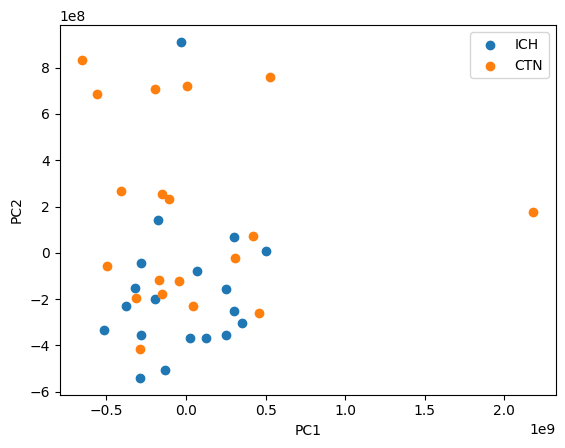

In [278]:
# 2D PCA
plt.scatter(X_tr[labels==0,0], X_tr[labels==0,1])
plt.scatter(X_tr[labels==1,0], X_tr[labels==1,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend({'ICH', 'CTN'})
plt.show()

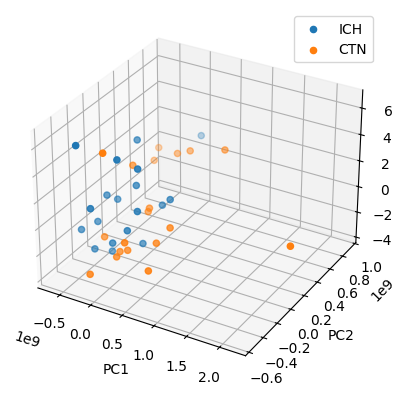

In [279]:
# 3D PCA?
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_tr[labels==0,0], X_tr[labels==0,1], X_tr[labels==0,2])
ax.scatter(X_tr[labels==1,0], X_tr[labels==1,1], X_tr[labels==1,2])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend({'ICH', 'CTN'})
plt.show()

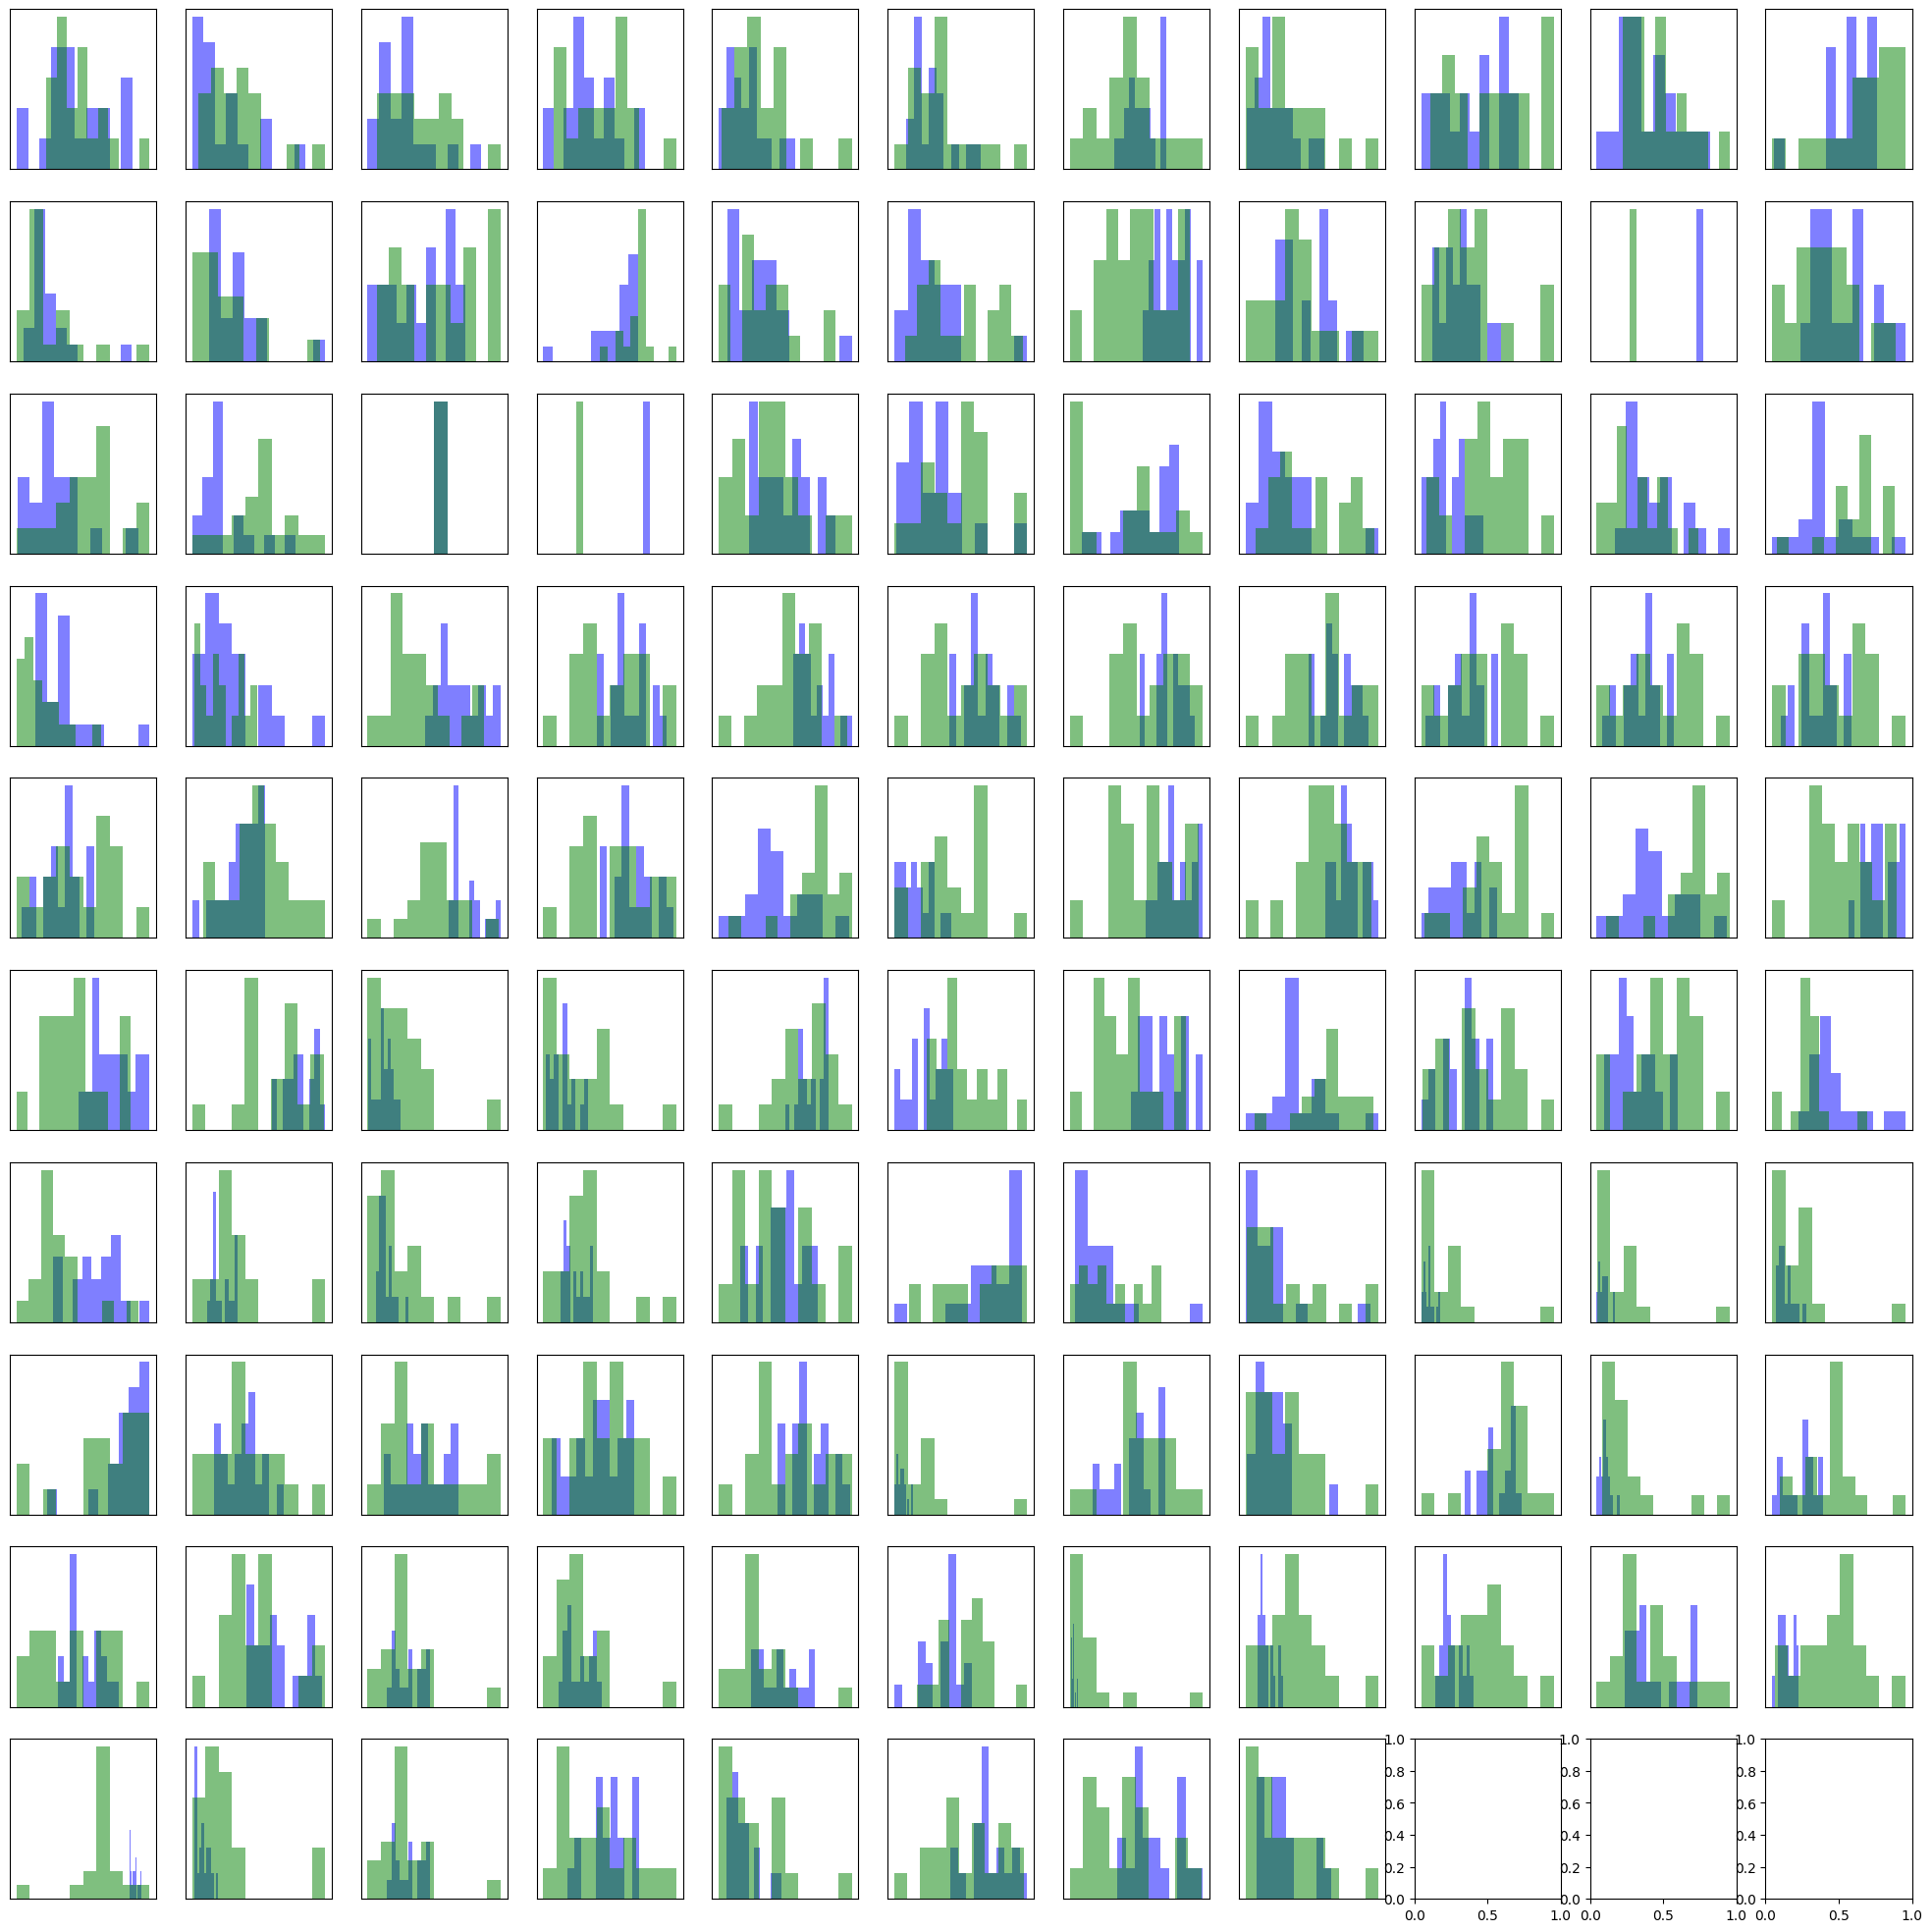

In [282]:
# Check for normality - for each feature, see how their values are distributed between ICH and CTN
# Calculate a p-value using t-test and Wilcoxon rank-sums between each class for each of the features
fig, ax = plt.subplots(nrows=10, ncols=11, figsize=(25,25))
rc_list = np.unravel_index(np.arange(10*11), (10,11))
rs_pvals = []
tt_pvals = []
for i in range(len(col_names)):
    row, col = rc_list[0][i], rc_list[1][i]
    feat = col_names[i]
    feat_ich = X[np.where(labels == 0),i][0]
    feat_ctn = X[np.where(labels == 1),i][0]
    ax[row,col].hist(feat_ich, color='b', alpha=0.5)
    ax[row,col].hist(feat_ctn, color='g', alpha=0.5)
    # Hide axes ticks
    ax[row,col].set_xticks([])
    ax[row,col].set_yticks([])

    tt_pvals.append(ttest_ind(feat_ich, feat_ctn).pvalue)
    rs_pvals.append(ranksums(feat_ich, feat_ctn).pvalue)
plt.show()

In [283]:
# Need to correct our pvalues due to multiple testing
corrected_tt_pvals = multipletests(tt_pvals, method='bonferroni')
corrected_rs_pvals = multipletests(rs_pvals, method='bonferroni')

In [284]:
# Get features that are significant based on their corrected rank-sums test p-value
sig_rs_feats = []
for i in range(len(col_names)):
    if corrected_rs_pvals[0][i]:
        sig_rs_feats.append((col_names[i], corrected_rs_pvals[1][i]))

In [285]:
sig_rs_feats = sorted(sig_rs_feats, key=lambda x: x[1])

In [287]:
sig_rs_feats

[('firstorder_Maximum', 1.46250538475542e-05),
 ('firstorder_Range', 1.46250538475542e-05),
 ('glszm_ZoneEntropy', 0.0011917815524429404),
 ('glszm_SmallAreaLowGrayLevelEmphasis', 0.00155665855440394),
 ('glszm_SizeZoneNonUniformity', 0.001776884728060361),
 ('gldm_LowGrayLevelEmphasis', 0.007217850408091318),
 ('glszm_GrayLevelNonUniformity', 0.009215012705299279),
 ('glcm_ClusterTendency', 0.010399471774547253),
 ('firstorder_Uniformity', 0.011726662669078843),
 ('gldm_GrayLevelNonUniformity', 0.011726662669078843),
 ('glcm_Imc2', 0.014874589533407446),
 ('gldm_LargeDependenceLowGrayLevelEmphasis', 0.02112100814386406),
 ('glszm_SizeZoneNonUniformityNormalized', 0.02657497389088939),
 ('glcm_MaximumProbability', 0.029773243971082237),
 ('glcm_SumSquares', 0.029773243971082237),
 ('glszm_GrayLevelNonUniformityNormalized', 0.029773243971082237),
 ('glcm_JointAverage', 0.03728055423272336),
 ('glcm_JointEnergy', 0.03728055423272336),
 ('glcm_SumAverage', 0.03728055423272336),
 ('firstor

In [289]:
feat_idx = [col_names.index(x[0]) for x in sig_rs_feats]

In [290]:
feat_names = np.array(col_names)[feat_idx]
print(feat_names)

['firstorder_Maximum' 'firstorder_Range' 'glszm_ZoneEntropy'
 'glszm_SmallAreaLowGrayLevelEmphasis' 'glszm_SizeZoneNonUniformity'
 'gldm_LowGrayLevelEmphasis' 'glszm_GrayLevelNonUniformity'
 'glcm_ClusterTendency' 'firstorder_Uniformity'
 'gldm_GrayLevelNonUniformity' 'glcm_Imc2'
 'gldm_LargeDependenceLowGrayLevelEmphasis'
 'glszm_SizeZoneNonUniformityNormalized' 'glcm_MaximumProbability'
 'glcm_SumSquares' 'glszm_GrayLevelNonUniformityNormalized'
 'glcm_JointAverage' 'glcm_JointEnergy' 'glcm_SumAverage'
 'firstorder_10Percentile']


In [291]:
# For each feature, find the patients with the minimum, maximum and median feature value
# Since number of patients is even, just choose the 14th (num_patients=38 / 2) ranked patient
ex_dict = {}
for feat in feat_names:
    feat_df = df[feat]
    
    minpat = feat_df[feat_df == feat_df.min()].index[0]
    
    maxpat = feat_df[feat_df == feat_df.max()].index[0]

    tmp = feat_df.copy()
    tmp = tmp.sort_values()
    medpat = tmp.index[int(len(tmp)/2)]
    
    ex_dict[feat] = {'min': minpat, 'max': maxpat, 'median': medpat}

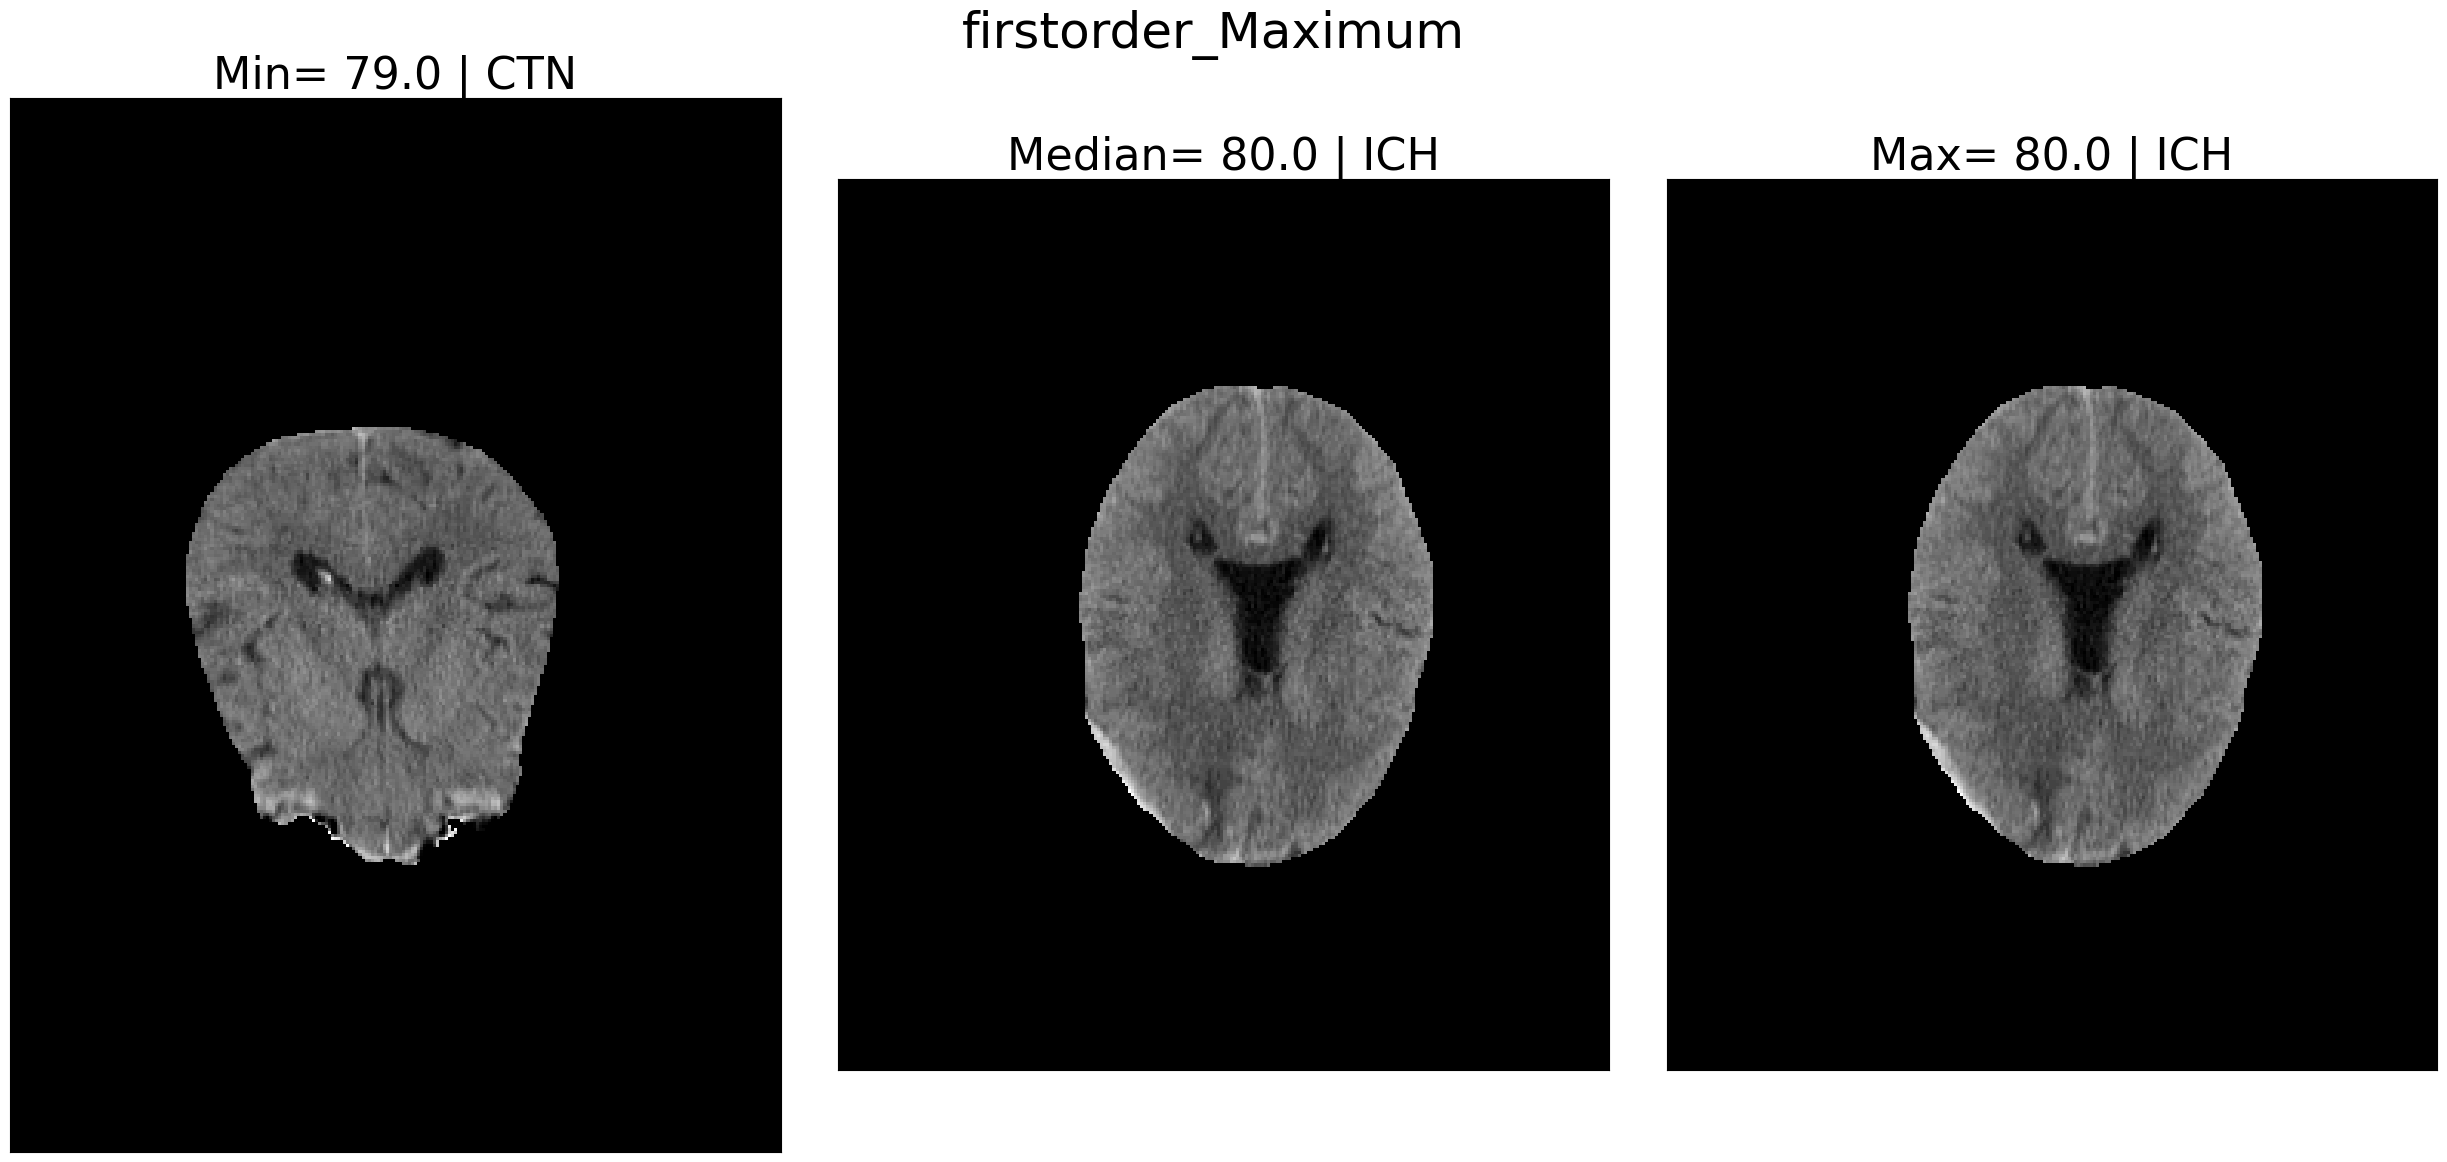

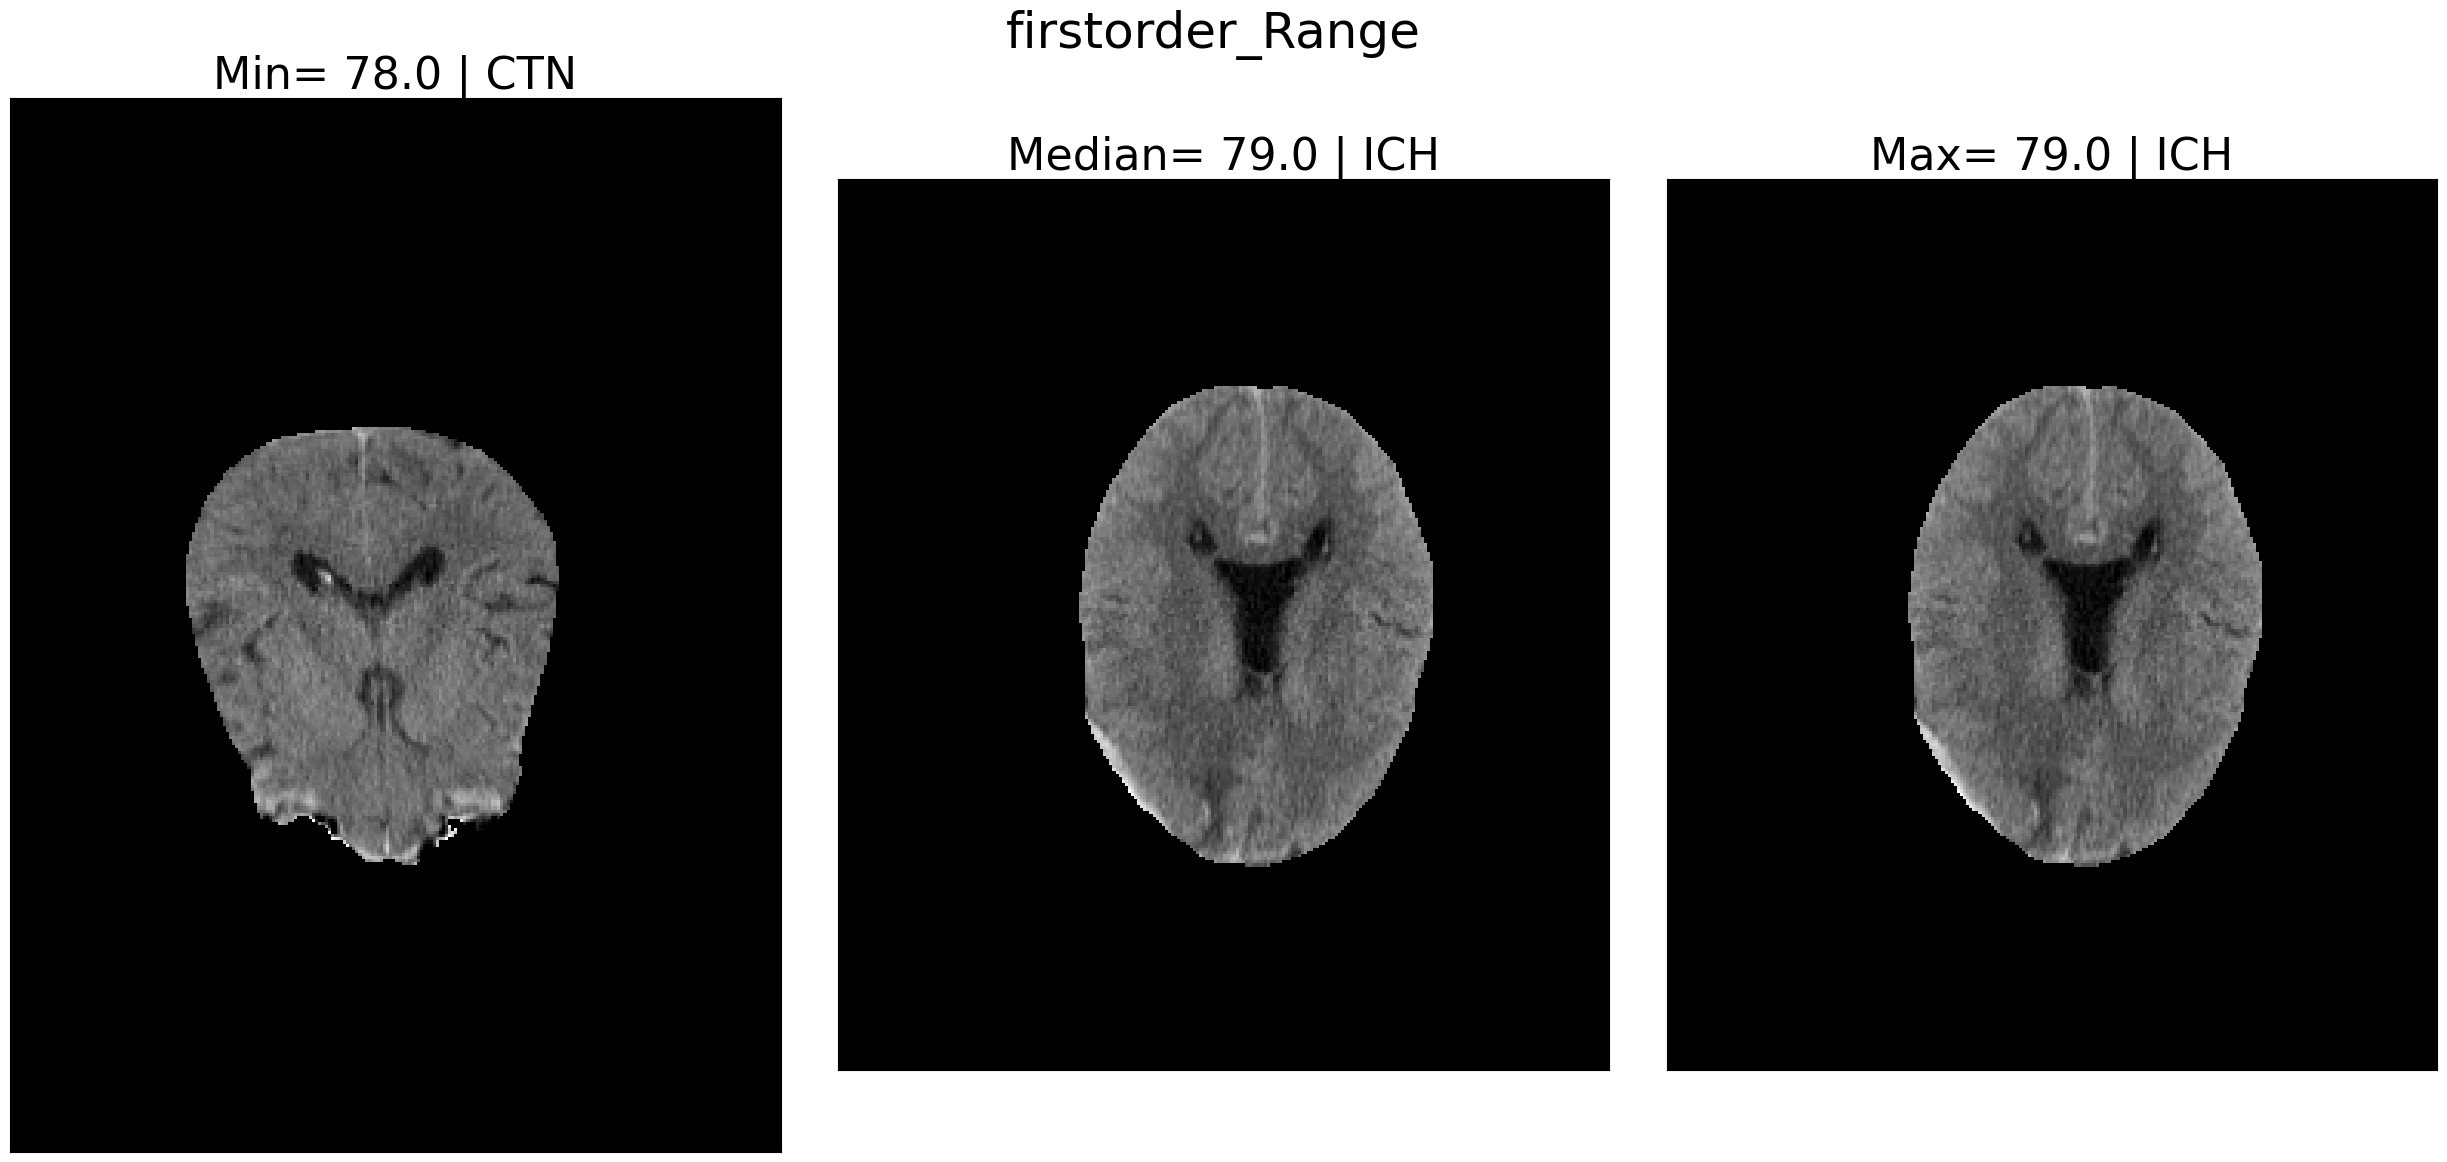

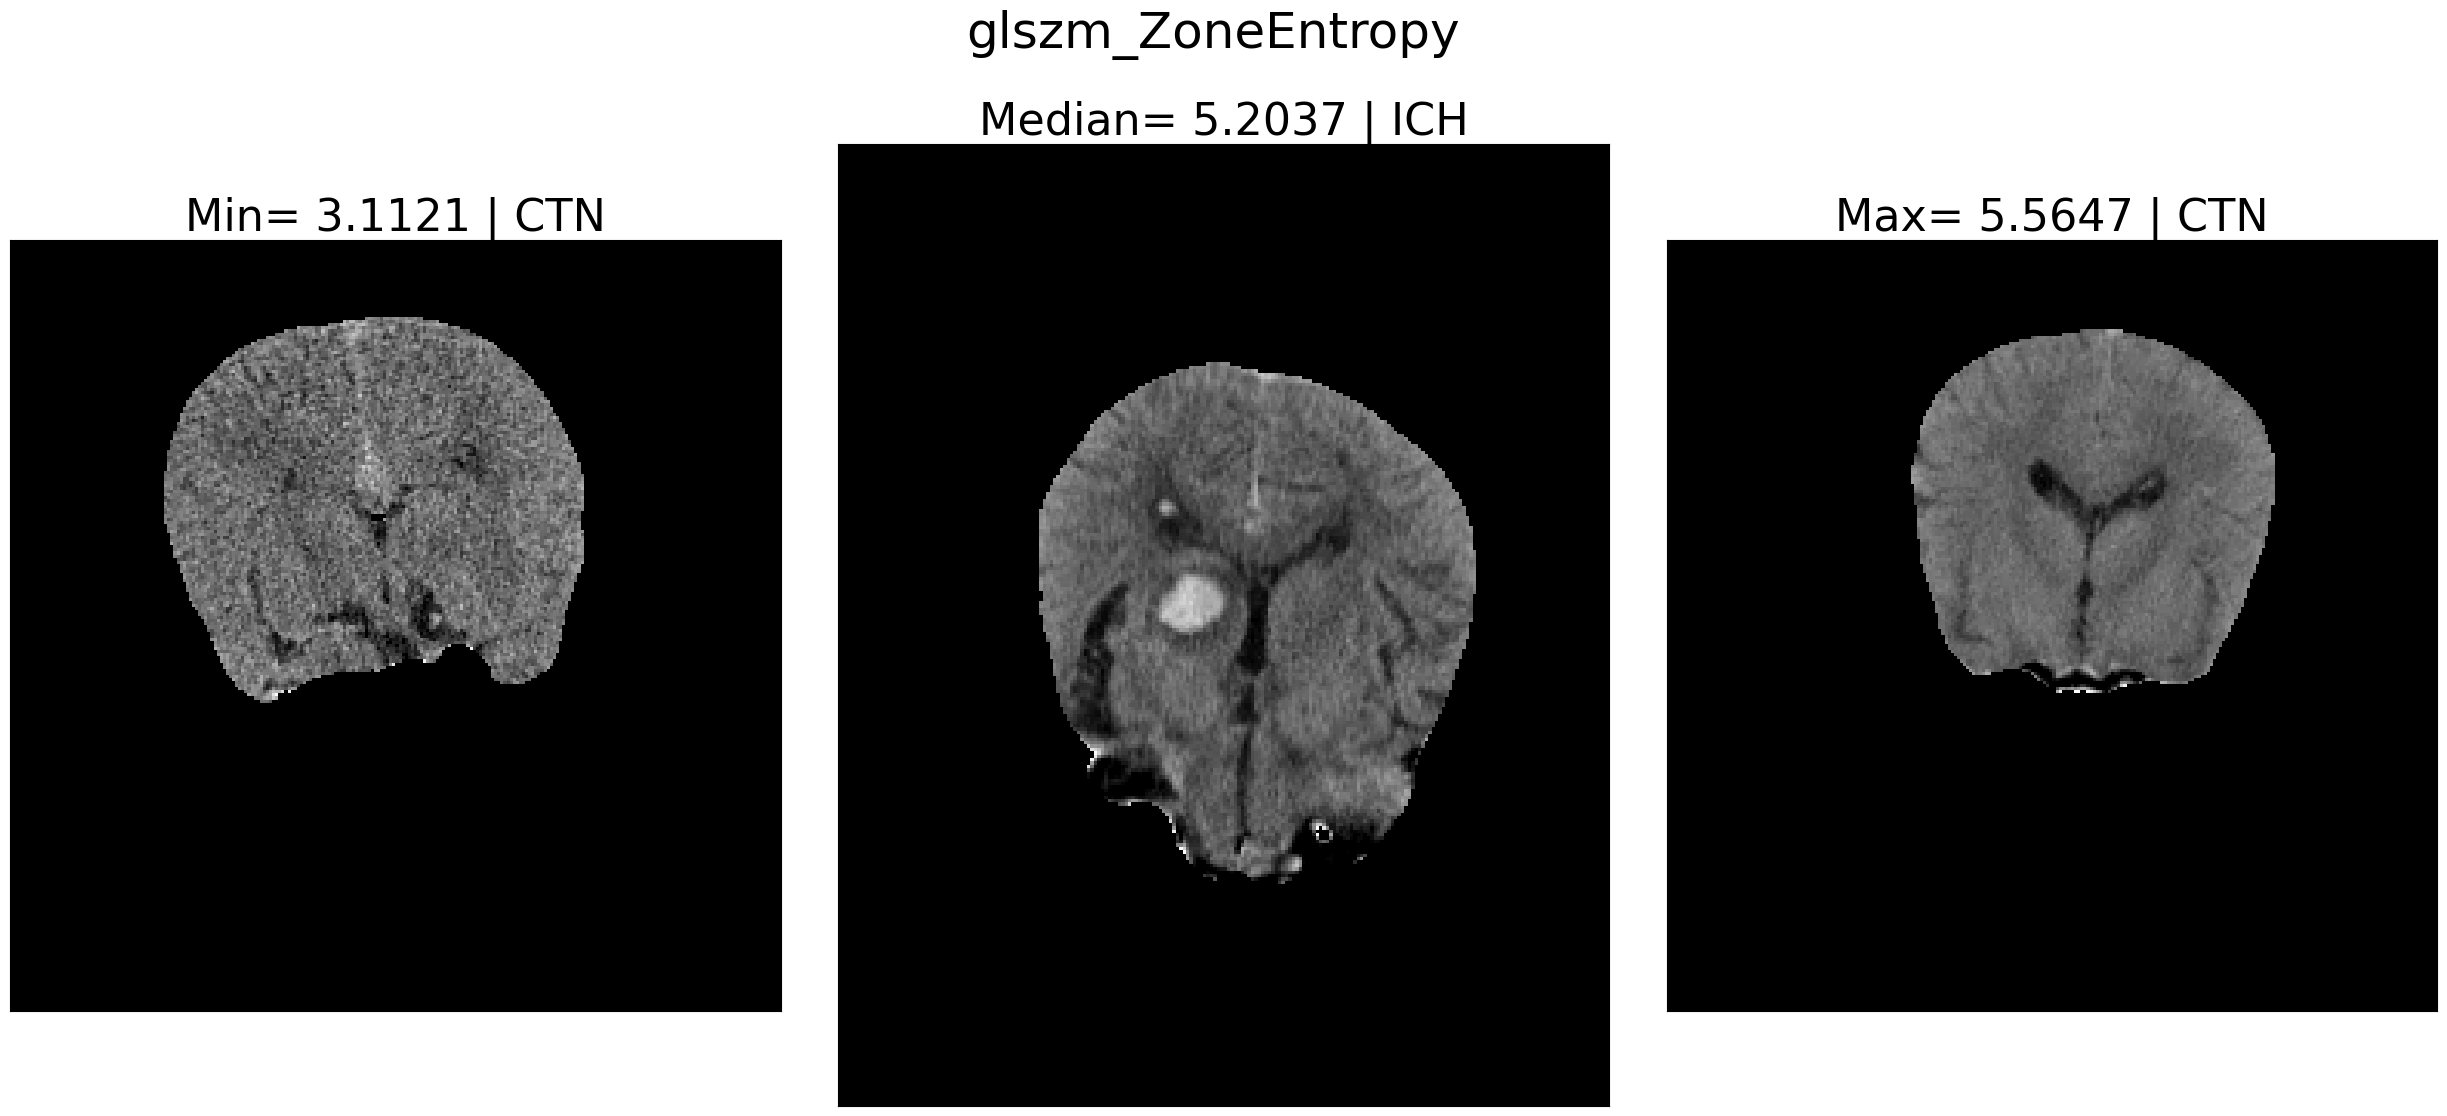

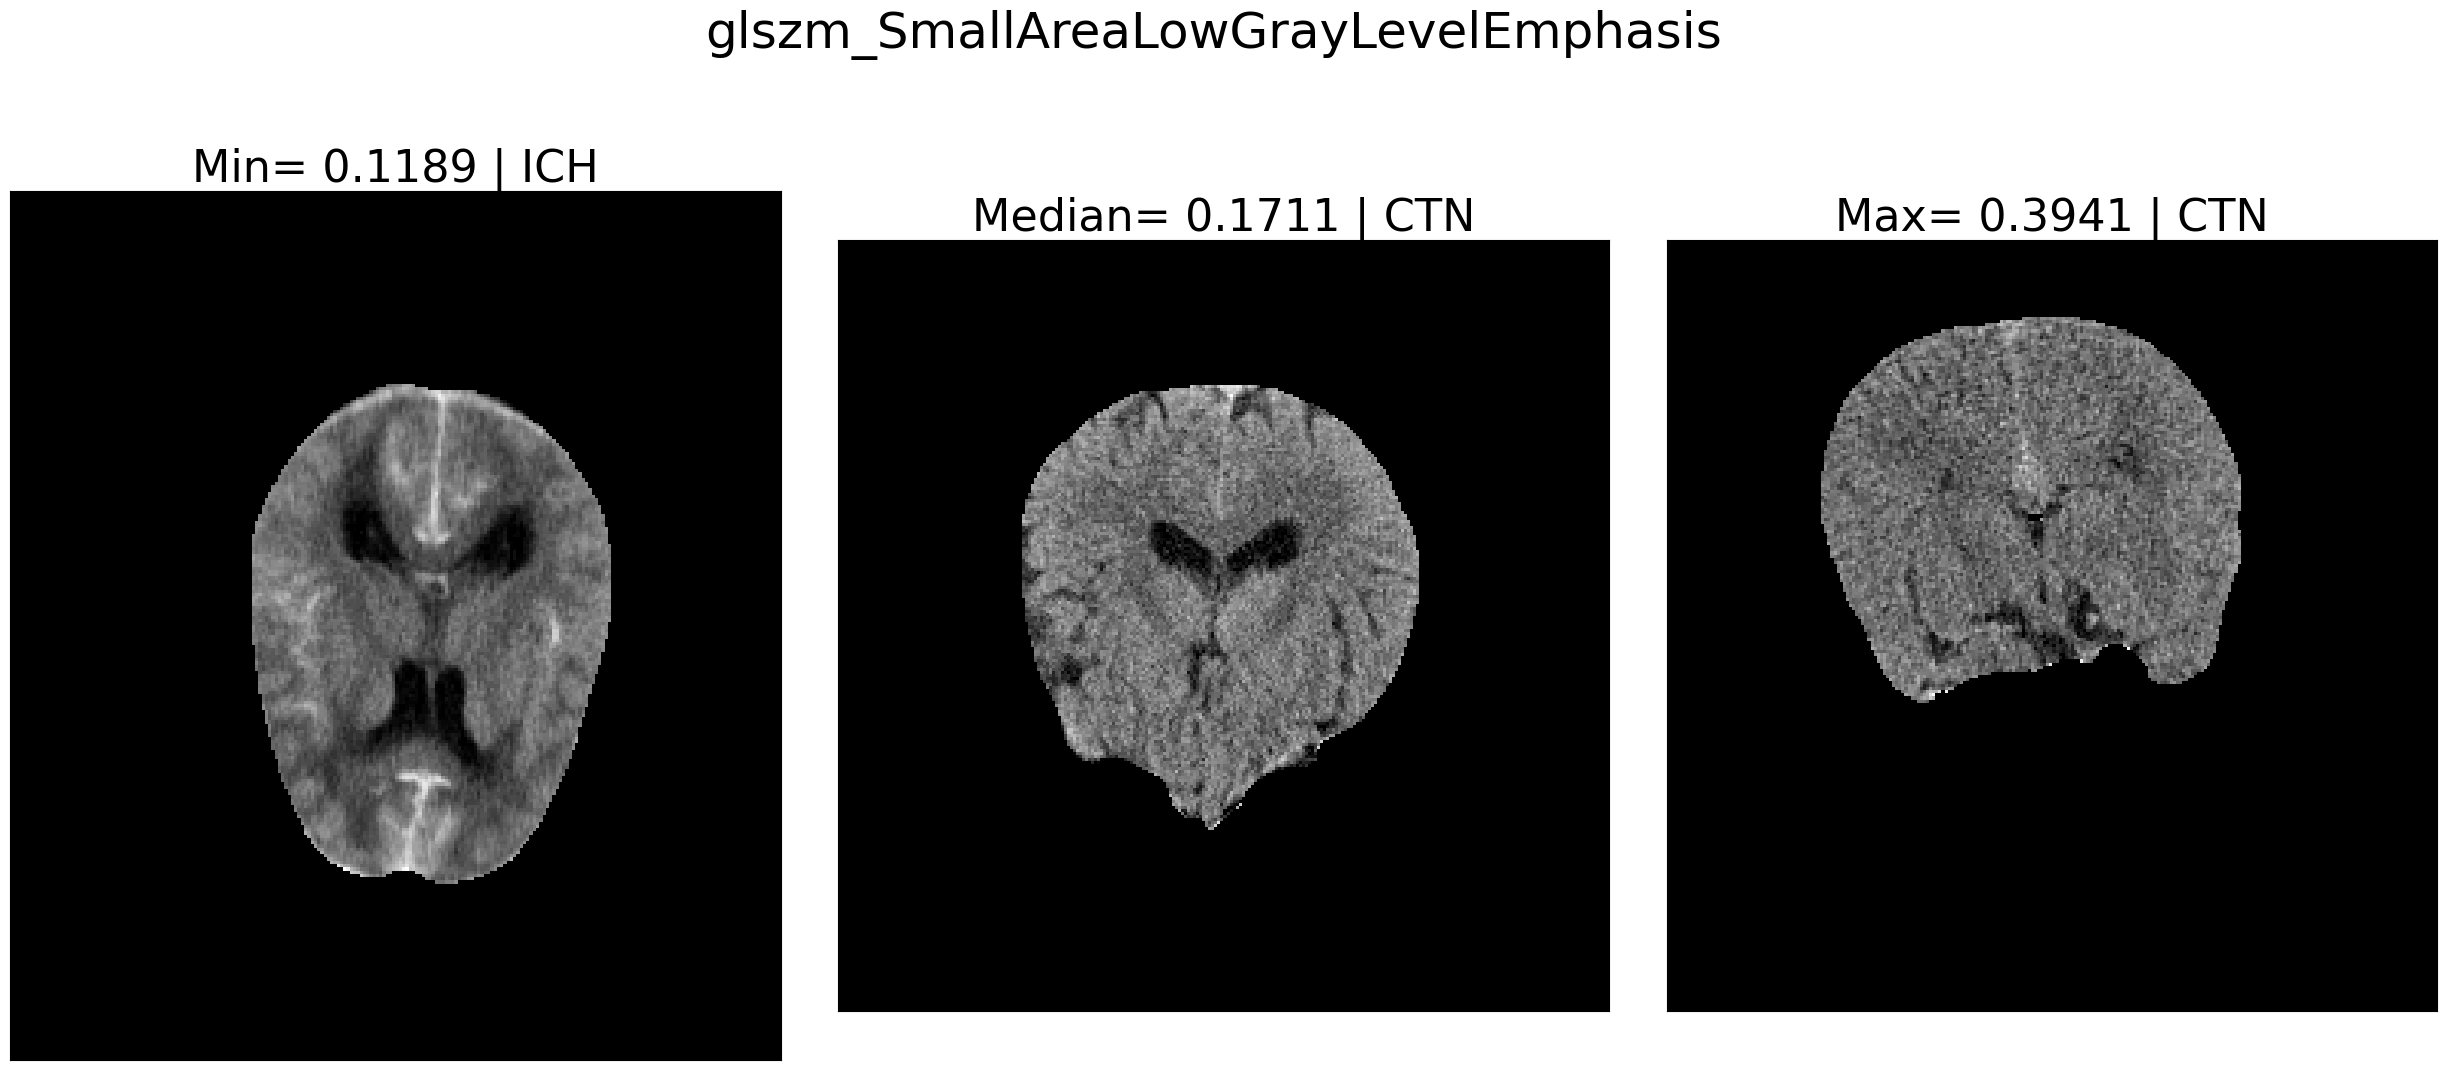

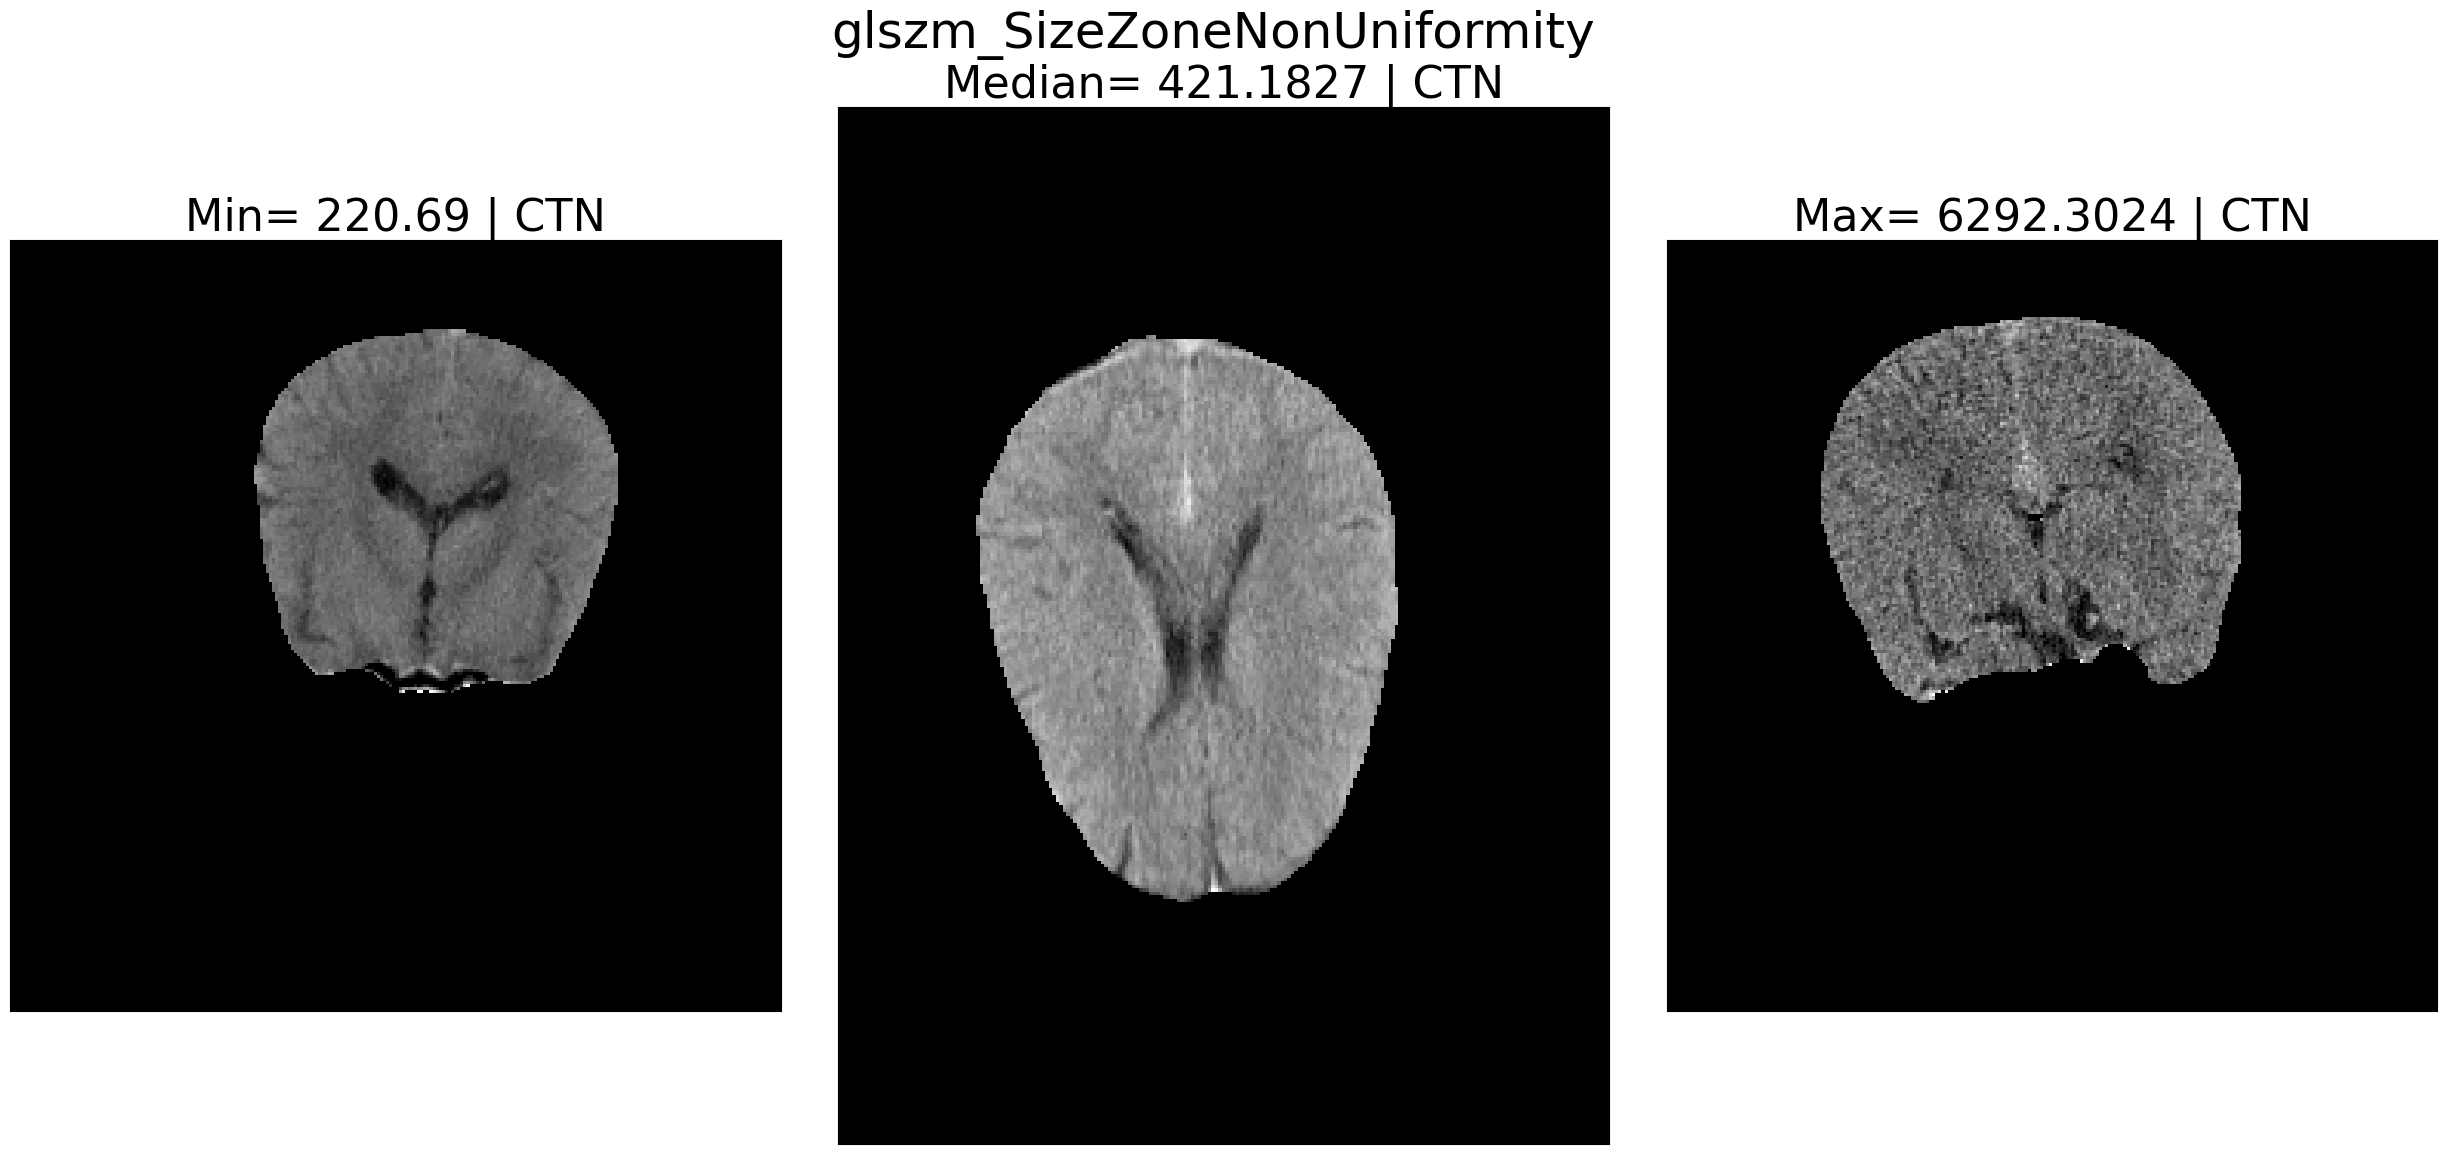

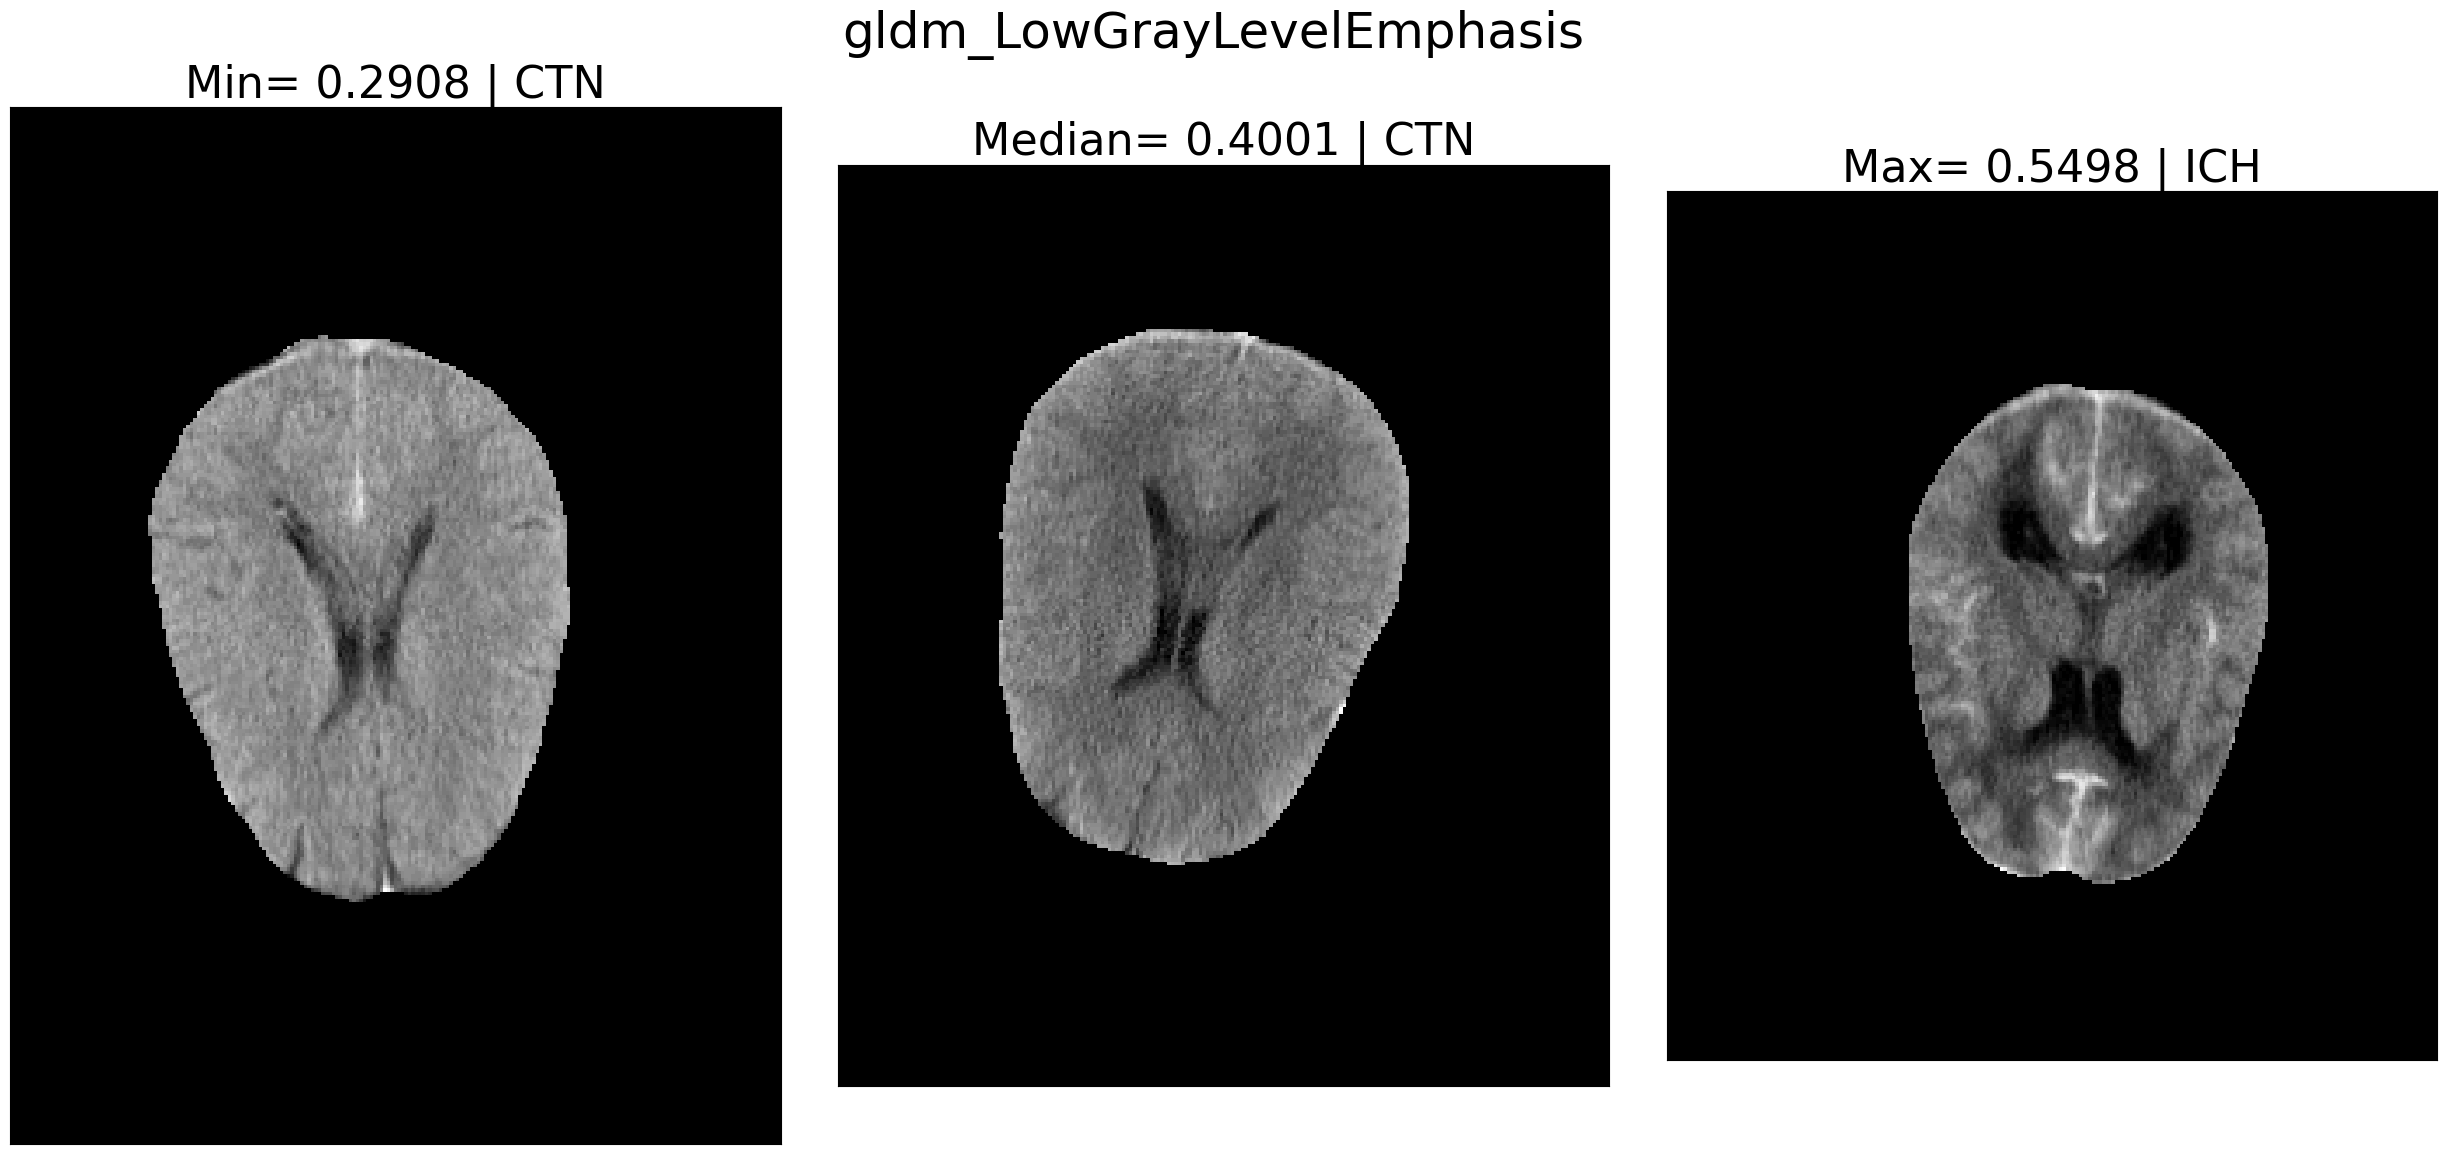

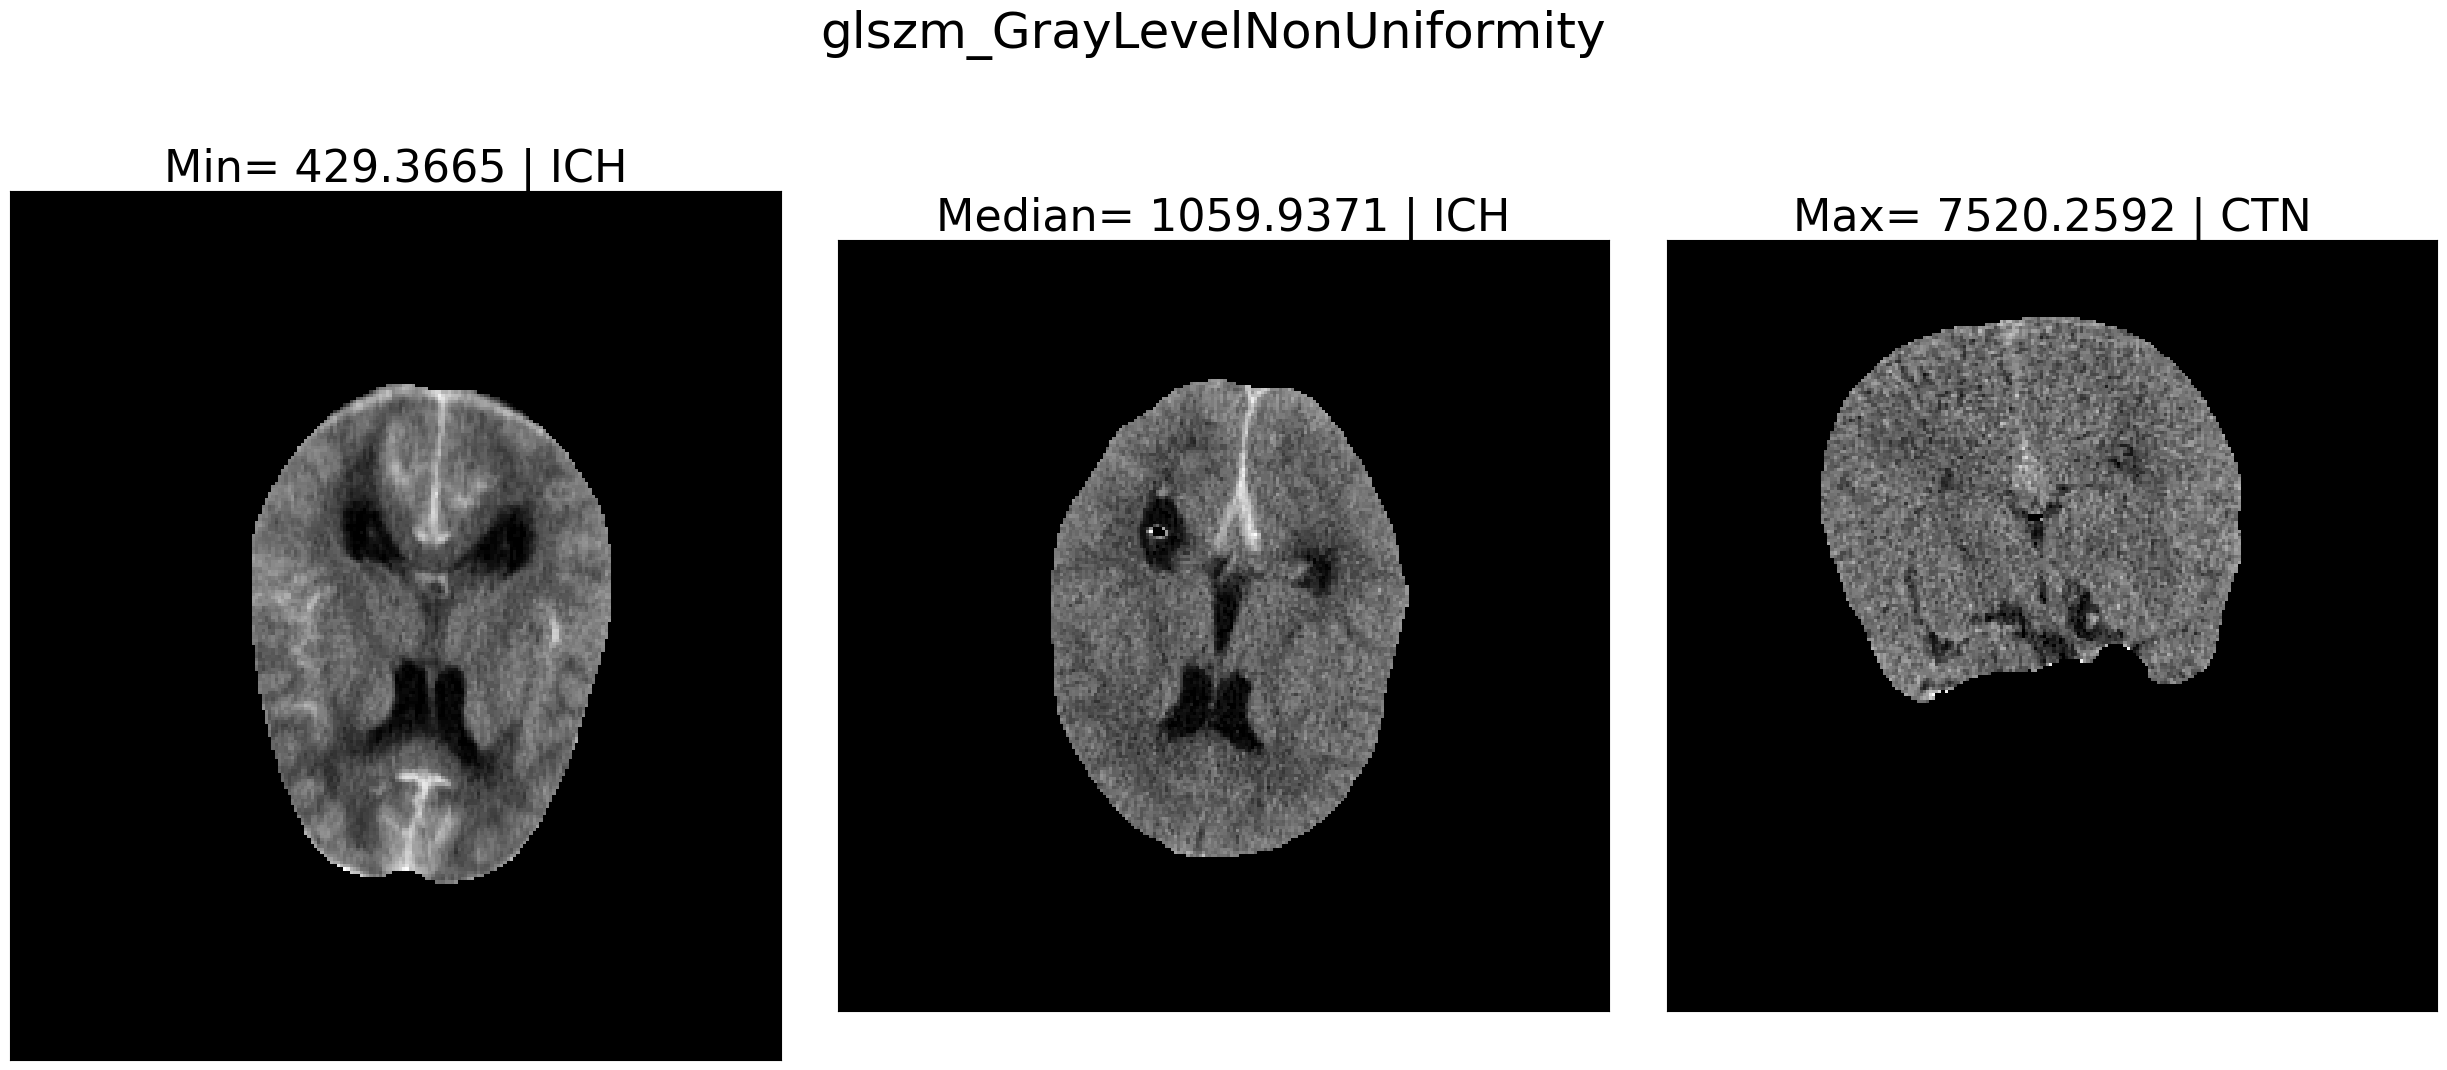

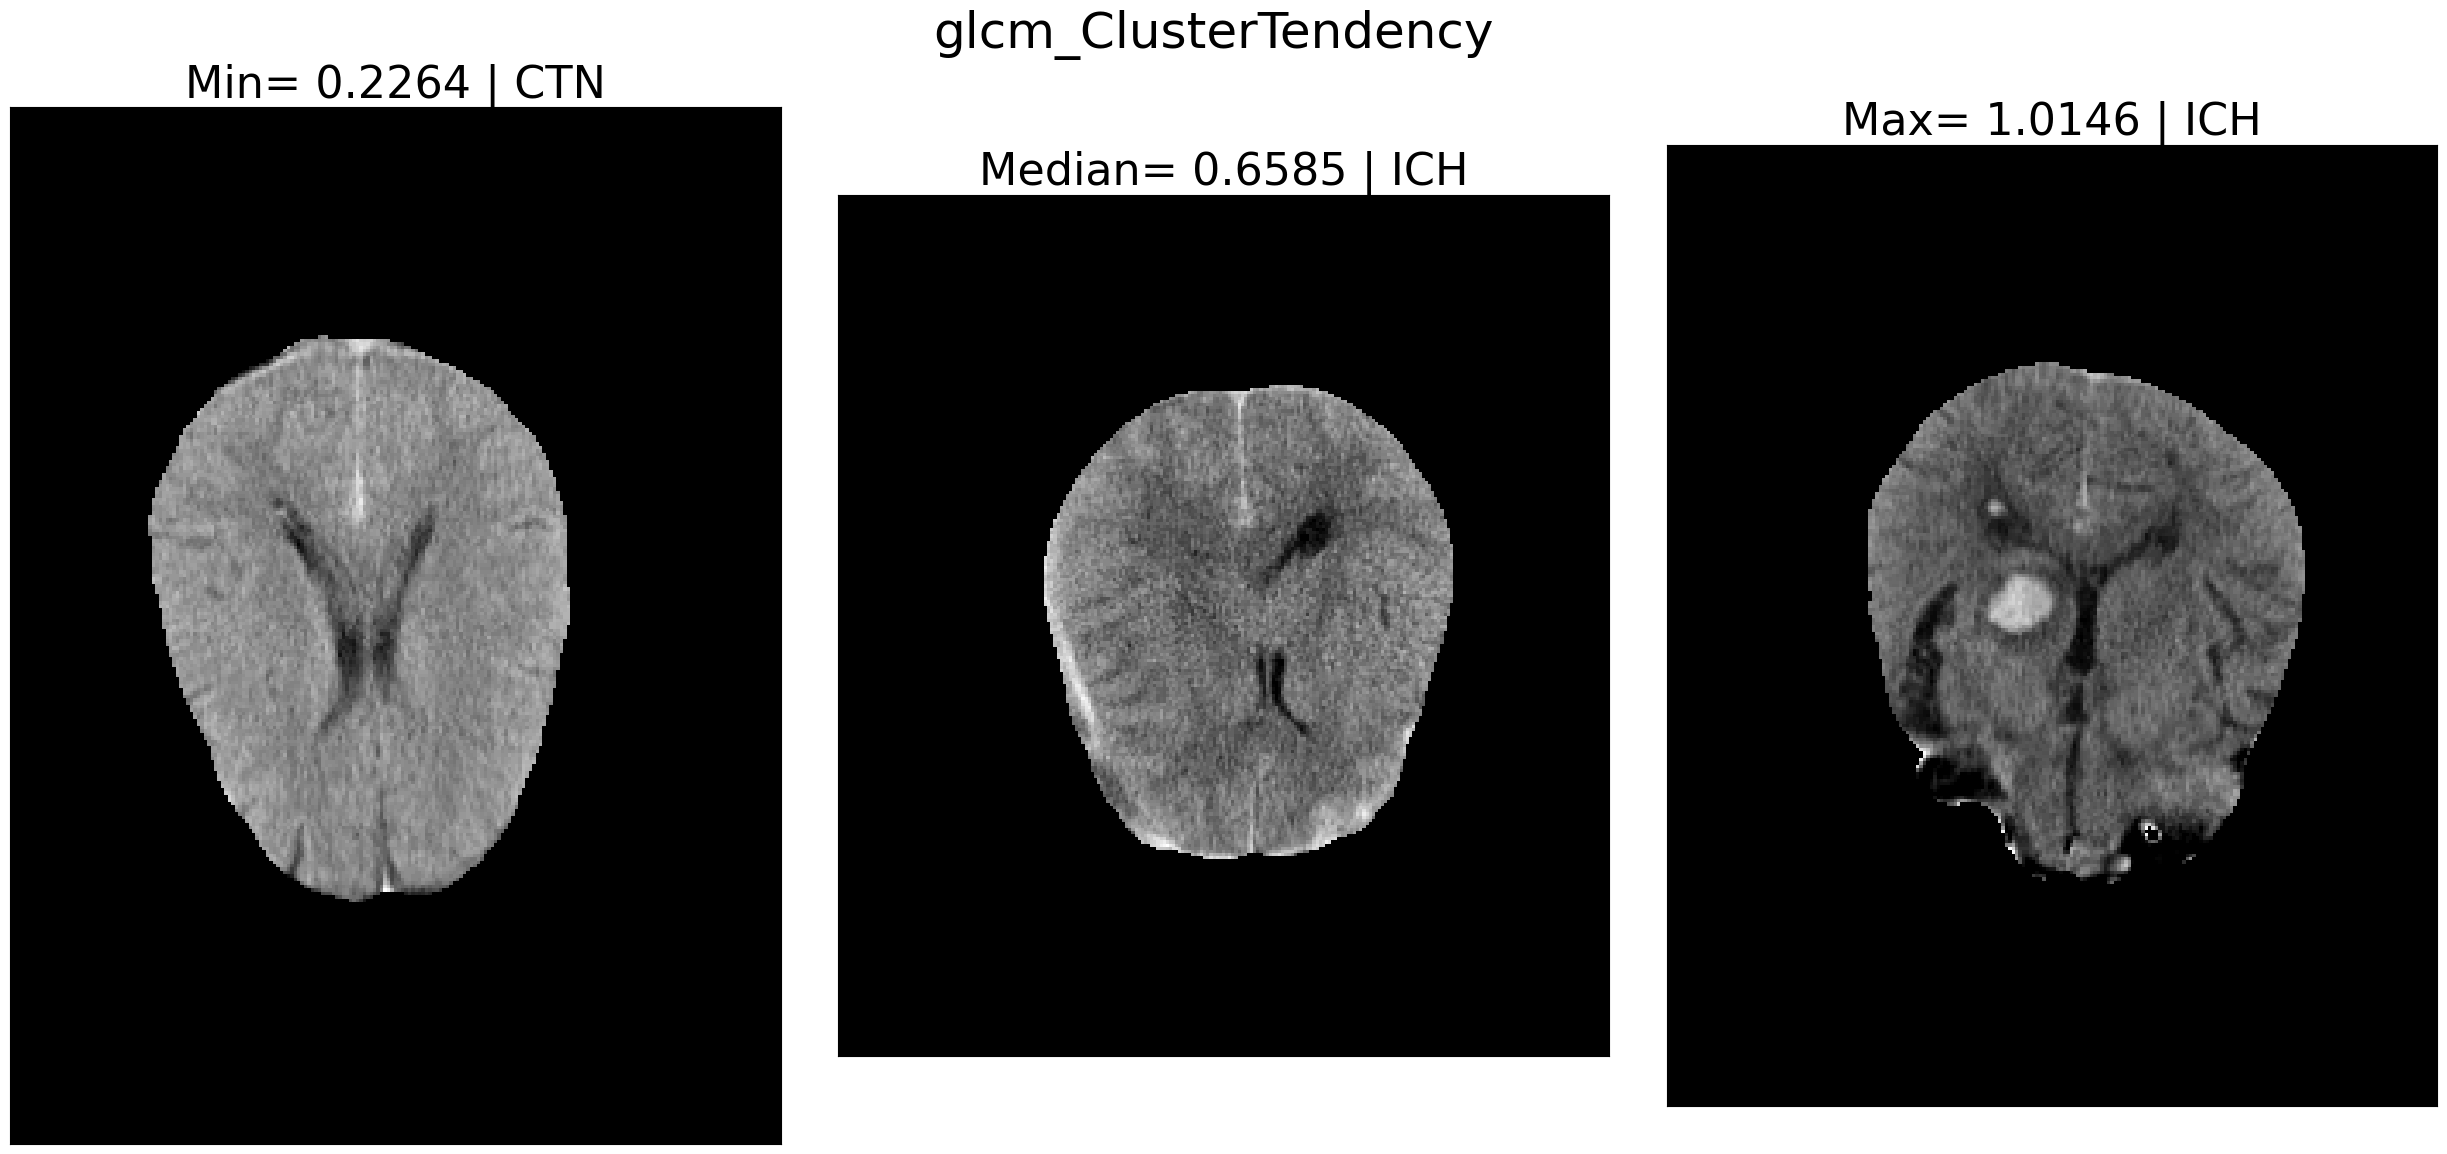

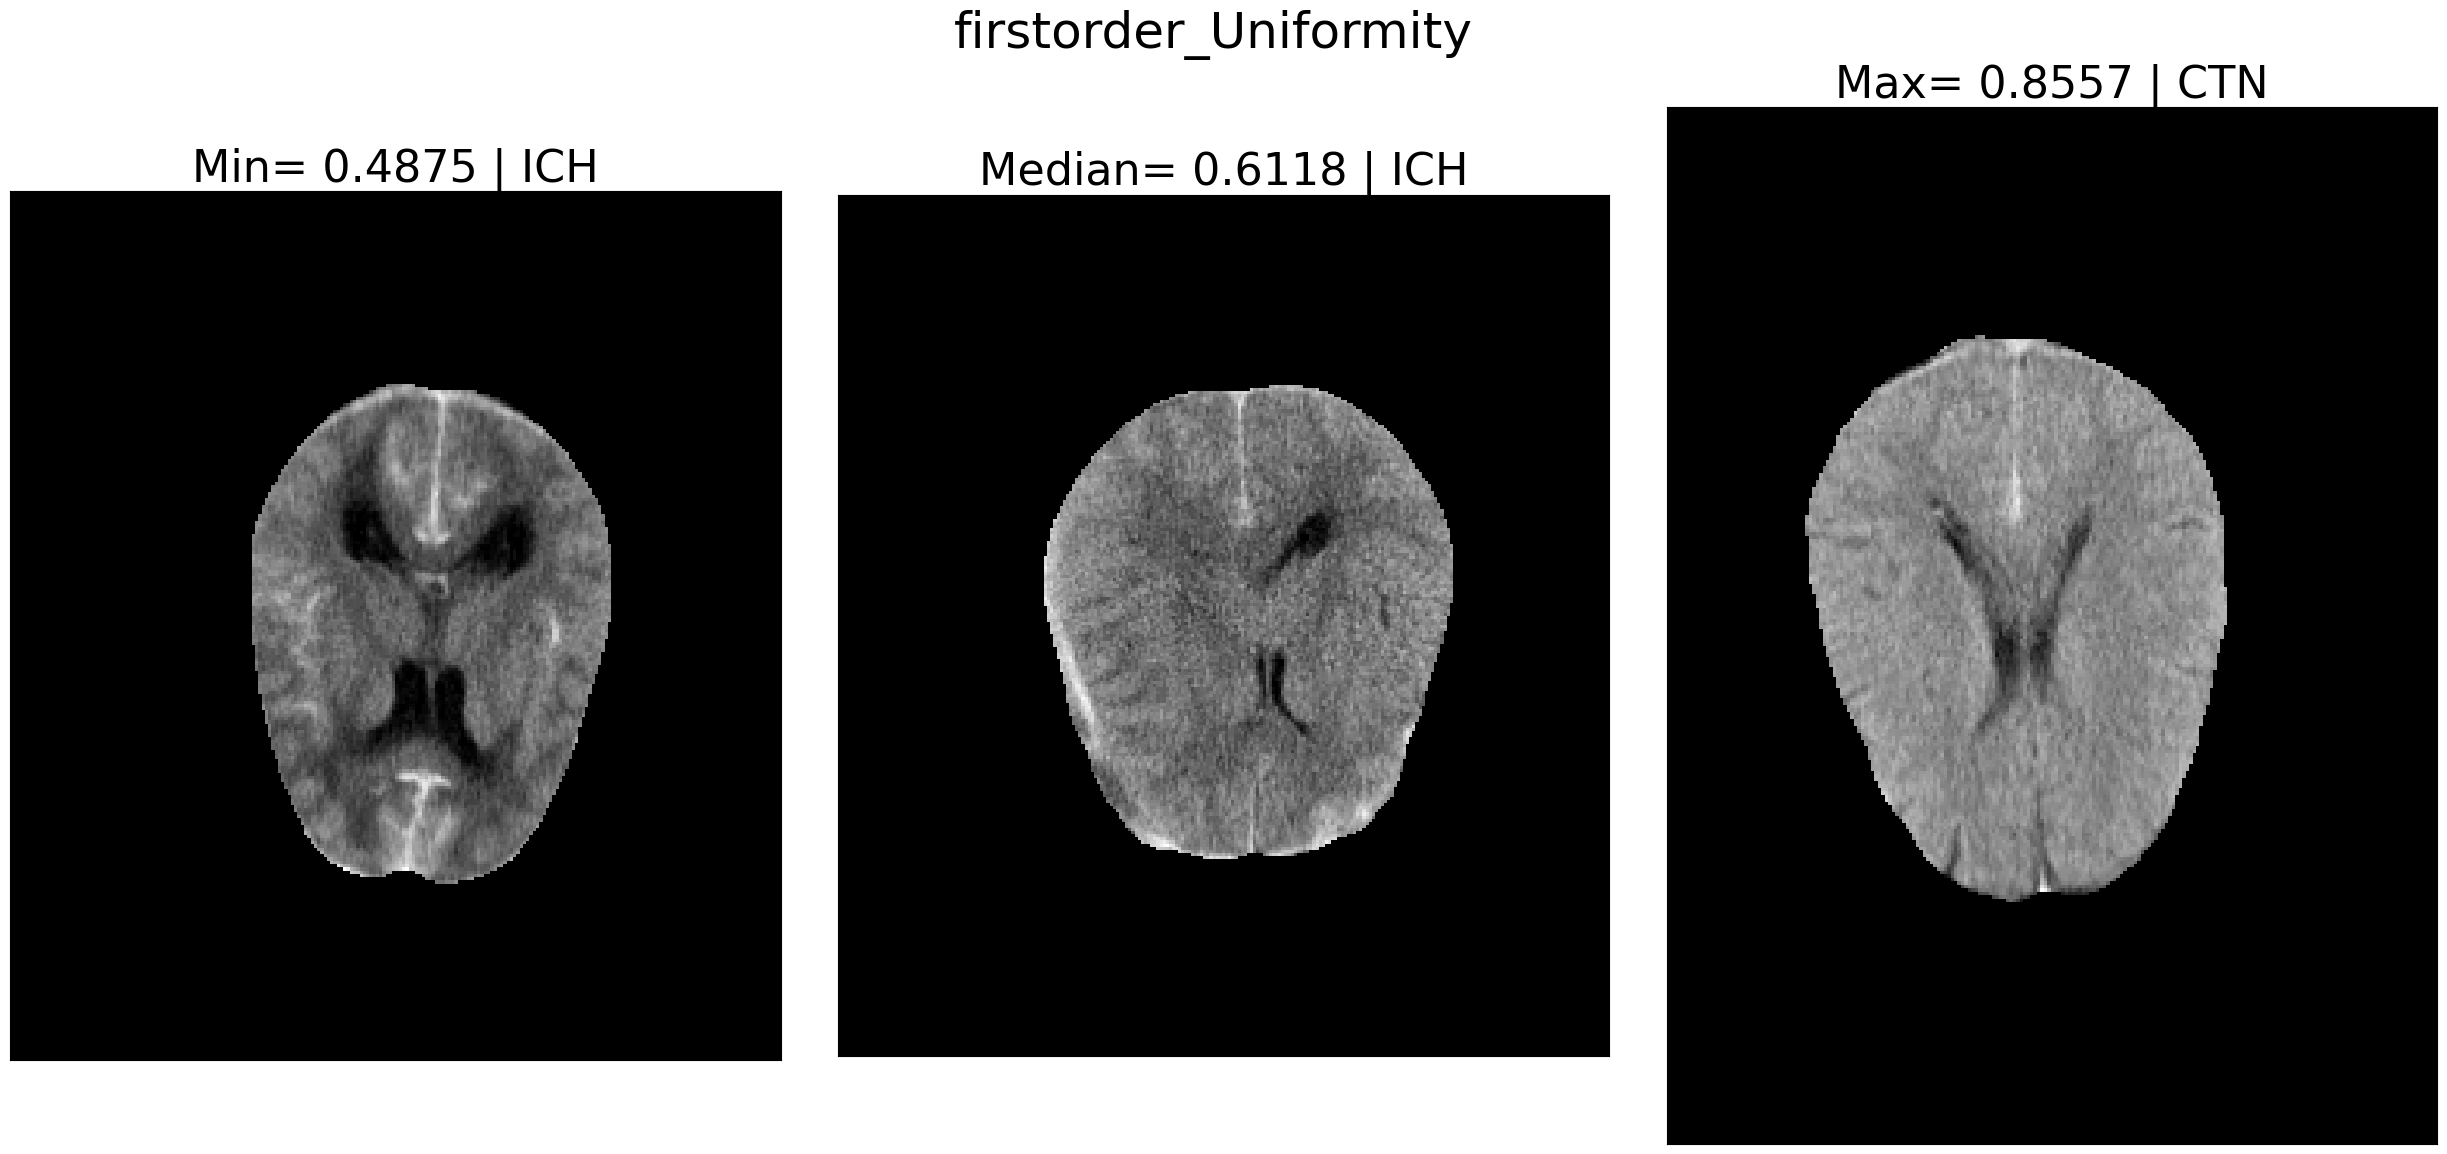

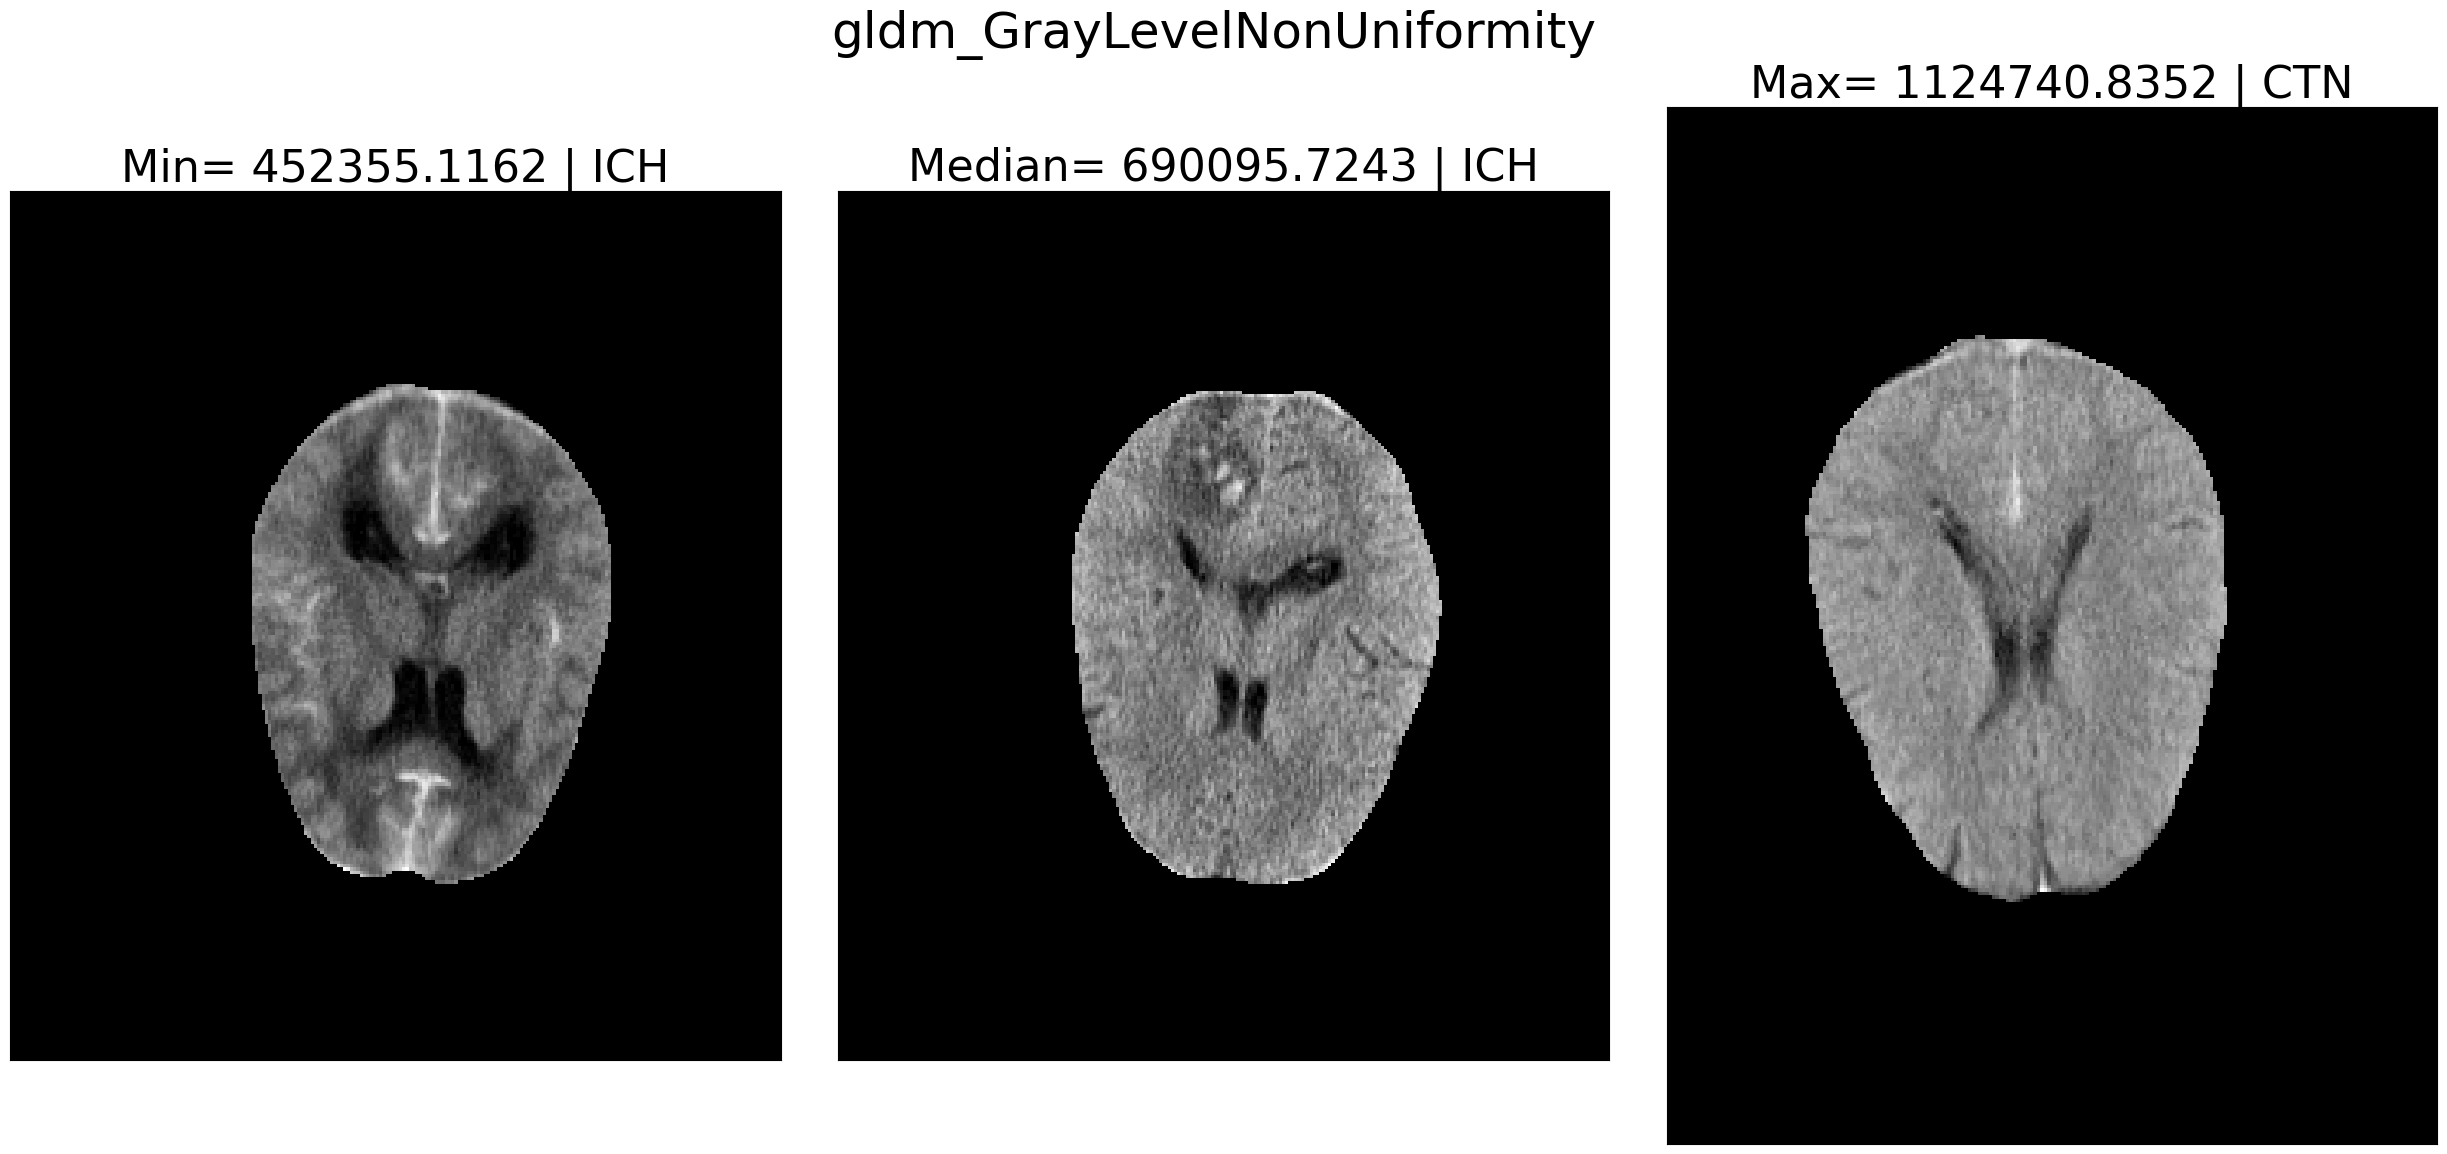

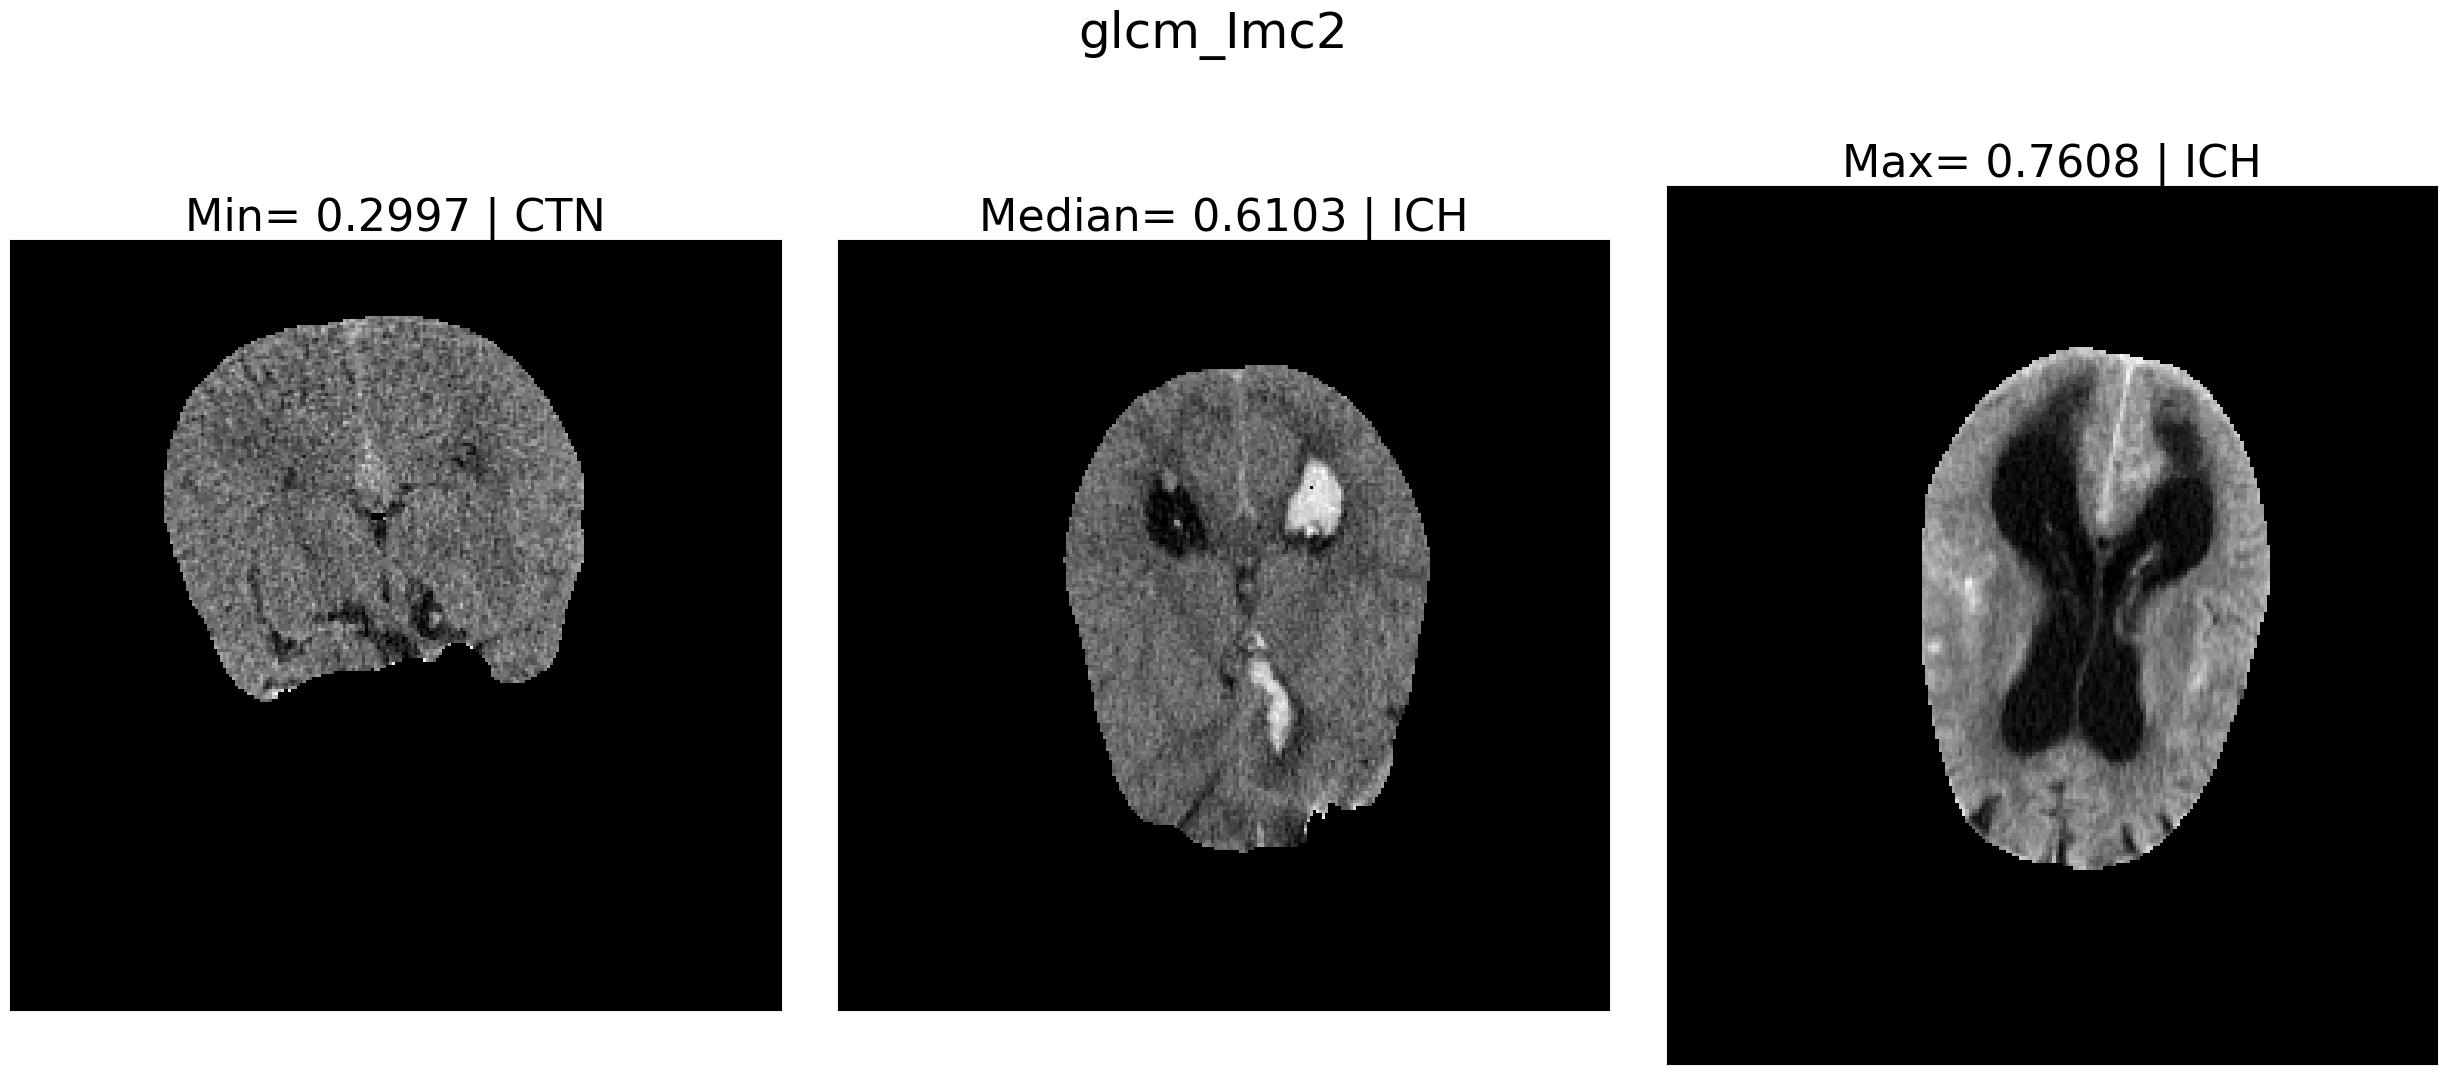

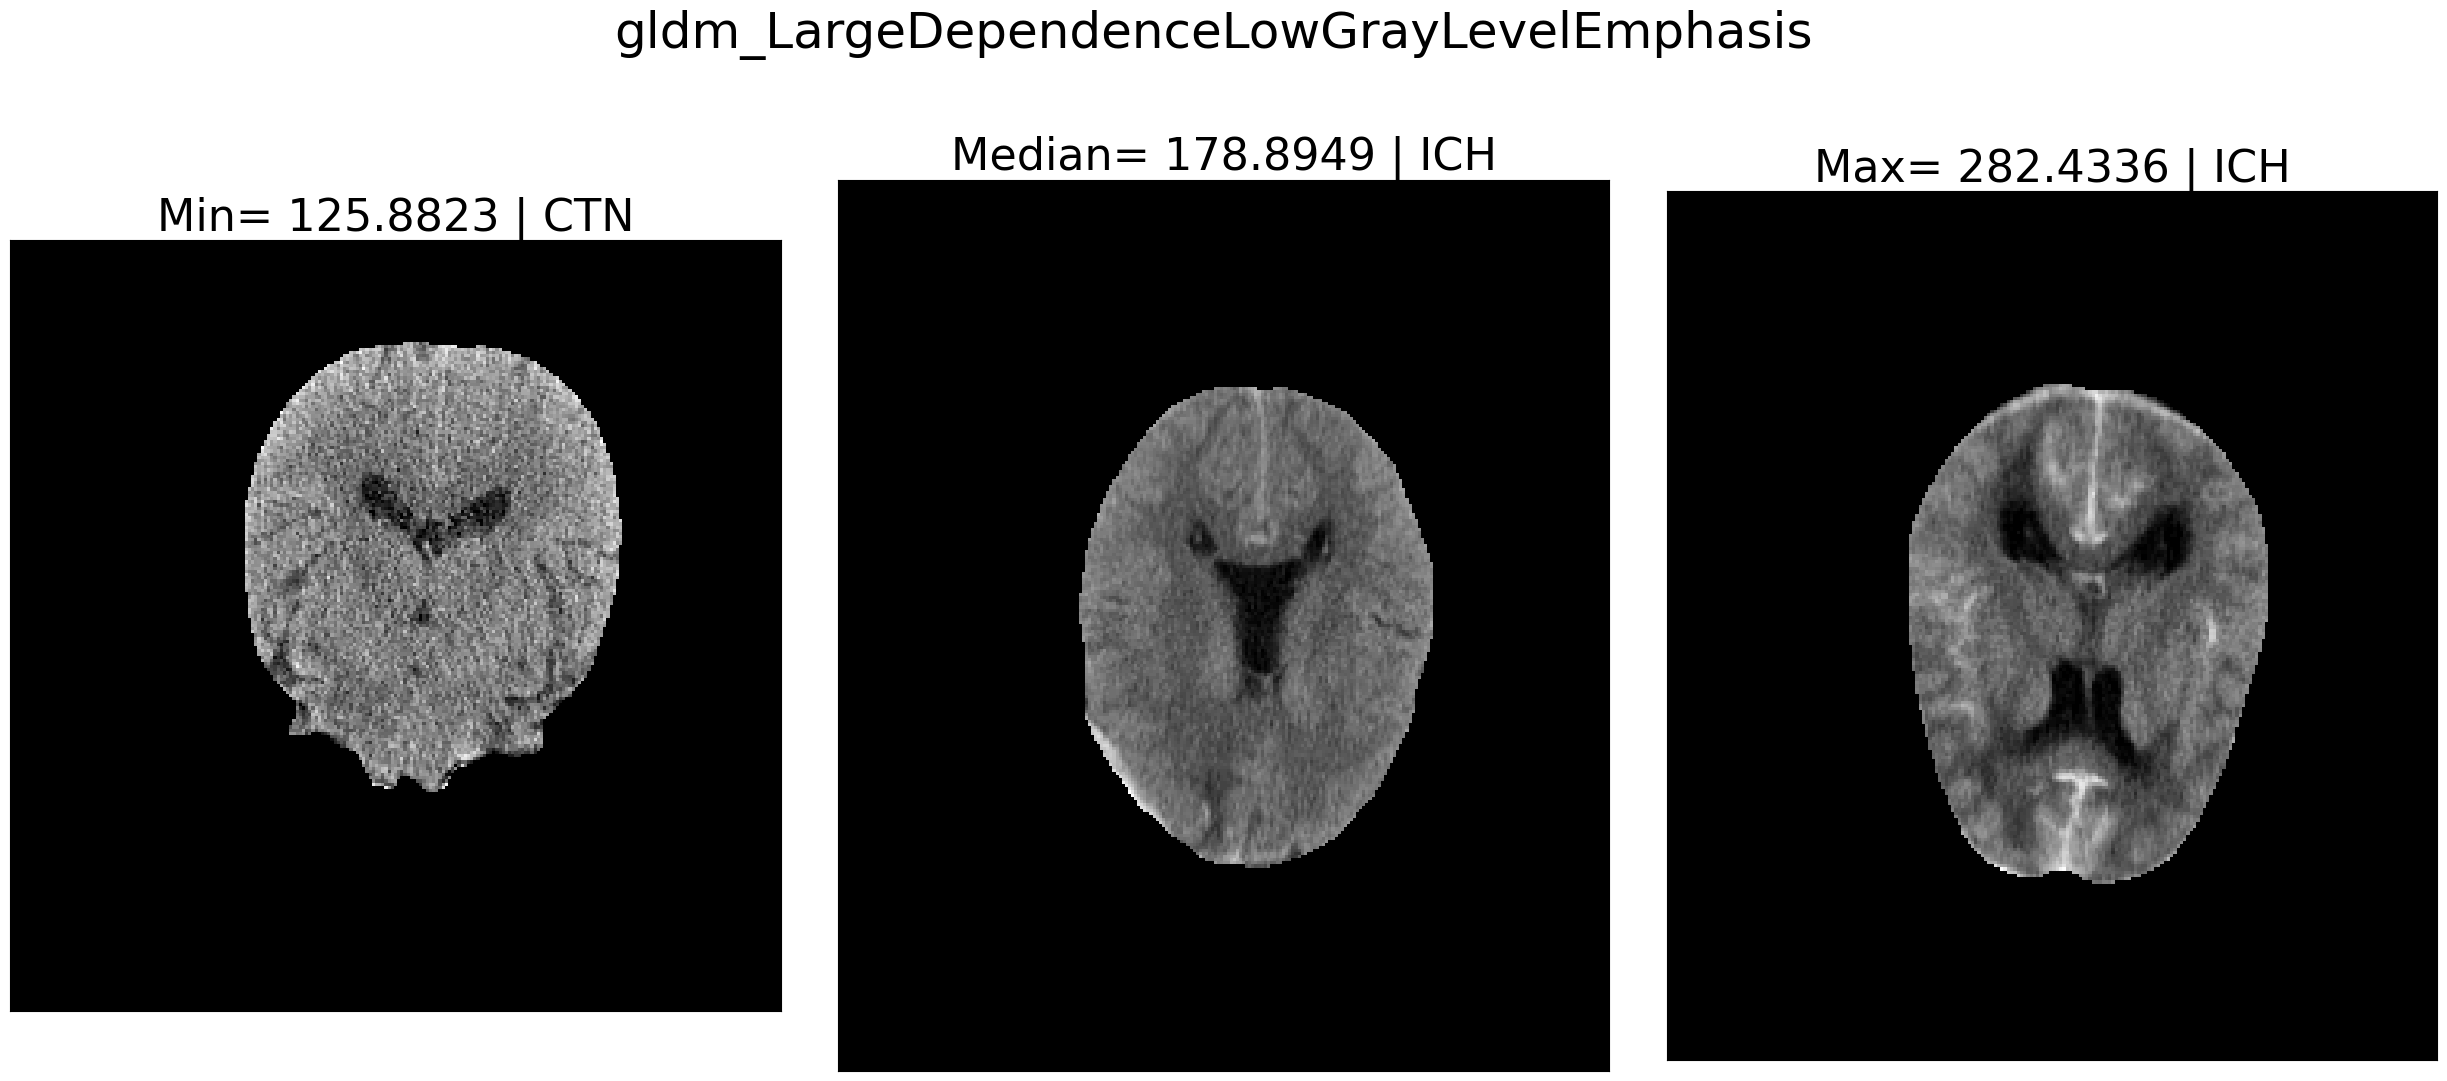

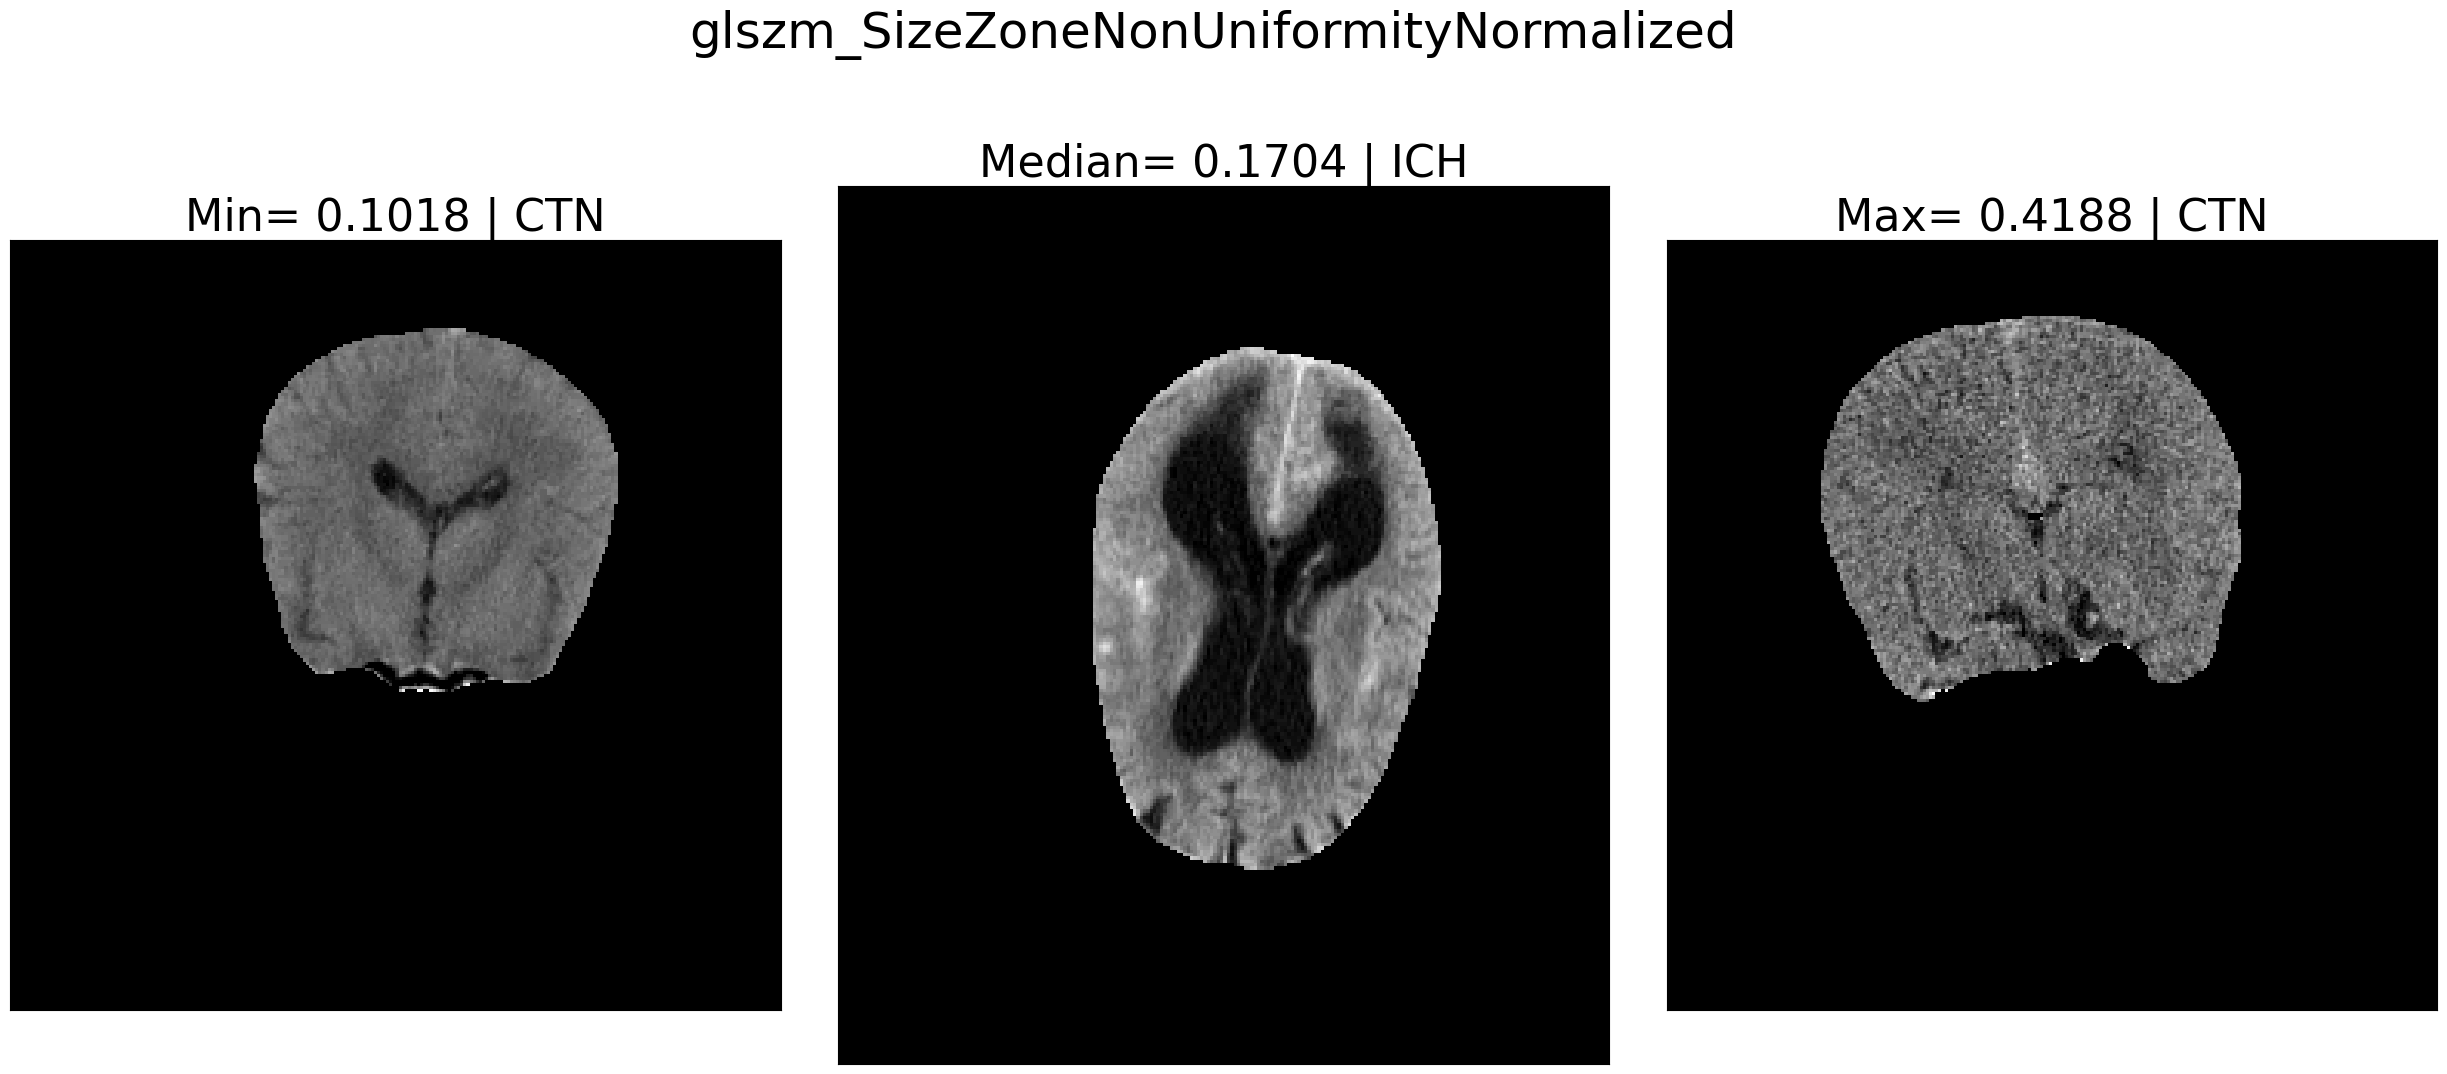

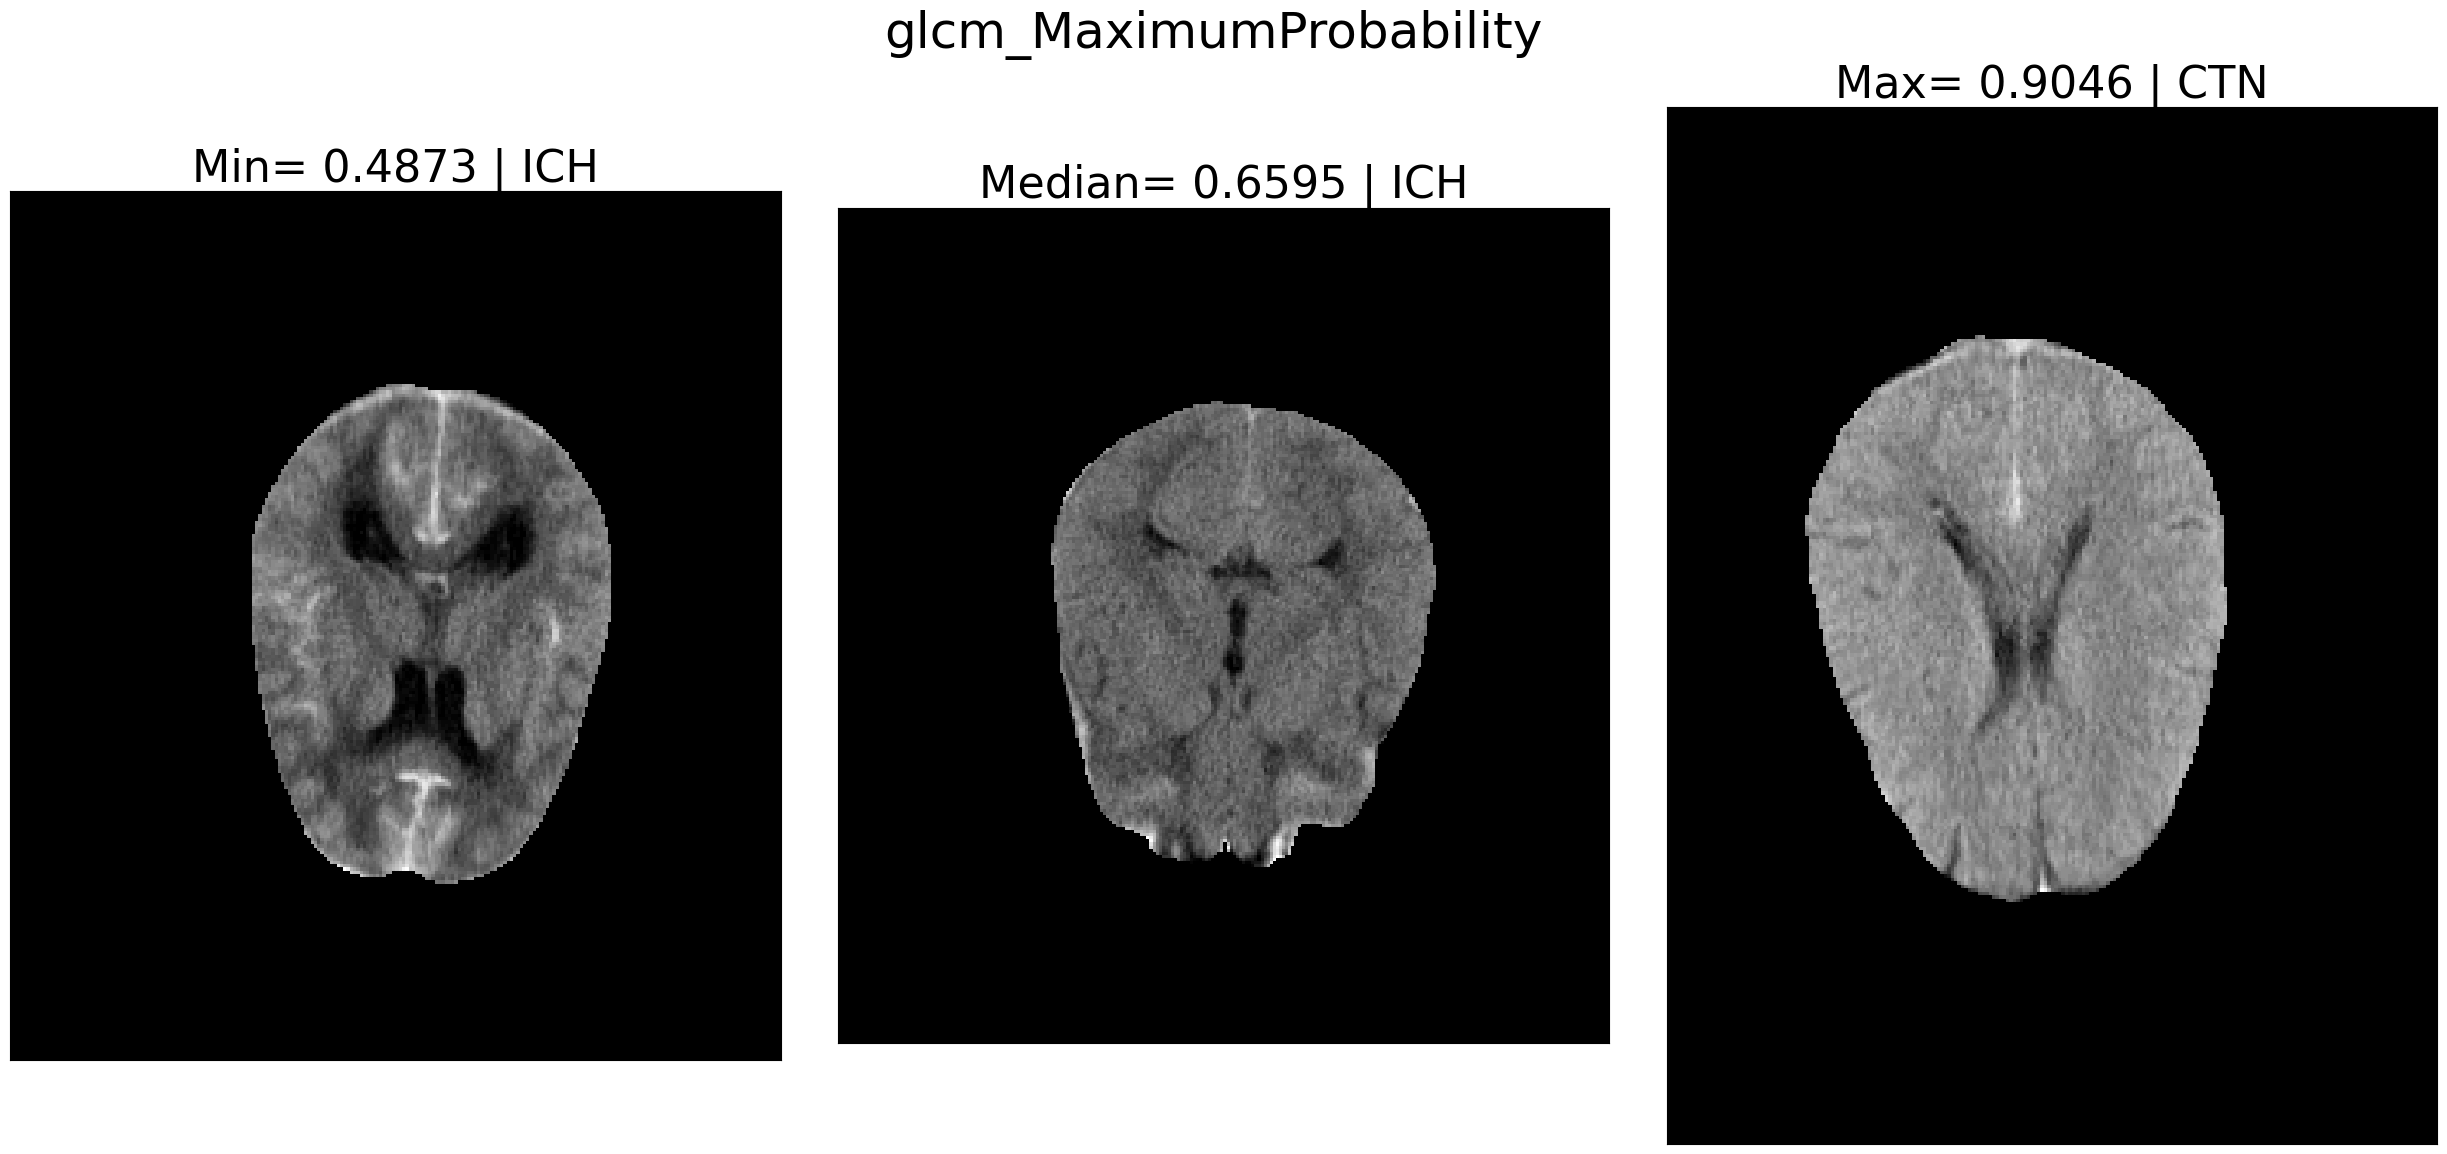

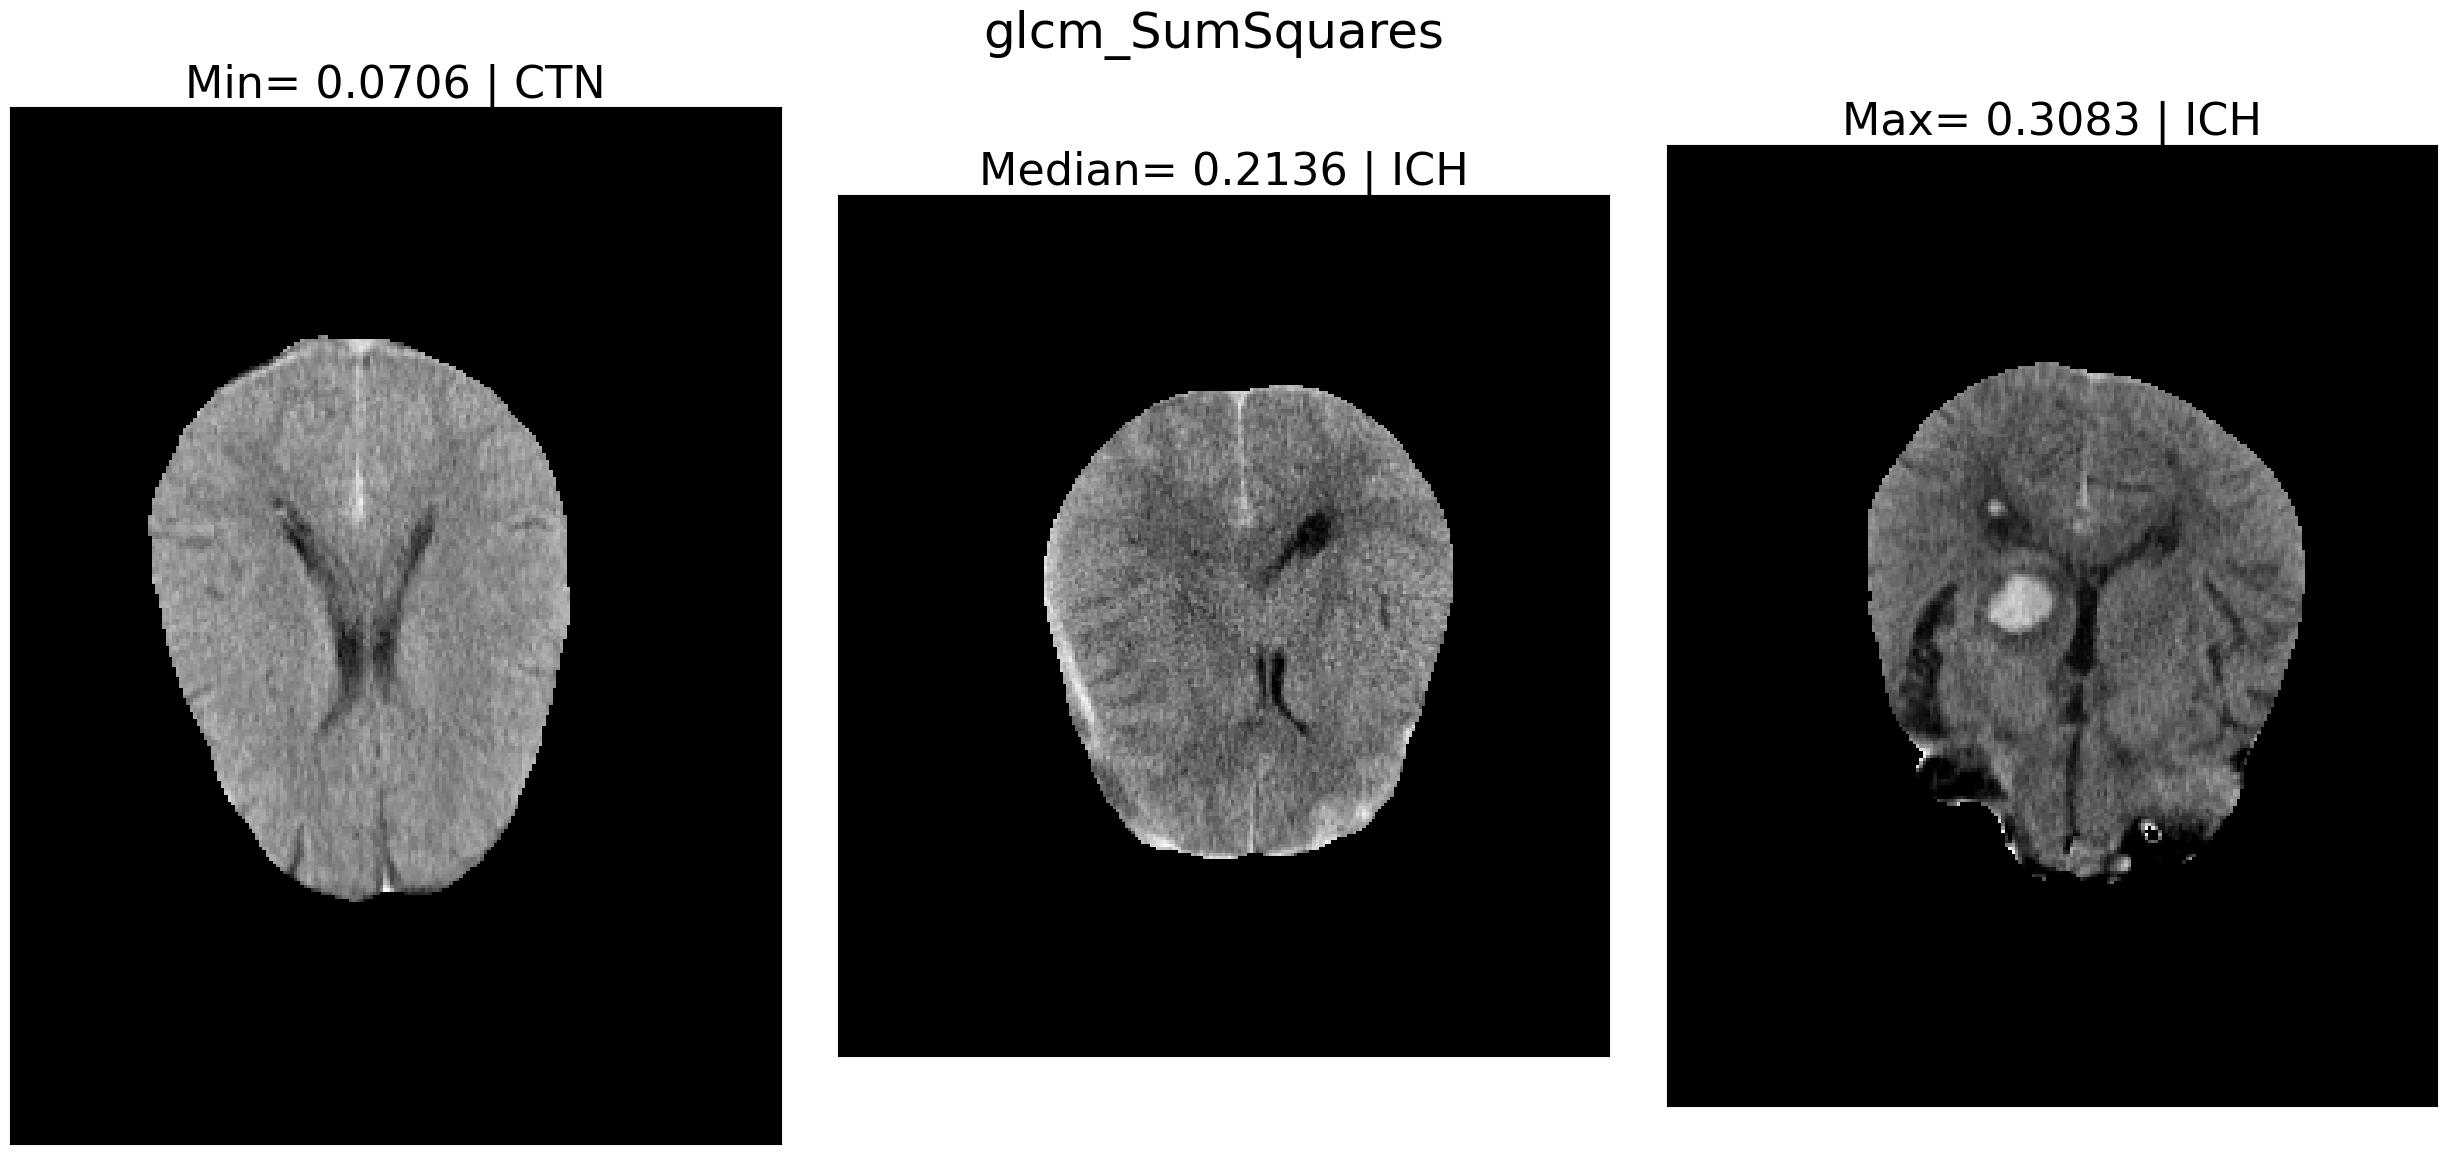

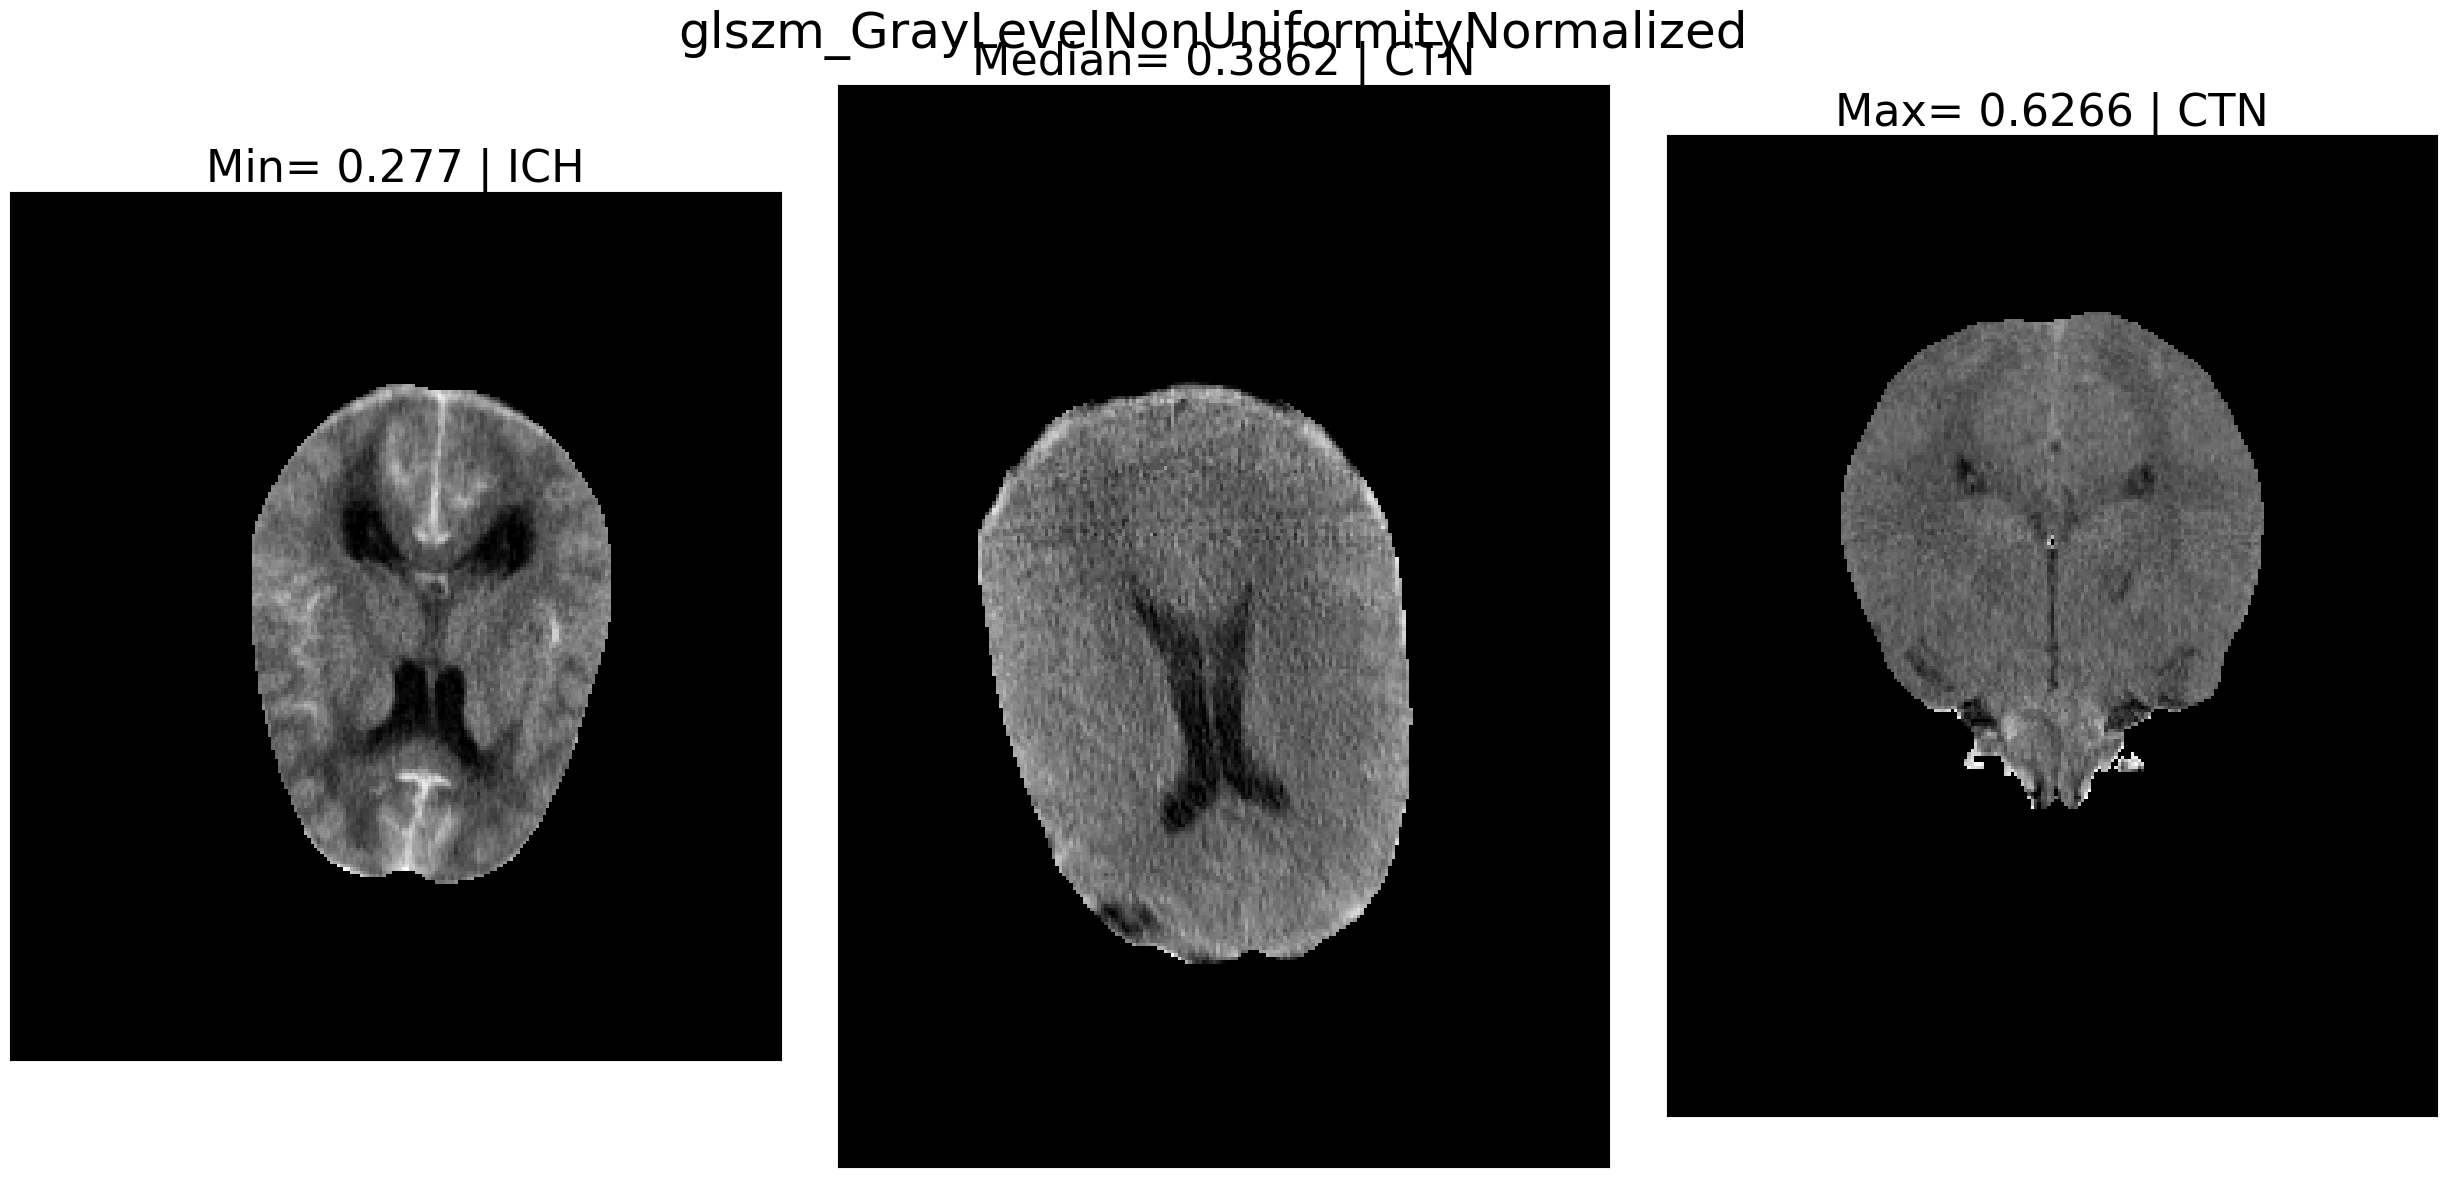

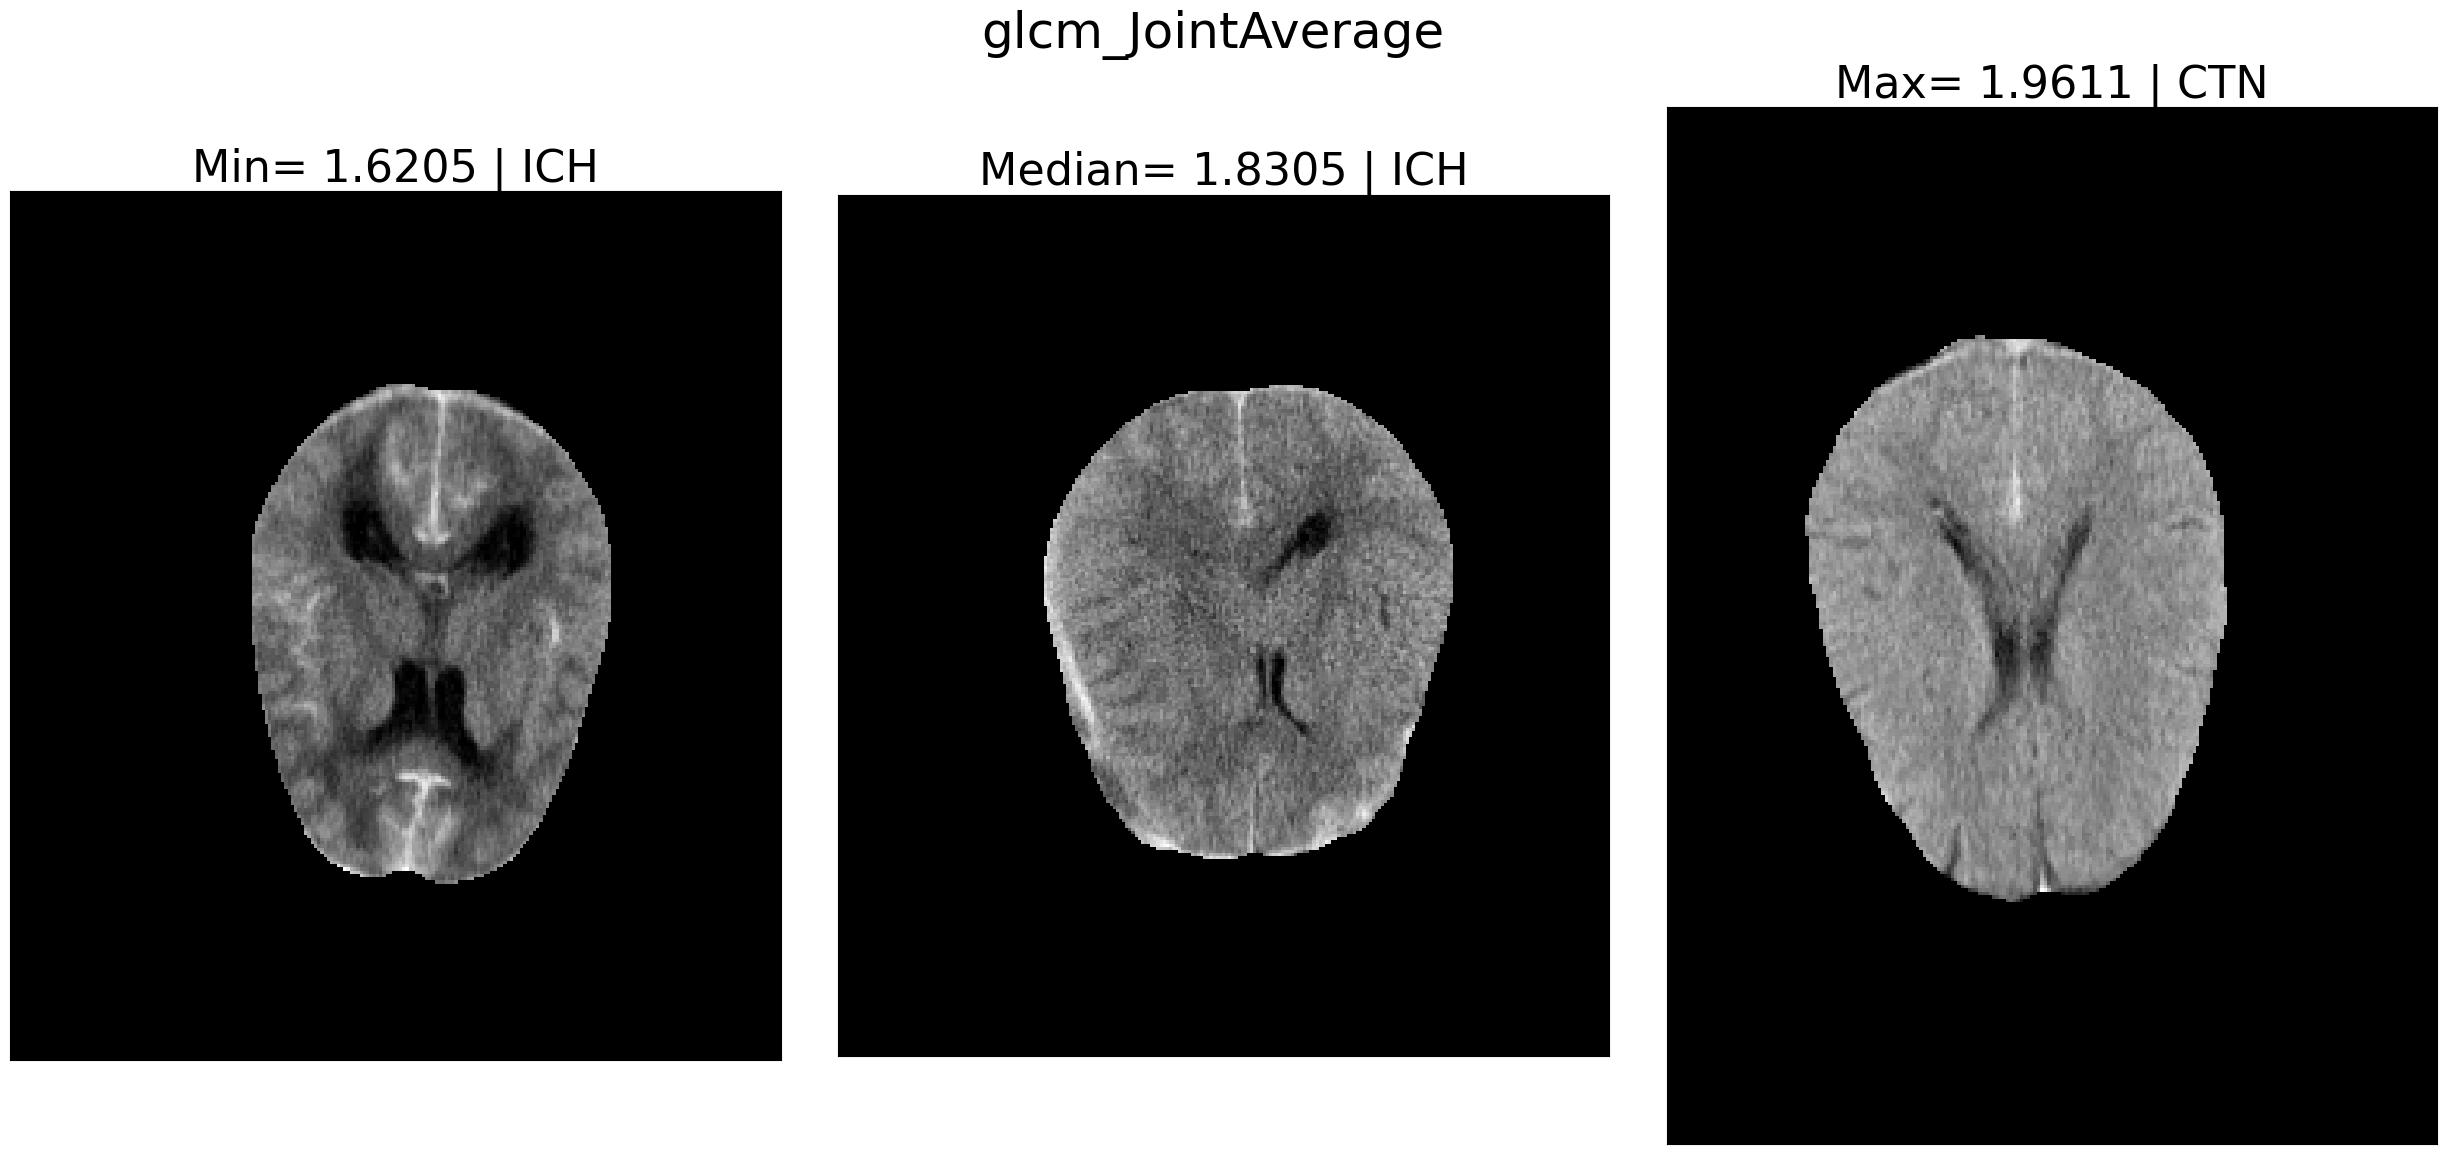

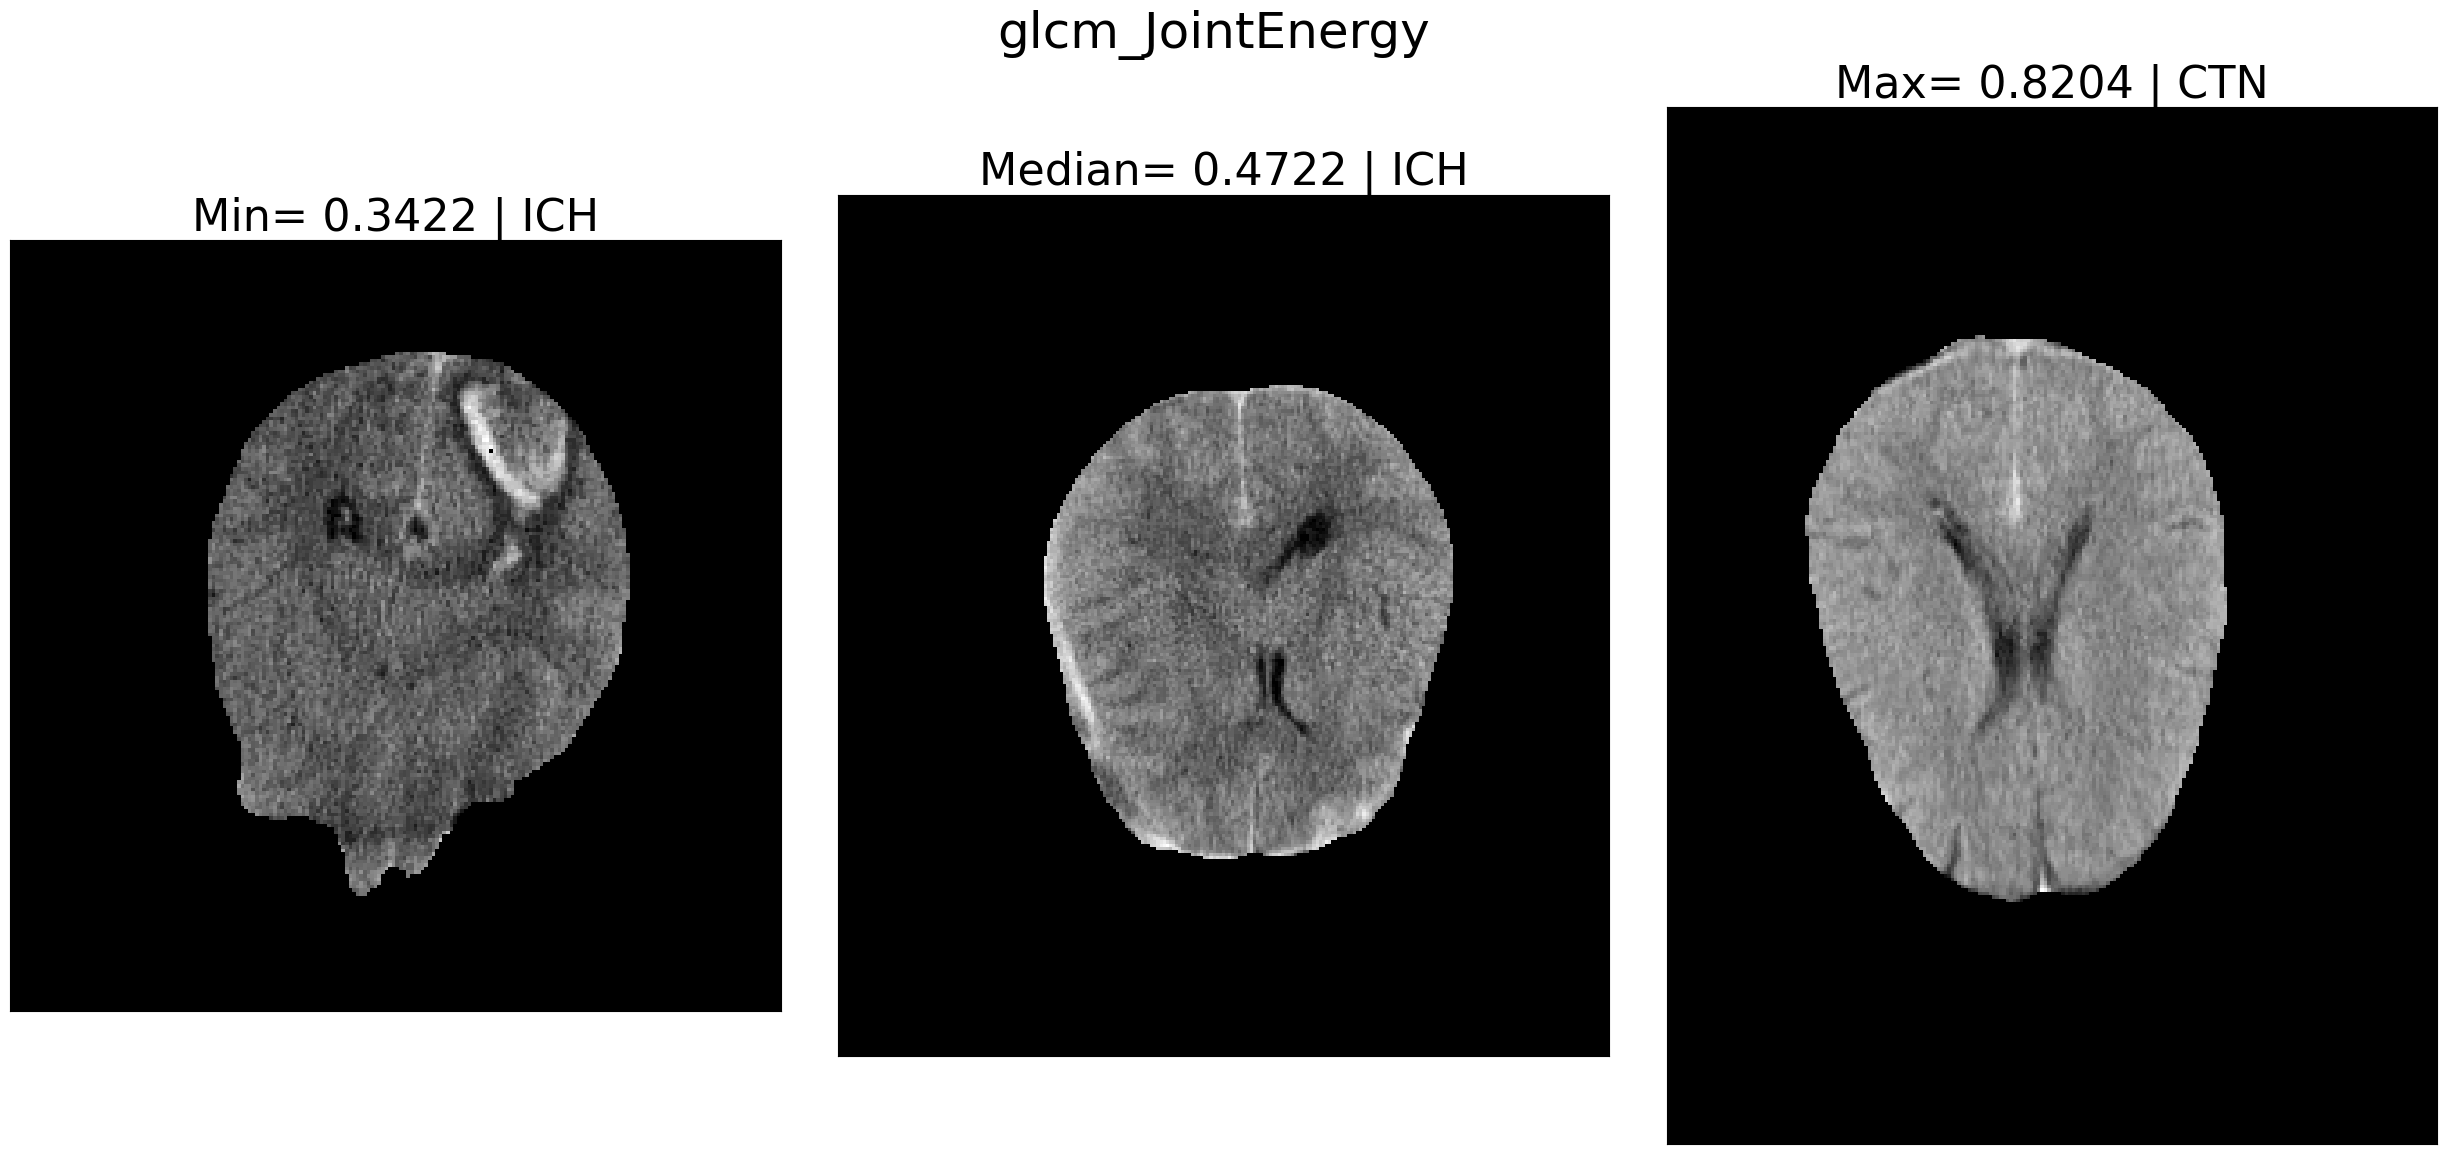

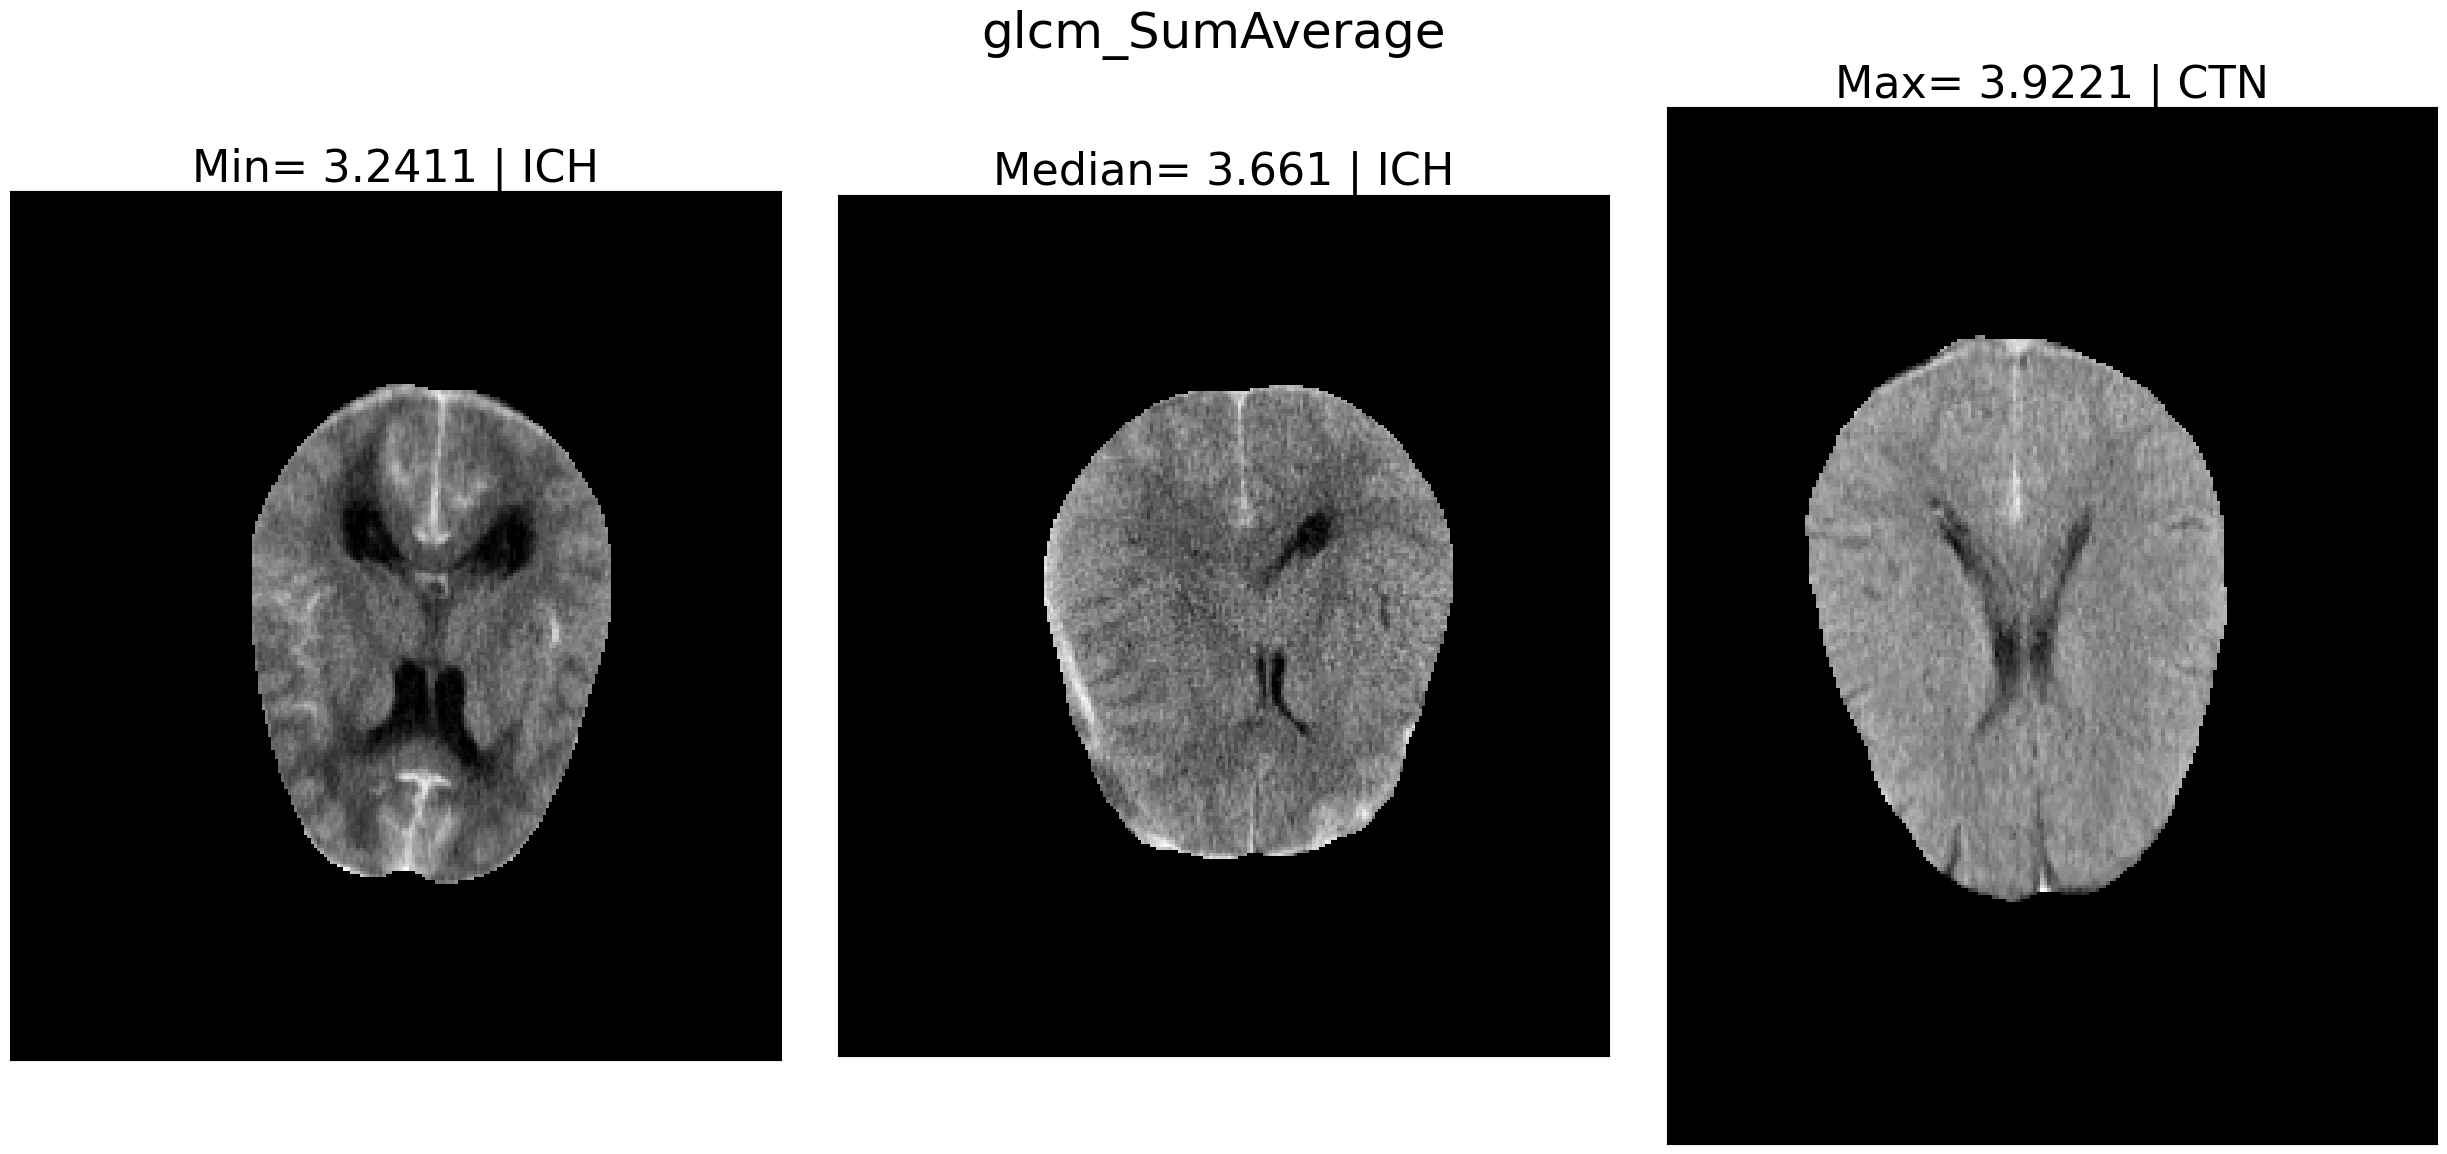

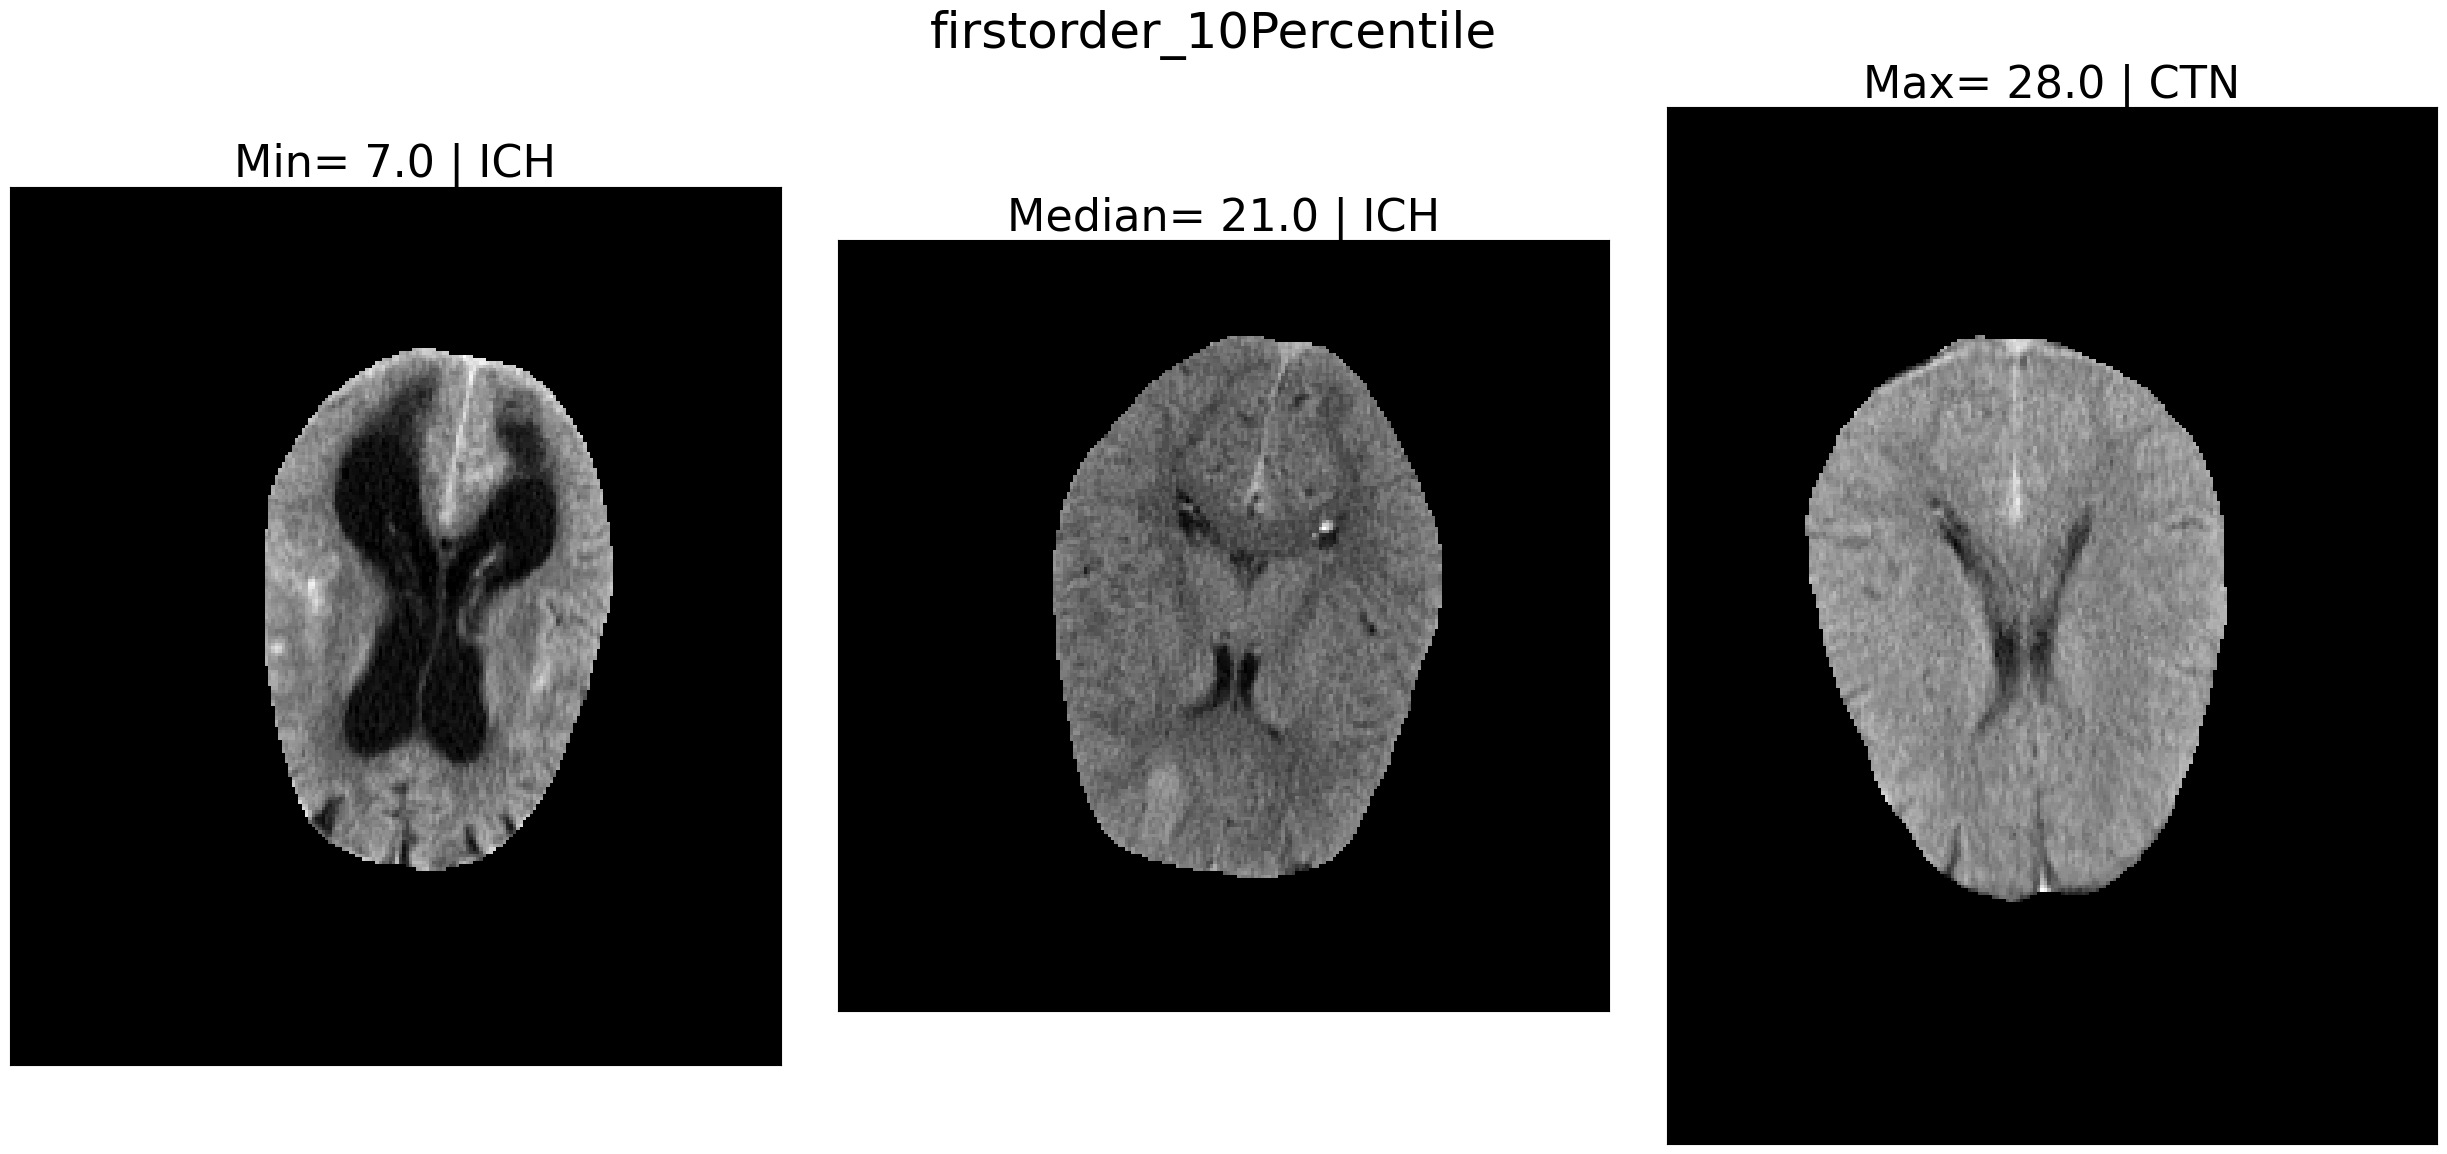

In [292]:
# For each significant feature, visualize the min, median, and max patients' respective CT scans
# For visualization here, default to visualize middle slice

fig_list = []
for feat in feat_names:
    fig, axes = plt.subplots(1,3, figsize=(25,25))
    fig.tight_layout()
    fig.suptitle(feat, fontsize=36, y=0.75)
    
    minidx, maxidx, medidx = ex_dict[feat]['min'], ex_dict[feat]['max'], ex_dict[feat]['median']

    # Get min patient scan
    
    pat = df['pat'].iloc[minidx]
    featval = df[feat].iloc[minidx]
    patlabel = df['label'].iloc[minidx]
    
    img_arr_pl = get_img_arr_pl(pat)
        
    axes[0].imshow(img_arr_pl, cmap = 'gray')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title('Min= ' + str(round(featval, 4)) + ' | ' + patlabel, fontsize=32)

    # Get maedian patient scan
    pat = df['pat'].iloc[medidx]
    featval = df[feat].iloc[medidx]
    patlabel = df['label'].iloc[medidx]
    
    img_arr_pl = get_img_arr_pl(pat)
        
    axes[1].imshow(img_arr_pl, cmap = 'gray')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('Median= ' + str(round(featval, 4)) + ' | ' + patlabel, fontsize=32)

    # Get max patient scan
    pat = df['pat'].iloc[maxidx]
    featval = df[feat].iloc[maxidx]
    patlabel = df['label'].iloc[maxidx]
    
    img_arr_pl = get_img_arr_pl(pat)
        
    axes[2].imshow(img_arr_pl, cmap = 'gray')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title('Max= ' + str(round(featval, 4)) + ' | ' + patlabel, fontsize=32)

    fig_list.append(fig)

    plt.show()

In [293]:
with PdfPages('significant_feature_comparisons.pdf') as pdf:
    for fig in fig_list:
        pdf.savefig(fig, bbox_inches='tight') 

In [313]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Test very basic SVM on selected features using leave-one-out cross validation
cval = np.arange(len(X))
random.seed(0)
random.shuffle(cval)
preds = []

skf = StratifiedKFold(n_splits=10)

for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    X_ = X.copy()
    Y_ = Y.copy()

    # get test samples
    x_test = X_[test_index,:]
    y_test = Y_[test_index]

    # remove test sample to get training set
    x_train = np.delete(X_, test_index, axis=0)
    y_train = np.delete(Y_, test_index, axis=0)

    # Train the Lasso model
    pipeline = Pipeline(steps=[('scaler',StandardScaler()), ('lasso', LogisticRegression(penalty='l1', solver='liblinear'))])
    pipeline.fit(x_train, y_train)

    preds.append(pipeline.score(x_test, y_test))

In [314]:
print('Accuracy across 5 folds:', preds)

Accuracy across 5 folds: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [315]:
# Train on entire dataset to get significant features
pipeline = Pipeline(steps=[('scaler',StandardScaler()), ('lasso', LogisticRegression(penalty='l1', solver='liblinear'))])
pipeline.fit(X_data, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [300]:
feature_coef = pipeline.named_steps['lasso'].coef_

In [301]:
sig_lasso_features = [col_names[i] for i in np.where(feature_coef[0])[0]]

In [302]:
sig_lasso_features

['firstorder_Entropy',
 'firstorder_Mean',
 'firstorder_Skewness',
 'glcm_SumSquares',
 'gldm_DependenceEntropy',
 'gldm_LargeDependenceEmphasis',
 'gldm_LowGrayLevelEmphasis',
 'gldm_SmallDependenceEmphasis']

In [303]:
# For each feature, find the patients with the minimum, maximum and median feature value
# Since number of patients is even, just choose the 14th (num_patients=38 / 2) ranked patient
ex_dict = {}
for feat in sig_lasso_features:
    feat_df = df[feat]
    
    minpat = feat_df[feat_df == feat_df.min()].index[0]
    
    maxpat = feat_df[feat_df == feat_df.max()].index[0]

    tmp = feat_df.copy()
    tmp = tmp.sort_values()
    medpat = tmp.index[int(len(tmp)/2)]
    
    ex_dict[feat] = {'min': minpat, 'max': maxpat, 'median': medpat}

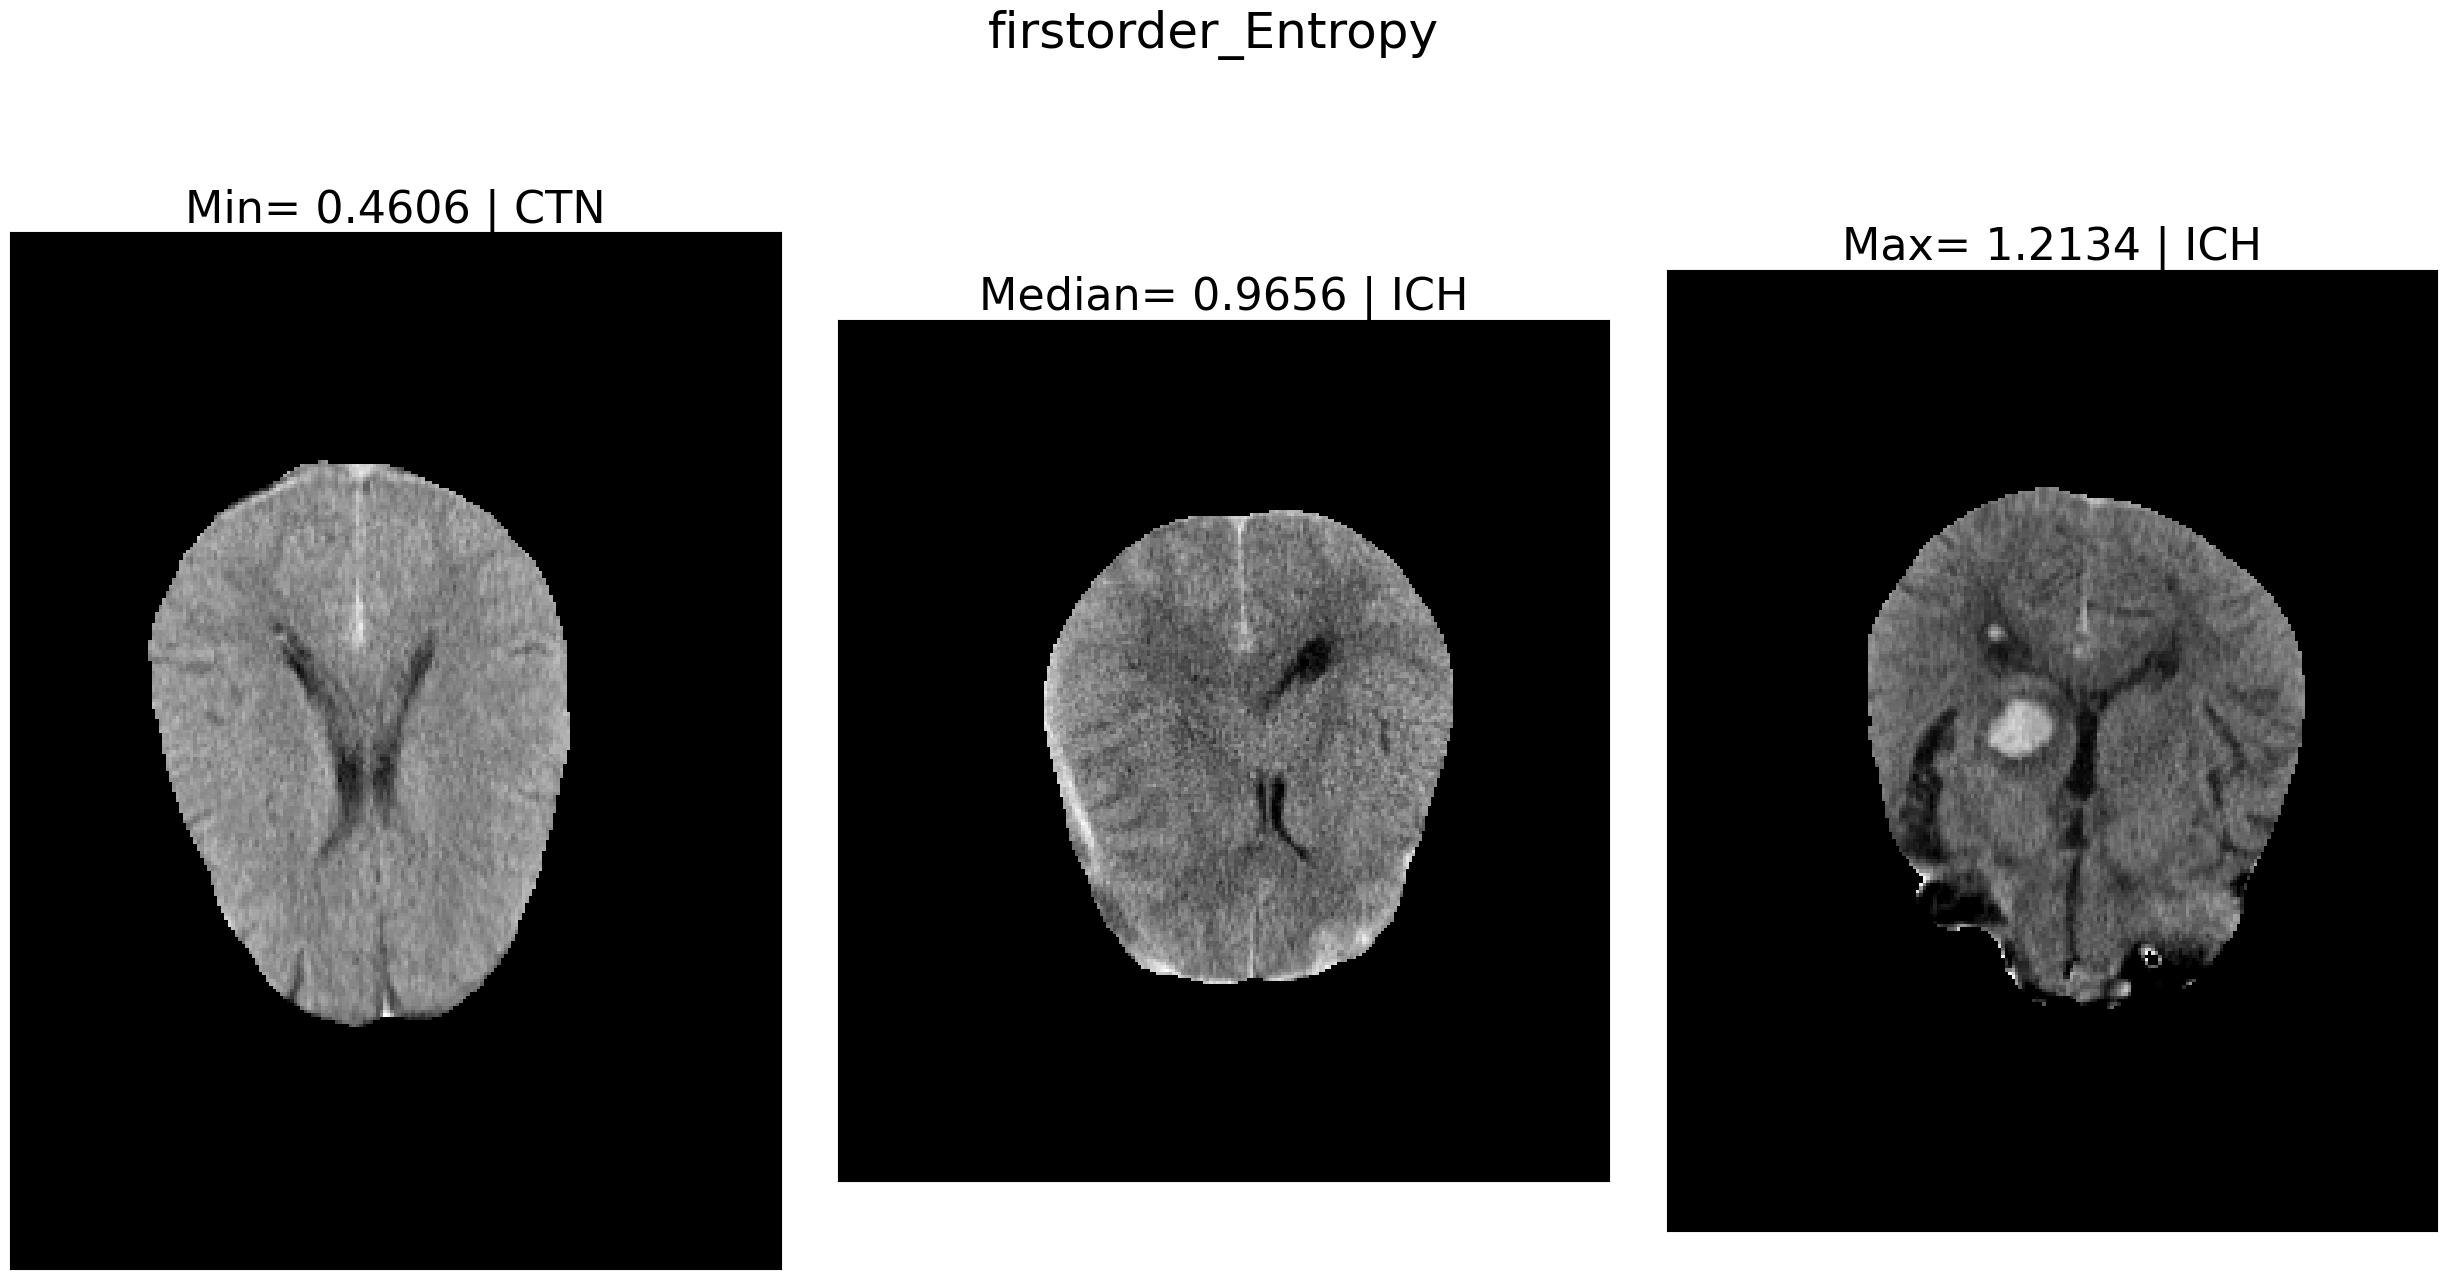

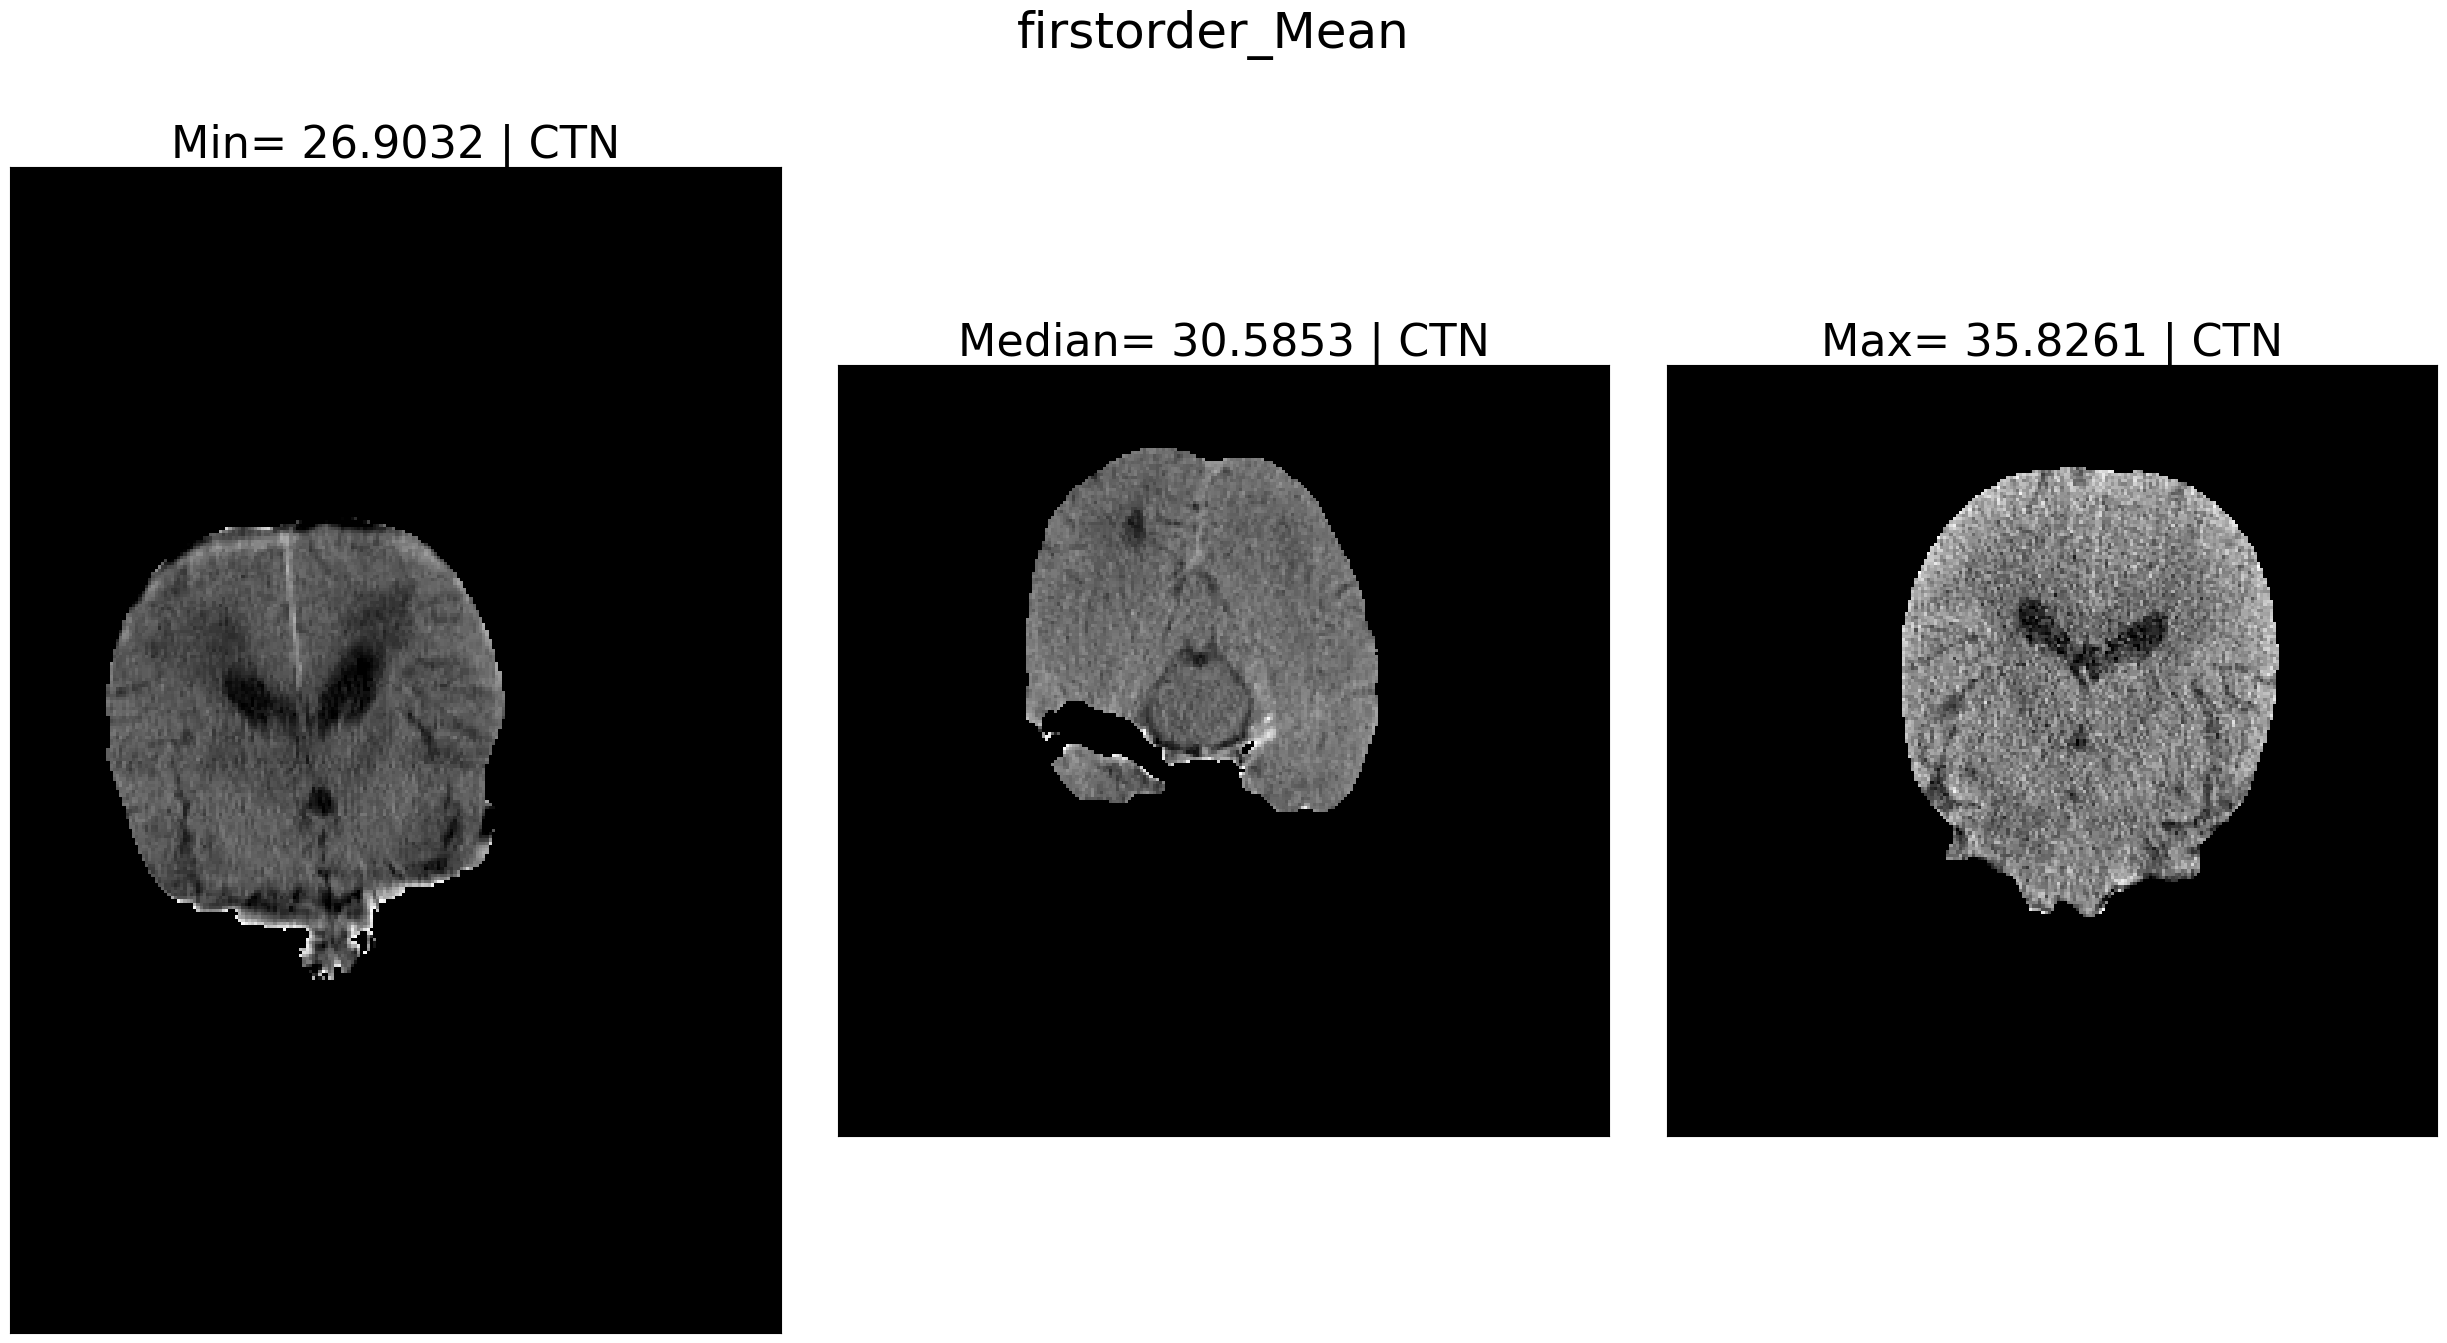

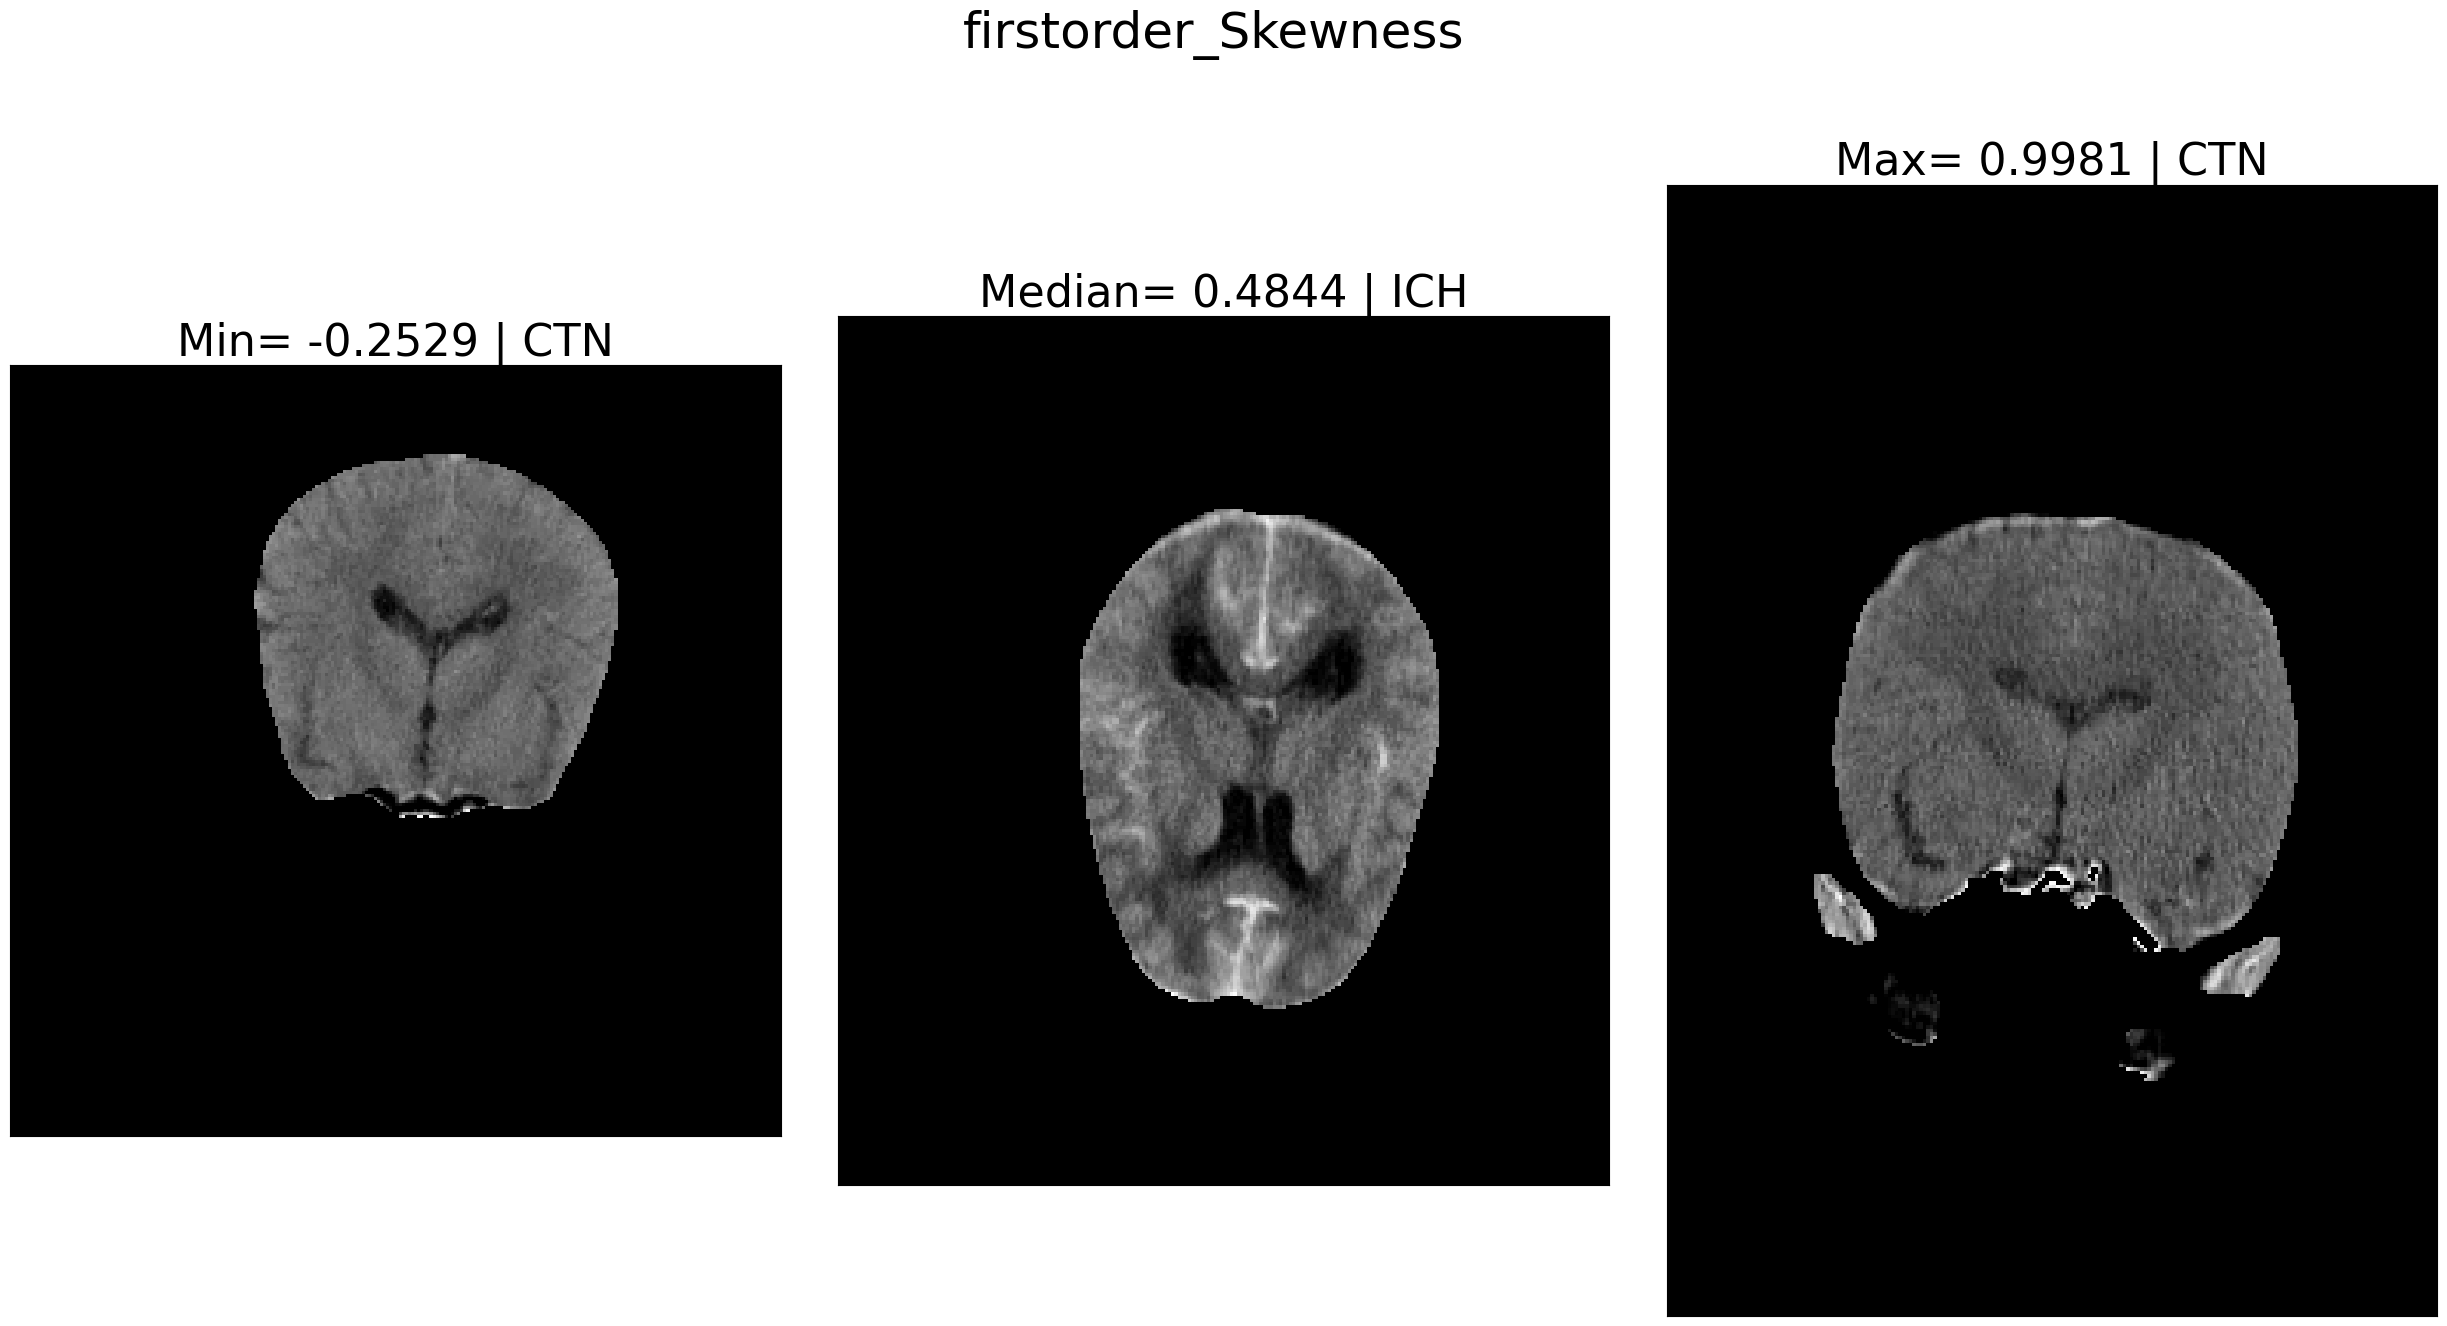

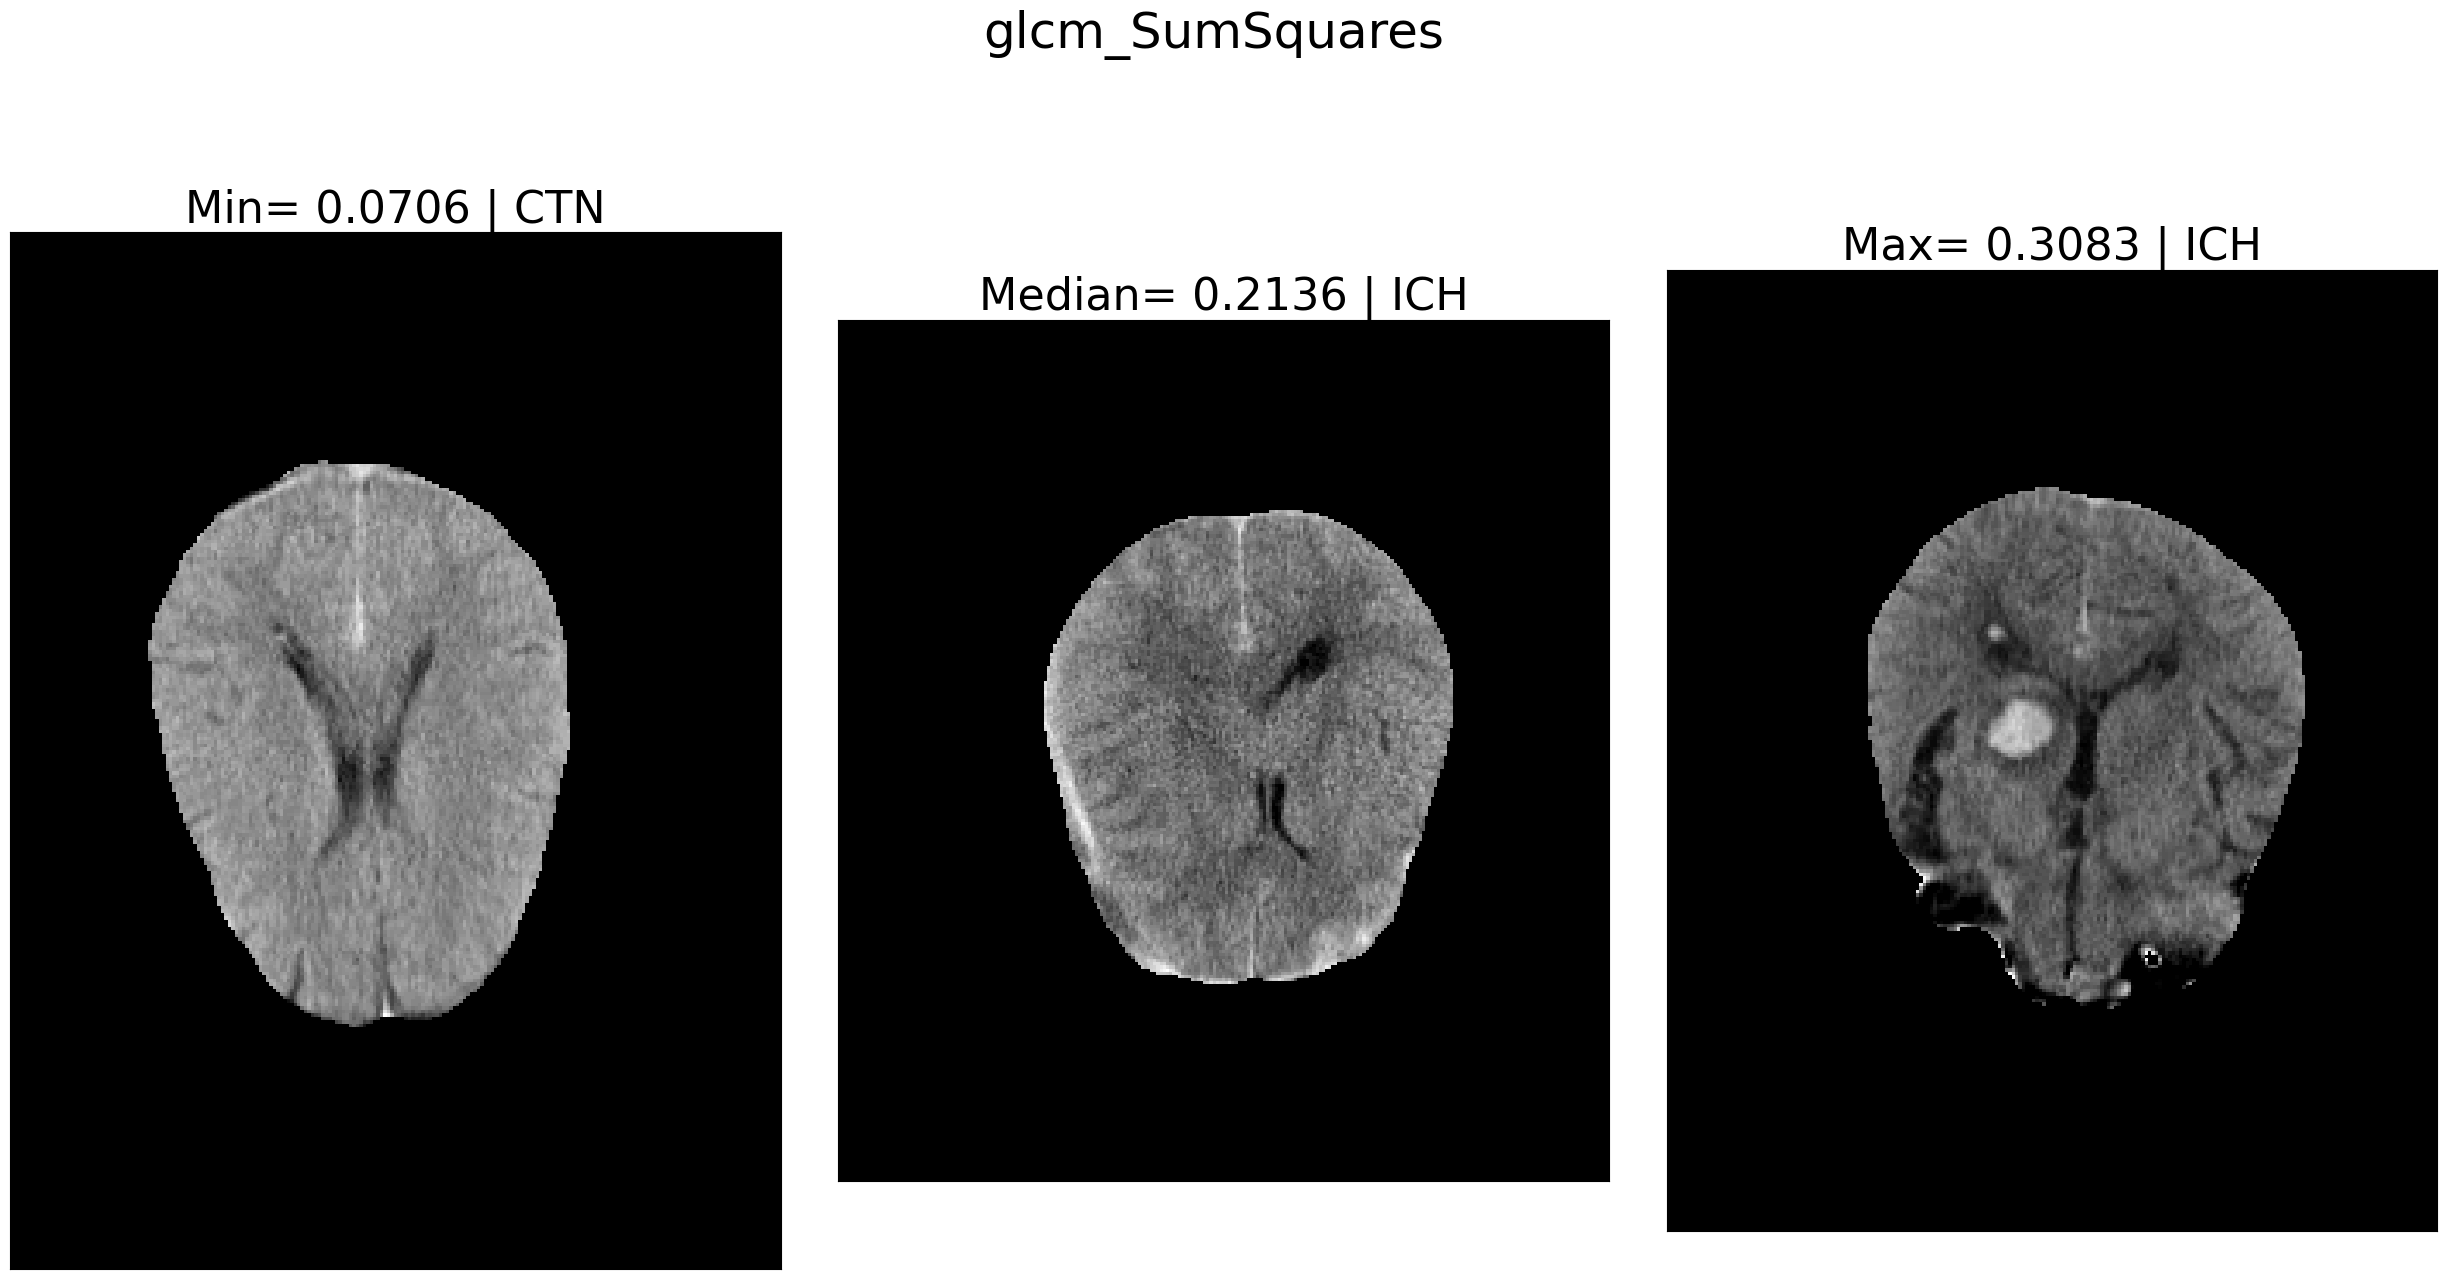

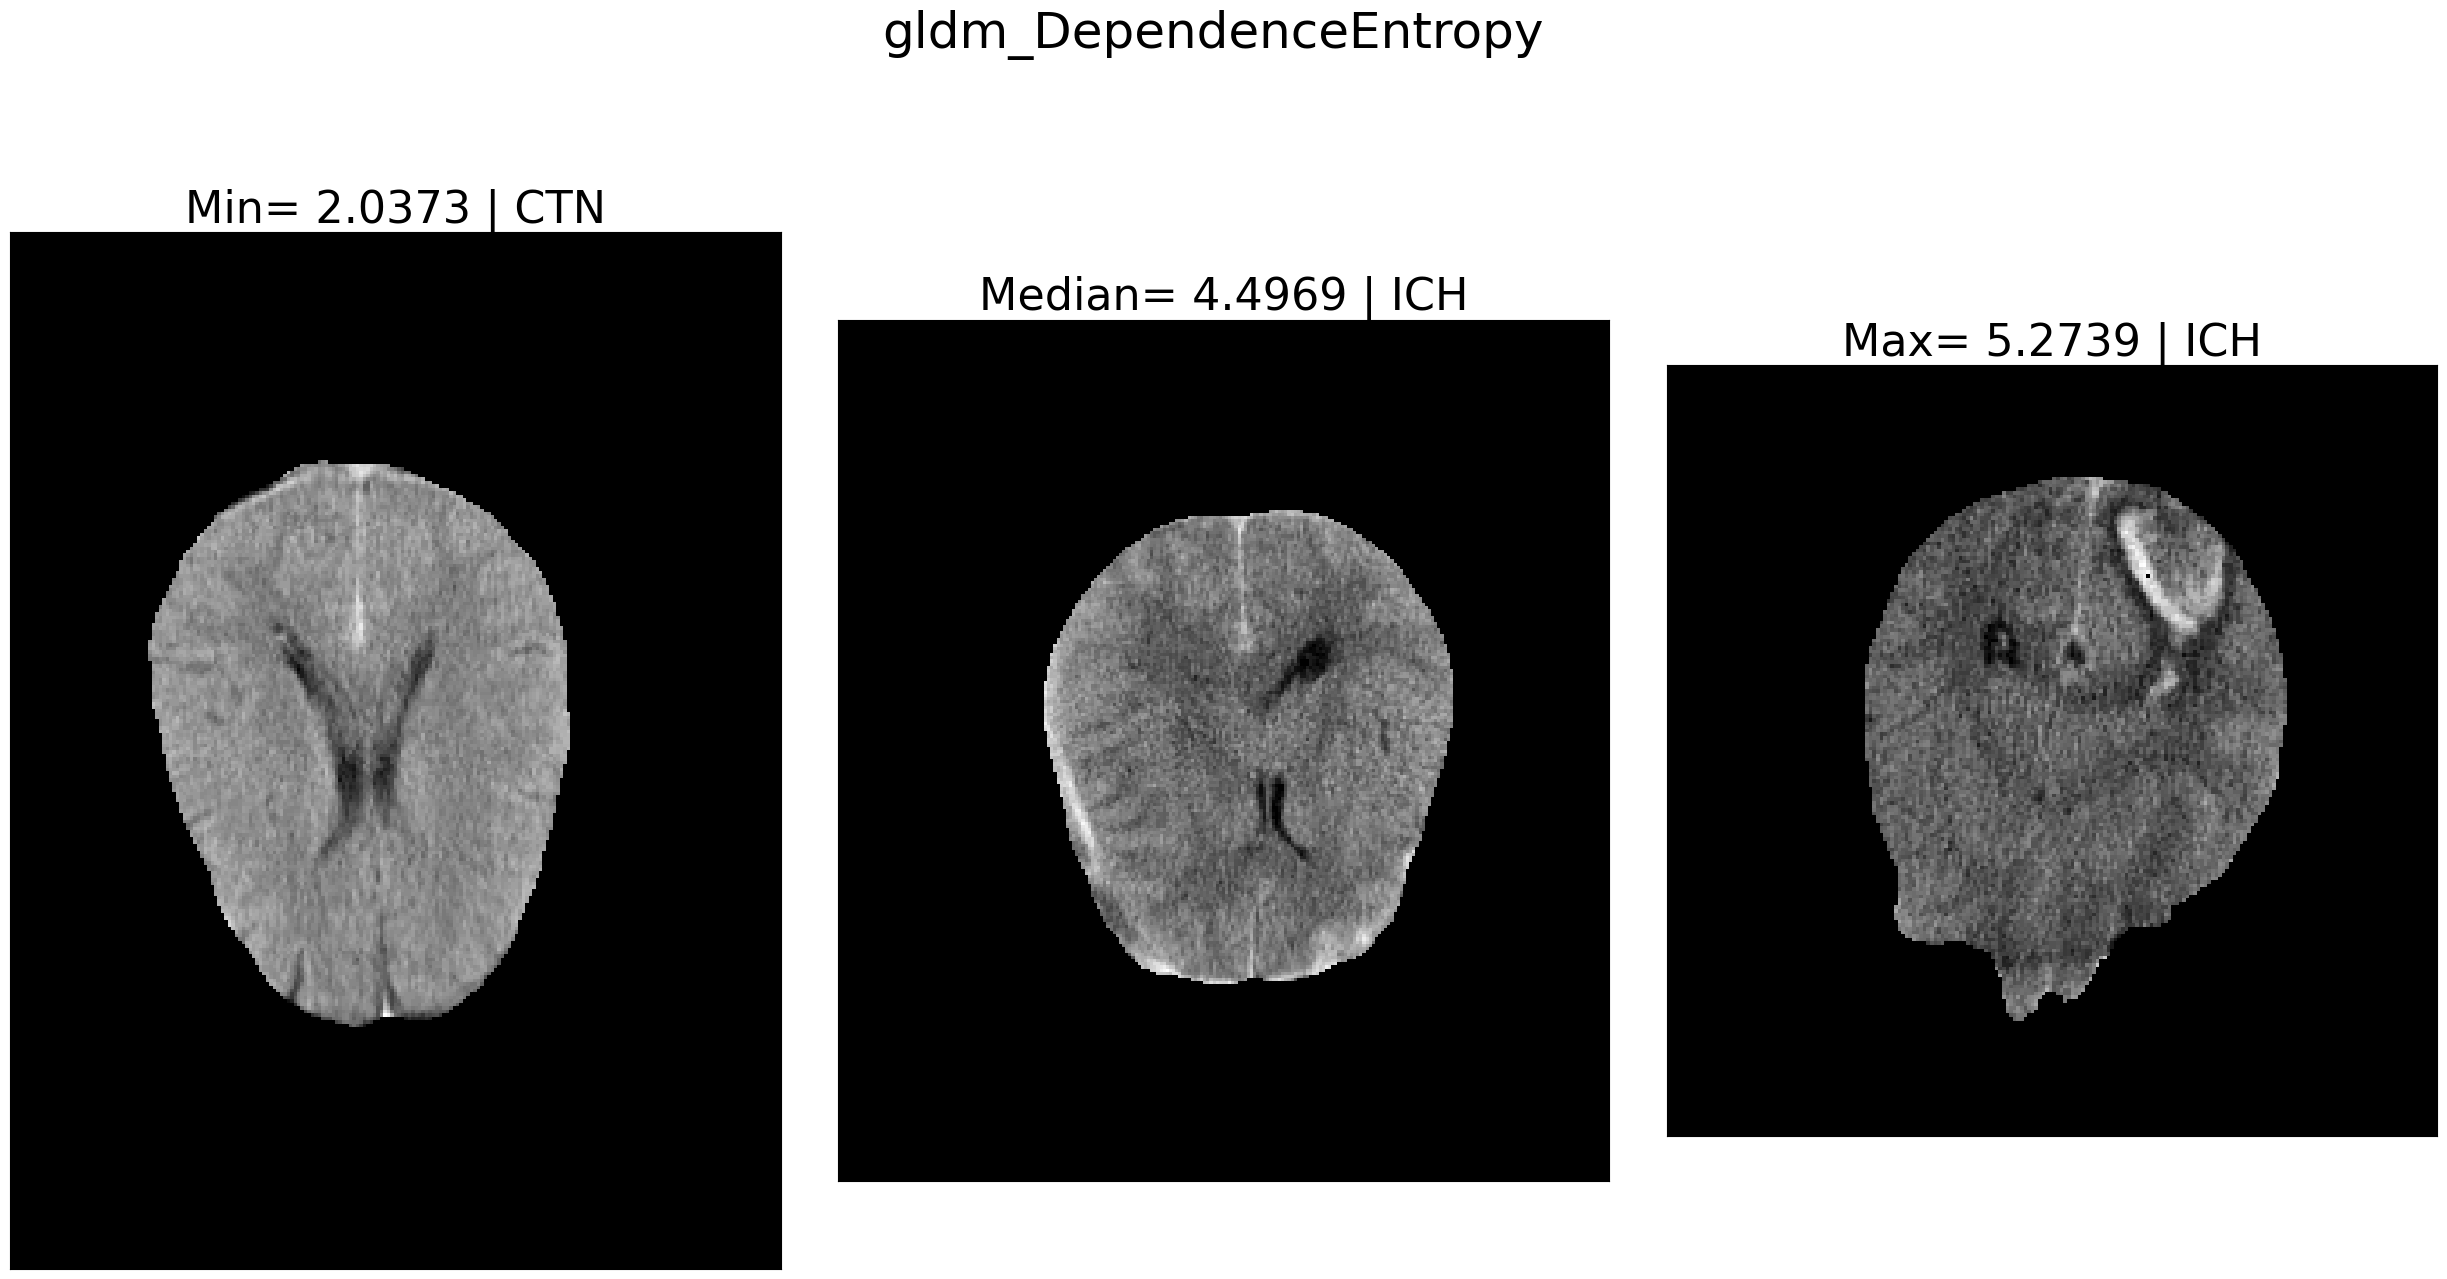

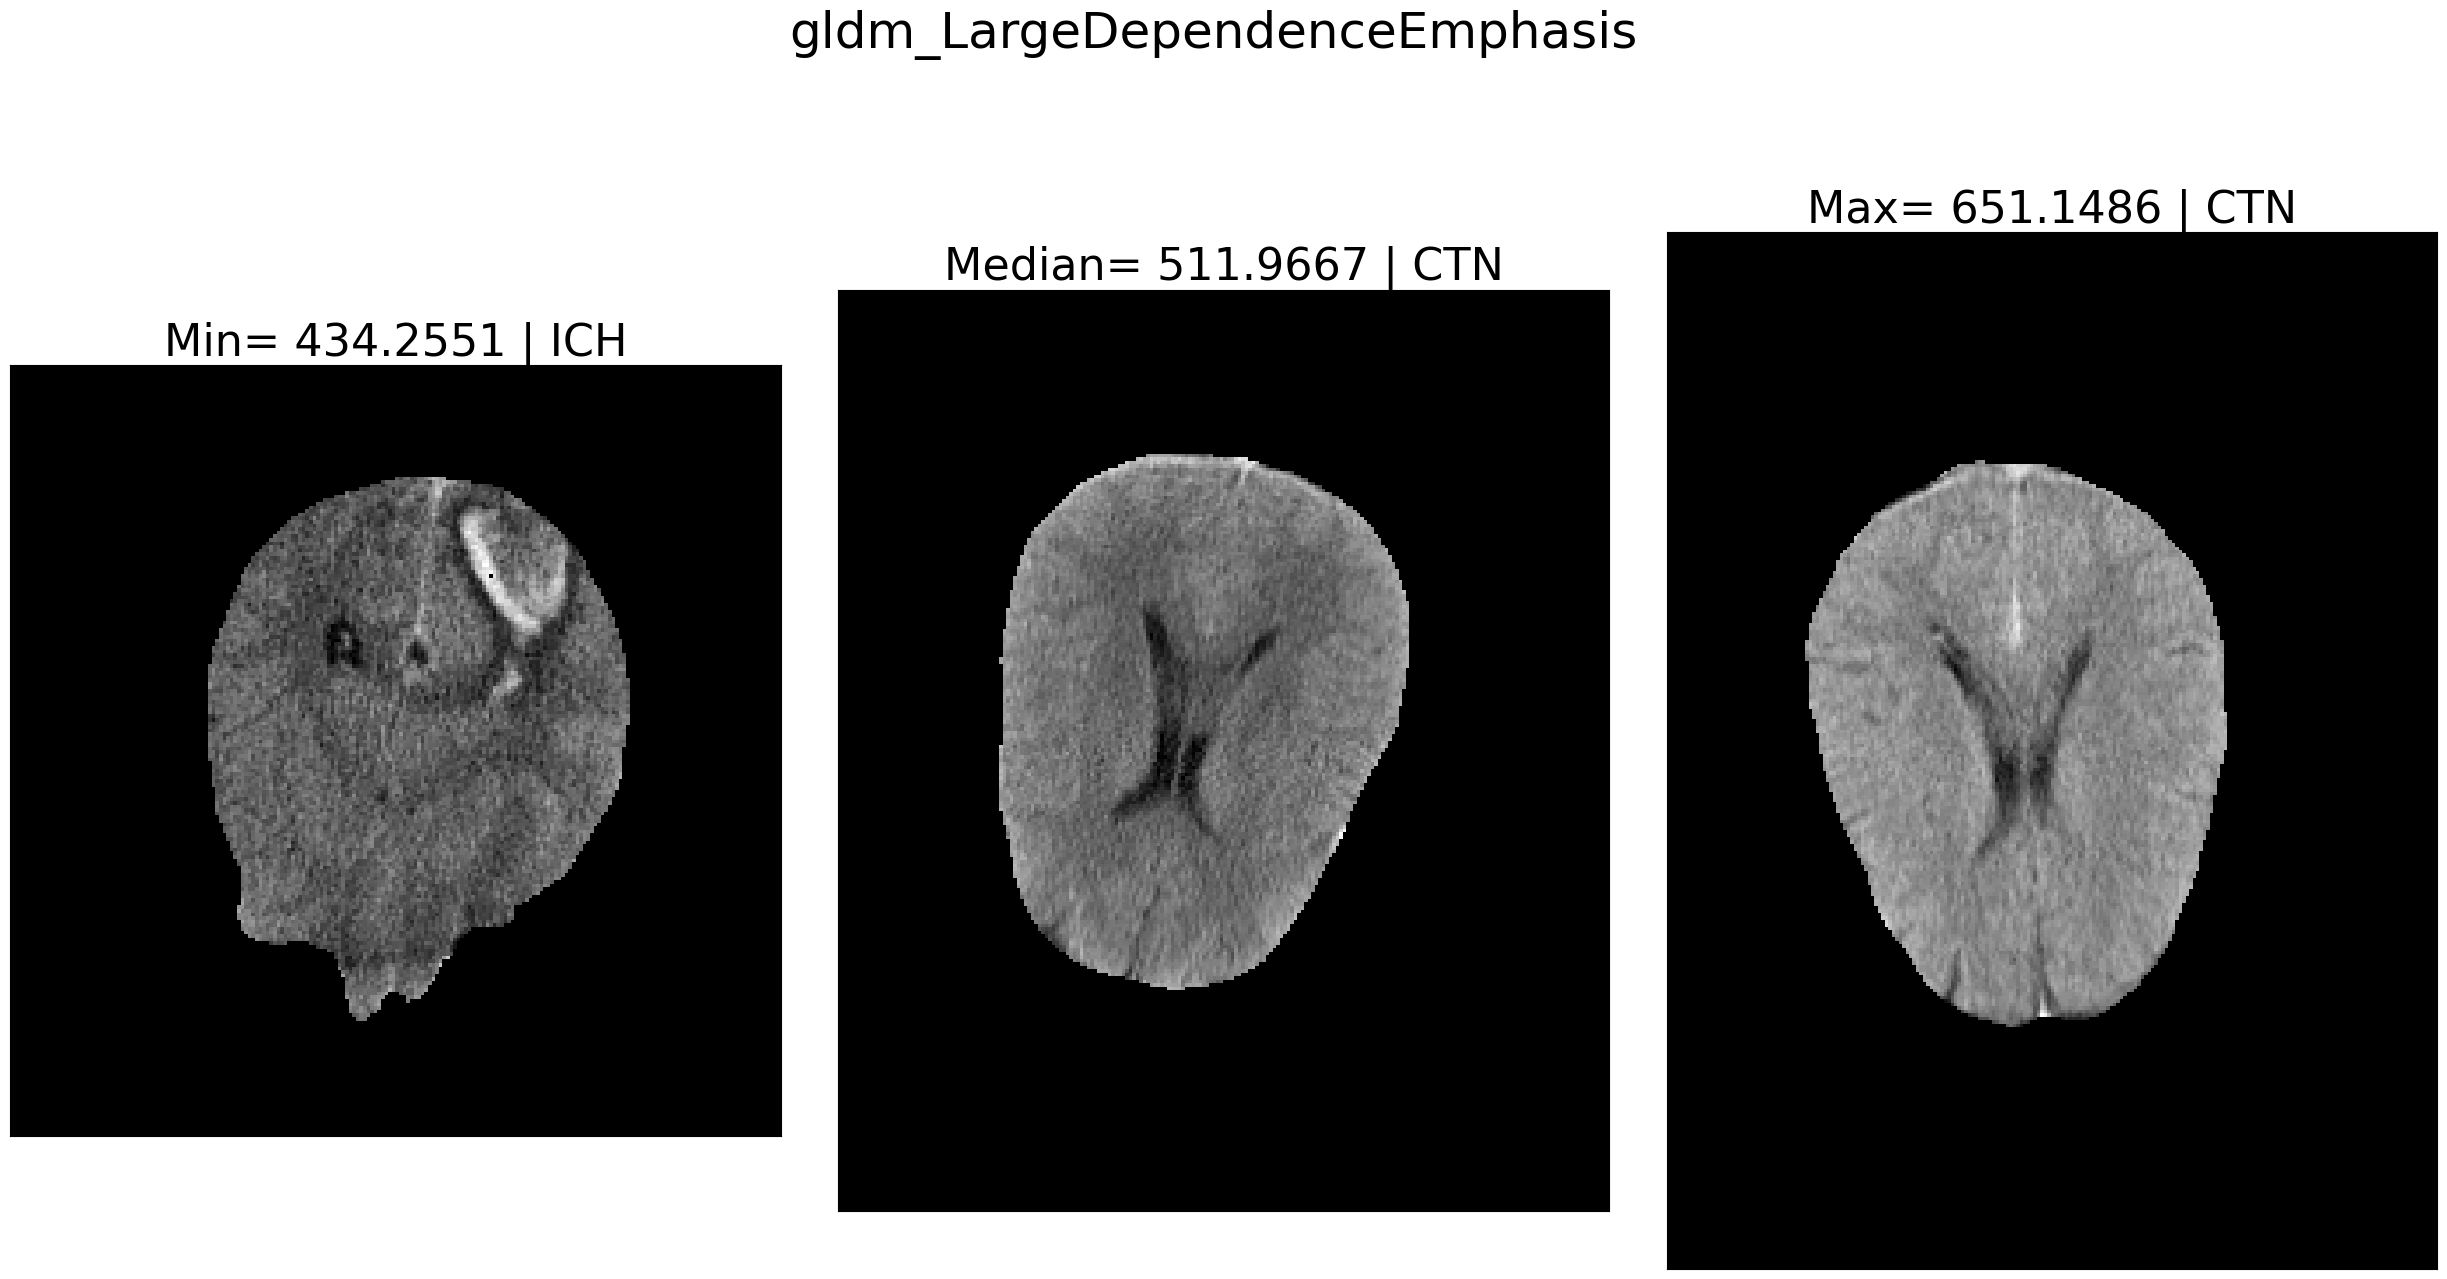

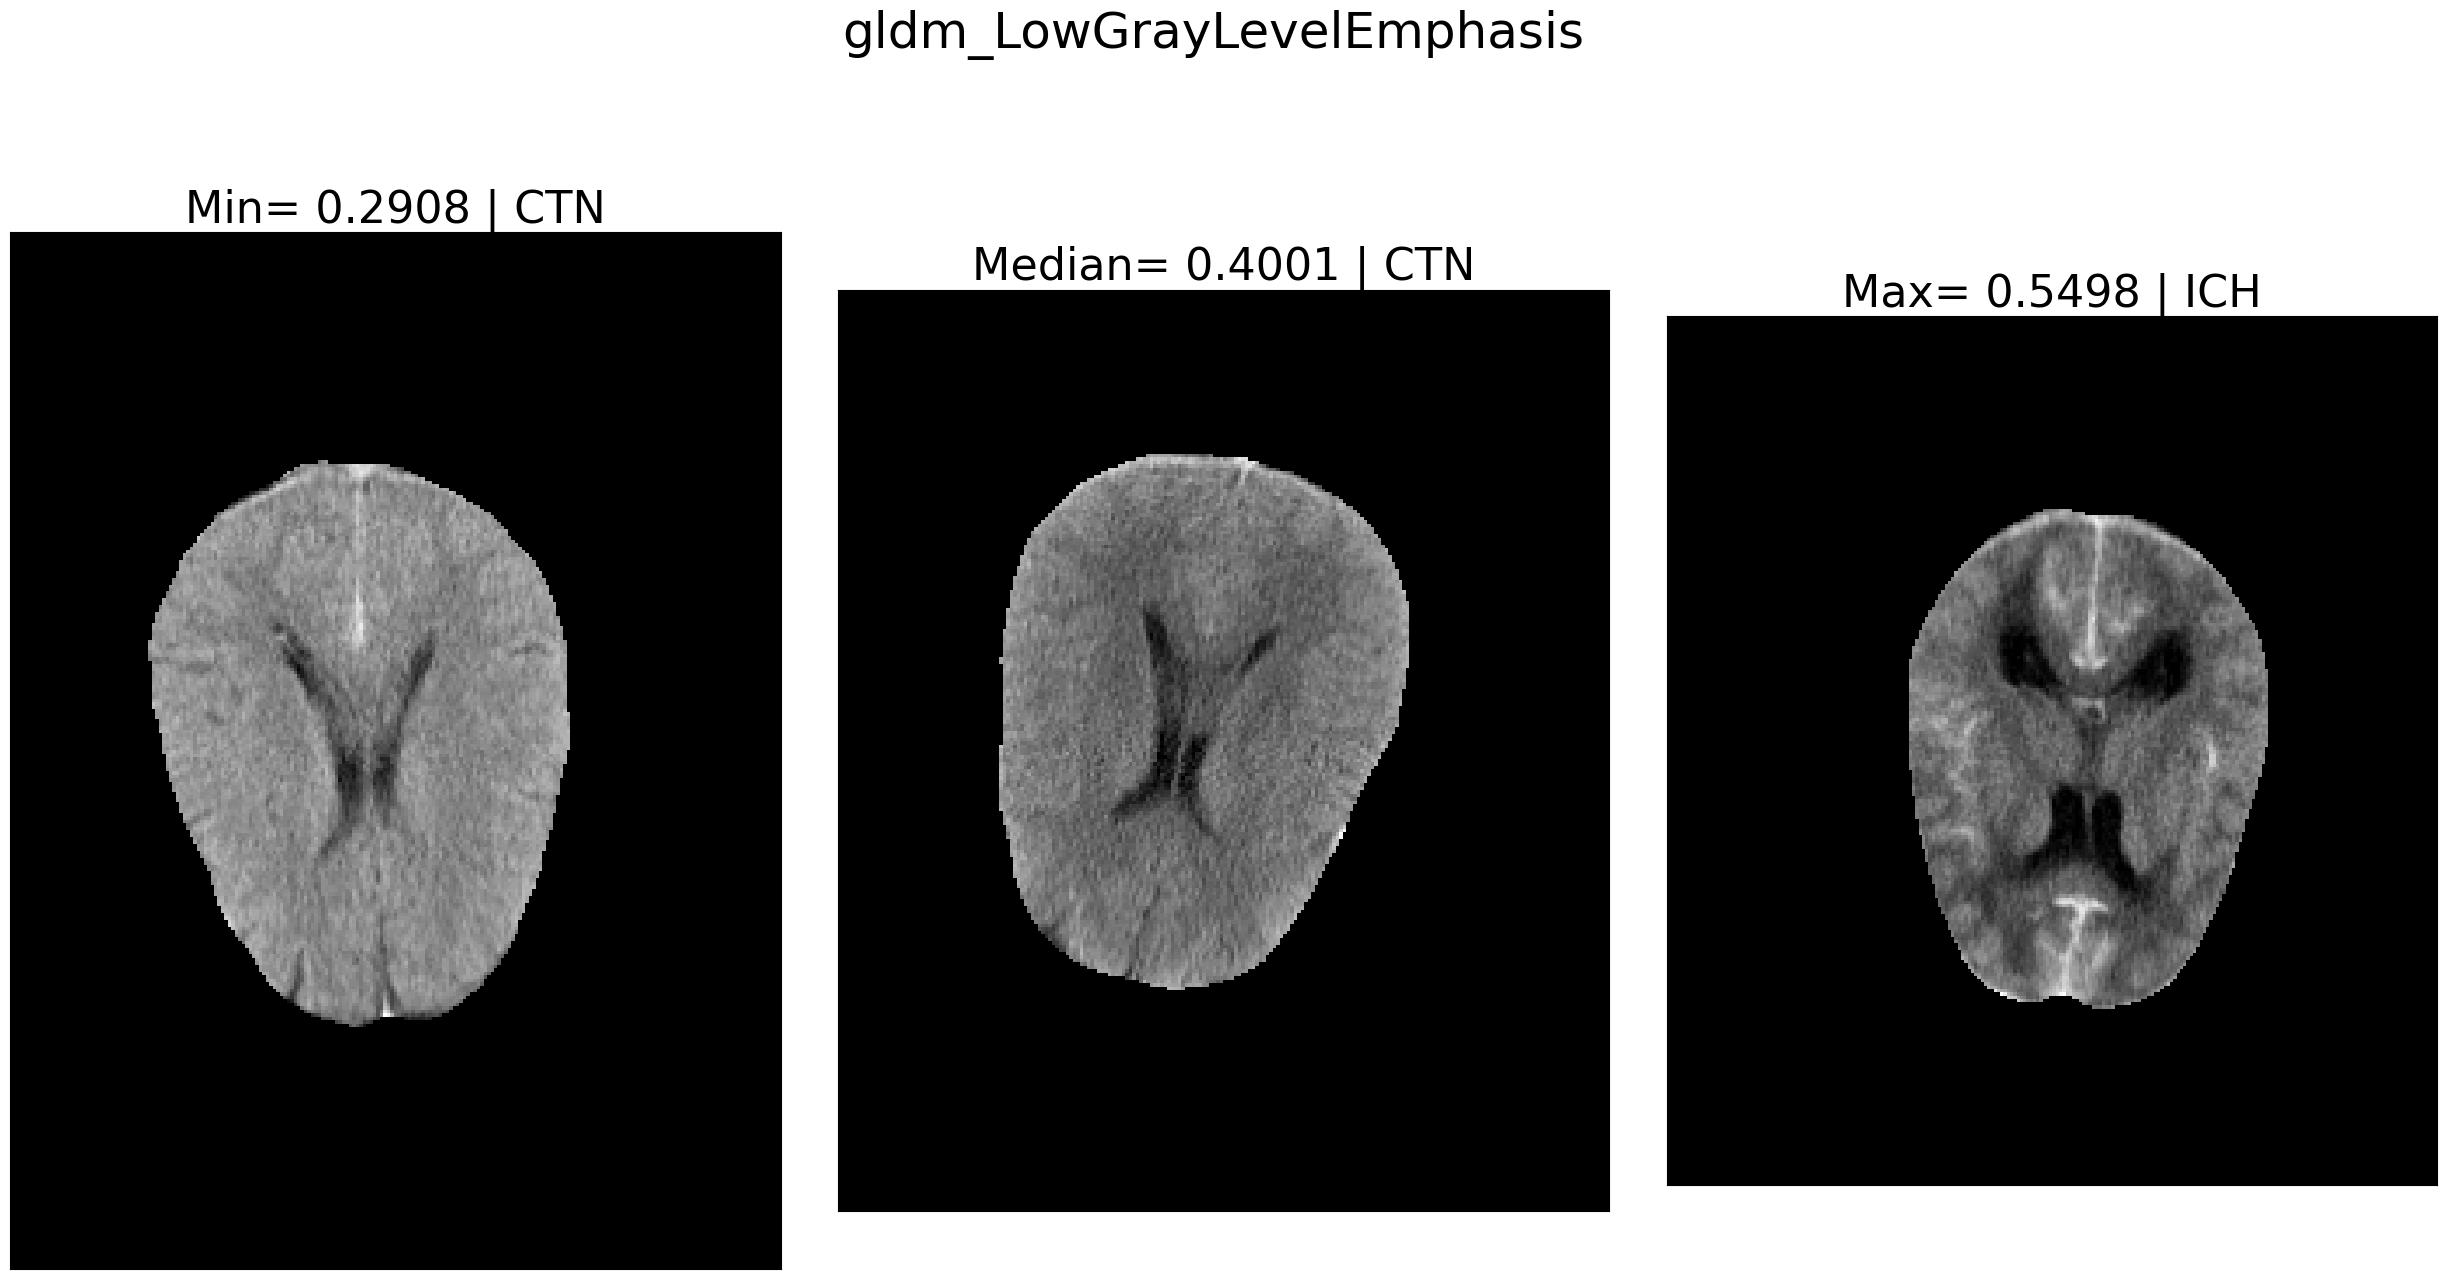

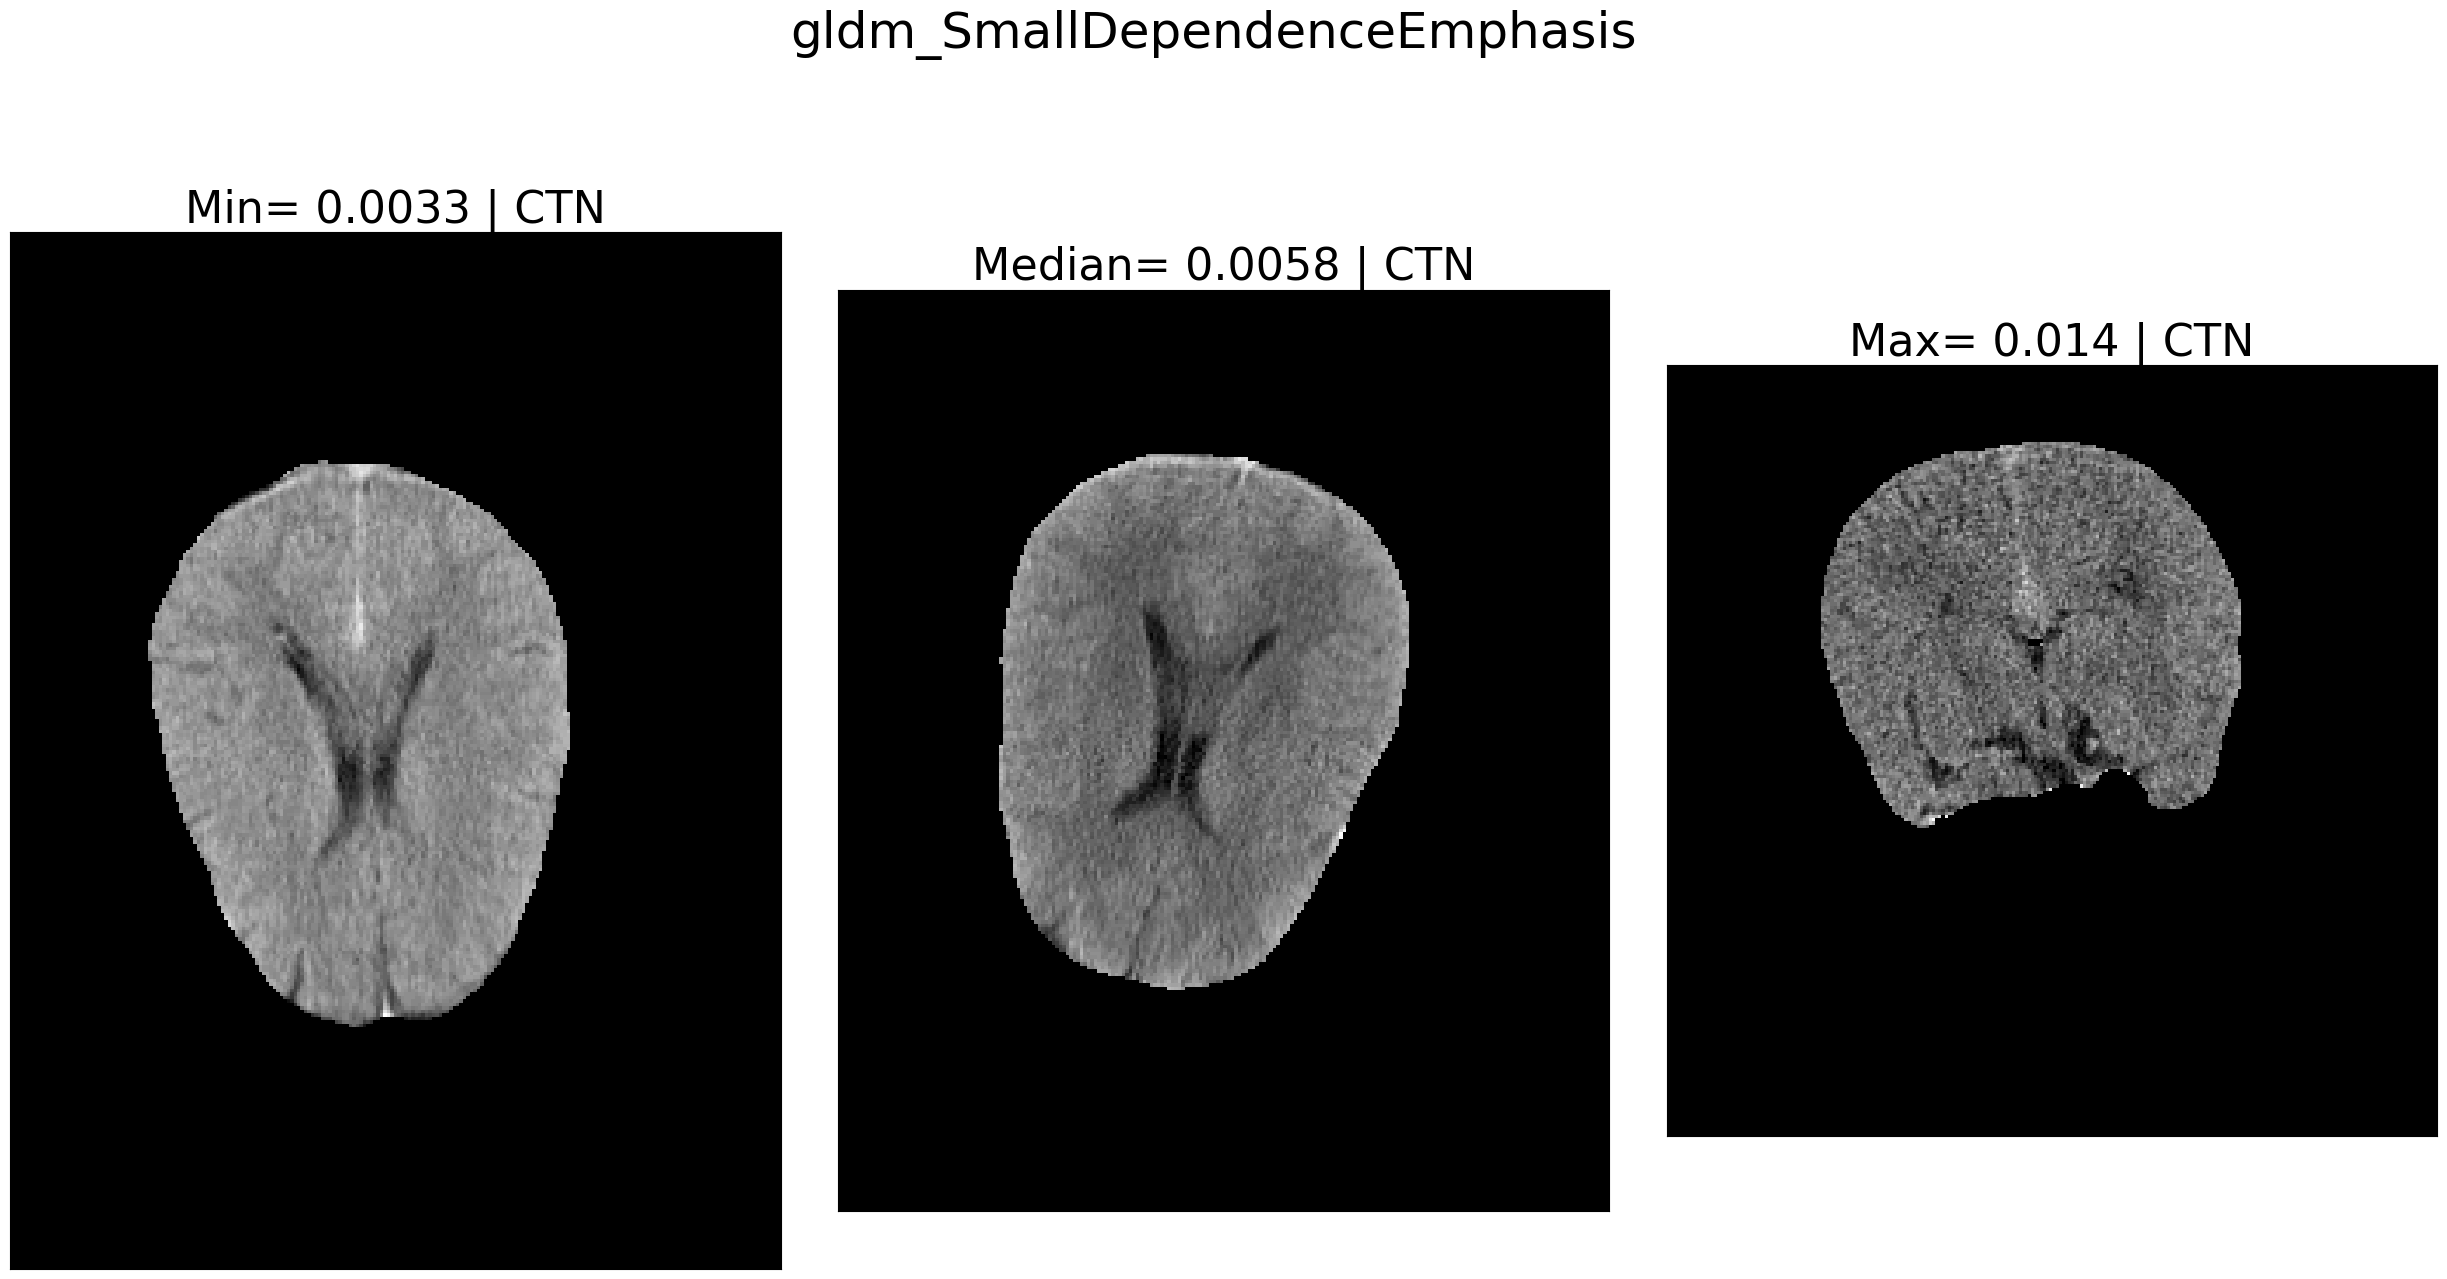

In [304]:
# For each significant feature, visualize the min, median, and max patients' respective CT scans
# For visualization here, default to visualize middle slice

fig_list = []
for feat in sig_lasso_features:
    fig, axes = plt.subplots(1,3, figsize=(25,25))
    fig.tight_layout()
    fig.suptitle(feat, fontsize=36, y=0.8)
    
    minidx, maxidx, medidx = ex_dict[feat]['min'], ex_dict[feat]['max'], ex_dict[feat]['median']

    # Get min patient scan
    
    pat = df['pat'].iloc[minidx]
    featval = df[feat].iloc[minidx]
    patlabel = df['label'].iloc[minidx]
    
    img_arr_pl = get_img_arr_pl(pat)
        
    axes[0].imshow(img_arr_pl, cmap = 'gray')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title('Min= ' + str(round(featval, 4)) + ' | ' + patlabel, fontsize=32)

    # Get maedian patient scan
    pat = df['pat'].iloc[medidx]
    featval = df[feat].iloc[medidx]
    patlabel = df['label'].iloc[medidx]
    
    img_arr_pl = get_img_arr_pl(pat)
        
    axes[1].imshow(img_arr_pl, cmap = 'gray')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].set_title('Median= ' + str(round(featval, 4)) + ' | ' + patlabel, fontsize=32)

    # Get max patient scan
    pat = df['pat'].iloc[maxidx]
    featval = df[feat].iloc[maxidx]
    patlabel = df['label'].iloc[maxidx]
    
    img_arr_pl = get_img_arr_pl(pat)
        
    axes[2].imshow(img_arr_pl, cmap = 'gray')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    axes[2].set_title('Max= ' + str(round(featval, 4)) + ' | ' + patlabel, fontsize=32)

    fig_list.append(fig)

    plt.show()

In [263]:
with PdfPages('lasso_significant_feature_comparisons.pdf') as pdf:
    for fig in fig_list:
        pdf.savefig(fig, bbox_inches='tight') 